In [ ]:
"""
End‑to‑end pipeline for evaluating custom logistic‑regression variants on multiple
CSV datasets with class imbalance.  The script performs:
    • Robust preprocessing and target binarisation
    • Train/test split with stratification
    • Scaling (StandardScaler)
    • Model fitting for six custom estimators
    • Metric collection: accuracy, balanced accuracy, precision, recall, F1,
      ROC‑AUC and G‑mean
    • ROC and Precision‑Recall curve plotting
    • Confusion‑matrix visualisation
    • Aggregate metric table and paired t‑tests (with confidence intervals)

All comments are in English for clarity.
"""

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib
from glob import glob
import sys

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc, balanced_accuracy_score, confusion_matrix, precision_recall_curve, average_precision_score, ConfusionMatrixDisplay
)

from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy.stats import t, ttest_rel

In [2]:
# ---------------------------------------------------------------------------
# 1.  Dynamic import of custom models
# ---------------------------------------------------------------------------

# Ensure the parent directory (containing the ``src`` package) is on sys.path
sys.path.append(os.path.abspath("../"))

# Importa os módulos do src
import src.BCE_Logistic_regression
import src.BCE_Logistic_Sigmoid
import src.Weighted_BCE_Logistic_regression
import src.Weighted_BCE_Logistic_regression_New_Sigmoid
import src.Focal_Loss_Logistic_Regression
import src.Focal_Loss_DynamicAlpha_Logistic_Regression

# Reload in case the user is changing the code between runs
for m in [
    src.BCE_Logistic_regression,
    src.BCE_Logistic_Sigmoid,
    src.Weighted_BCE_Logistic_regression,
    src.Weighted_BCE_Logistic_regression_New_Sigmoid,
    src.Focal_Loss_Logistic_Regression,
    src.Focal_Loss_DynamicAlpha_Logistic_Regression,
]:
    importlib.reload(m)

from src.BCE_Logistic_regression import LogisticRegression as BCE_Logistic
from src.BCE_Logistic_Sigmoid import BCE_Logistic_Sigmoid
from src.Weighted_BCE_Logistic_regression import LogisticRegression as Weighted_Logistic
from src.Weighted_BCE_Logistic_regression_New_Sigmoid import LogisticRegression as WeightedNewSigmoid_Logistic
from src.Focal_Loss_Logistic_Regression import LogisticRegression as Focal_Logistic
from src.Focal_Loss_DynamicAlpha_Logistic_Regression import LogisticRegression as Focal_Loss_DynamicAlpha_Logistic

In [3]:
# ---------------------------------------------------------------------------
# 2.  Identifying patterns of target columns
# ---------------------------------------------------------------------------

# Datasets path
data_dir = "../data/class_imbalance/"
csv_files = glob(os.path.join(data_dir, "*.csv"))

print(f"Number of files: {len(csv_files)}")

for file in csv_files:
    try:
        df = pd.read_csv(file)
        target_col = df.columns[-1]
        unique_vals = df[target_col].dropna().unique()

        print(f"\n📄 File: {os.path.basename(file)}")
        print(f"🎯 Target Collumn: {target_col}")
        print(f"🔍 Unique values: {unique_vals}")
    except Exception as e:
        print(f"⚠️ Fail to process {file}: {e}")



Number of files: 50

📄 File: dataset_312_scene.csv
🎯 Target Collumn: Urban
🔍 Unique values: [0 1]

📄 File: dataset_947_arsenic-male-bladder.csv
🎯 Target Collumn: binaryClass
🔍 Unique values: ['N' 'P']

📄 File: dataset_1022_mfeat-pixel.csv
🎯 Target Collumn: binaryClass
🔍 Unique values: ['P' 'N']

📄 File: dataset_463_backache.csv
🎯 Target Collumn: col_33
🔍 Unique values: [0 1]

📄 File: dataset_1039_hiva_agnostic.csv
🎯 Target Collumn: label
🔍 Unique values: [-1  1]

📄 File: dataset_954_spectrometer.csv
🎯 Target Collumn: binaryClass
🔍 Unique values: ['N' 'P']

📄 File: dataset_950_arsenic-female-lung.csv
🎯 Target Collumn: binaryClass
🔍 Unique values: ['N' 'P']

📄 File: dataset_764_analcatdata_apnea3.csv
🎯 Target Collumn: binaryClass
🔍 Unique values: ['N' 'P']

📄 File: dataset_962_mfeat-morphological.csv
🎯 Target Collumn: binaryClass
🔍 Unique values: ['P' 'N']

📄 File: dataset_966_analcatdata_halloffame.csv
🎯 Target Collumn: binaryClass
🔍 Unique values: ['N' 'P']

📄 File: dataset_38_sick.csv

In [4]:
# ---------------------------------------------------------------------------
# 2.  Utility functions
# ---------------------------------------------------------------------------

def robust_preprocessing(df):
    """Per‑column cleaning, type conversion and NaN handling."""
    df = df.copy()

    # Replace common finded categorical encodings of binary variables
    df.replace({"t": 1, "f": 0, "M": 1, "F": 0}, inplace=True)

    # Replace placeholder "?" with actual NaN
    df.replace("?", np.nan, inplace=True)

     # Encode categorical/string/boolean columns with LabelEncoder
    for col in df.select_dtypes(include=["object", "bool"]).columns:
        df[col] = df[col].replace("nan", np.nan)  # corrige strings "nan"
        df[col] = df[col].fillna("missing")
        df[col] = LabelEncoder().fit_transform(df[col].astype(str))

    # Conversão de colunas numéricas
    for col in df.select_dtypes(include=["float64", "int64"]).columns:
        df[col] = df[col].fillna(df[col].mean())

    # Impute numerical NaNs with the column mean
    df.dropna(axis=1, how='all', inplace=True)

    # Drop columns that are entirely NaN, then any remaining rows with NaN
    df.dropna(inplace=True)

    return df

def binarise_target(y):
    """Ensure the target is encoded as {0,1}. Raises if more than two classes."""
    uniques = pd.Series(y).dropna().unique()
    if len(uniques) != 2:
        raise ValueError(f"Target não é binária: {uniques}")

    if set(uniques) == {0, 1}:
        return pd.Series(y)
    elif set(uniques) == {True, False}:
        return pd.Series(y).astype(int)
    elif set(uniques) == {-1, 1}:
        return (pd.Series(y) == 1).astype(int)
    else:
        mapping = {val: i for i, val in enumerate(sorted(uniques))}
        return pd.Series(y).map(mapping)


In [5]:
# ---------------------------------------------------------------------------
# 3.  Configuration: datasets, models, metrics containers, colours
# ---------------------------------------------------------------------------

# Colour ROC palette – length must match / exceed number of models
colors = ["blue", "red", "green", "purple", "orange", "black"]

# Models
models = {
    "BCE": BCE_Logistic(lr=0.05, penalty='l2', tolerance=1e-6, max_iters=1000),
    "BCE New Sigmoid": BCE_Logistic_Sigmoid(lr=0.05, penalty='l2', max_iters=1000),
    "Focal": Focal_Logistic(lr=0.05, penalty='l2', tolerance=1e-6, max_iters=1000),
    "Focal Dynamic Alpha": Focal_Loss_DynamicAlpha_Logistic(lr=0.05, penalty='l2', tolerance=1e-6, max_iters=1000),
    "Weighted": Weighted_Logistic(lr=0.05, penalty='l2', tolerance=1e-6, max_iters=1000),
    "Weighted_New_Sigmoid": WeightedNewSigmoid_Logistic(lr=0.05, penalty='l2', tolerance=1e-6, max_iters=1000),
}

metric_names = [
    "accuracy",
    "balanced_accuracy",
    "precision",
    "recall",
    "f1",
    "auc", 
    "gmean",
]
metrics = {name: {m: [] for m in metric_names} for name in models}



📁 Processando: dataset_312_scene.csv
Convergência alcançada em 772 iterações.


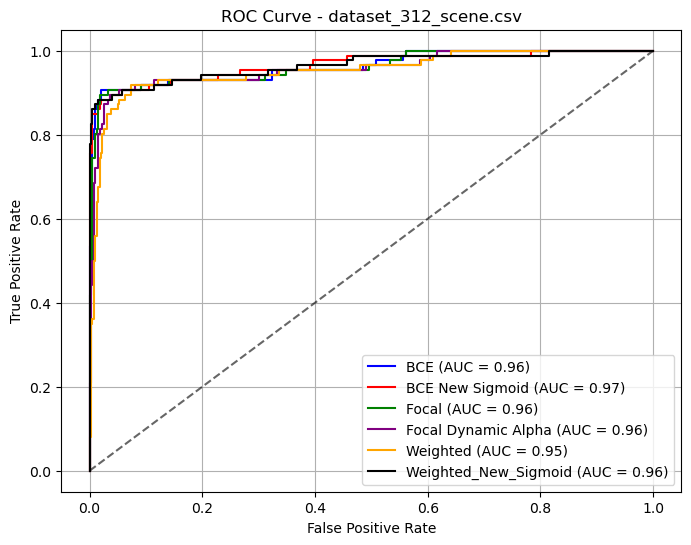

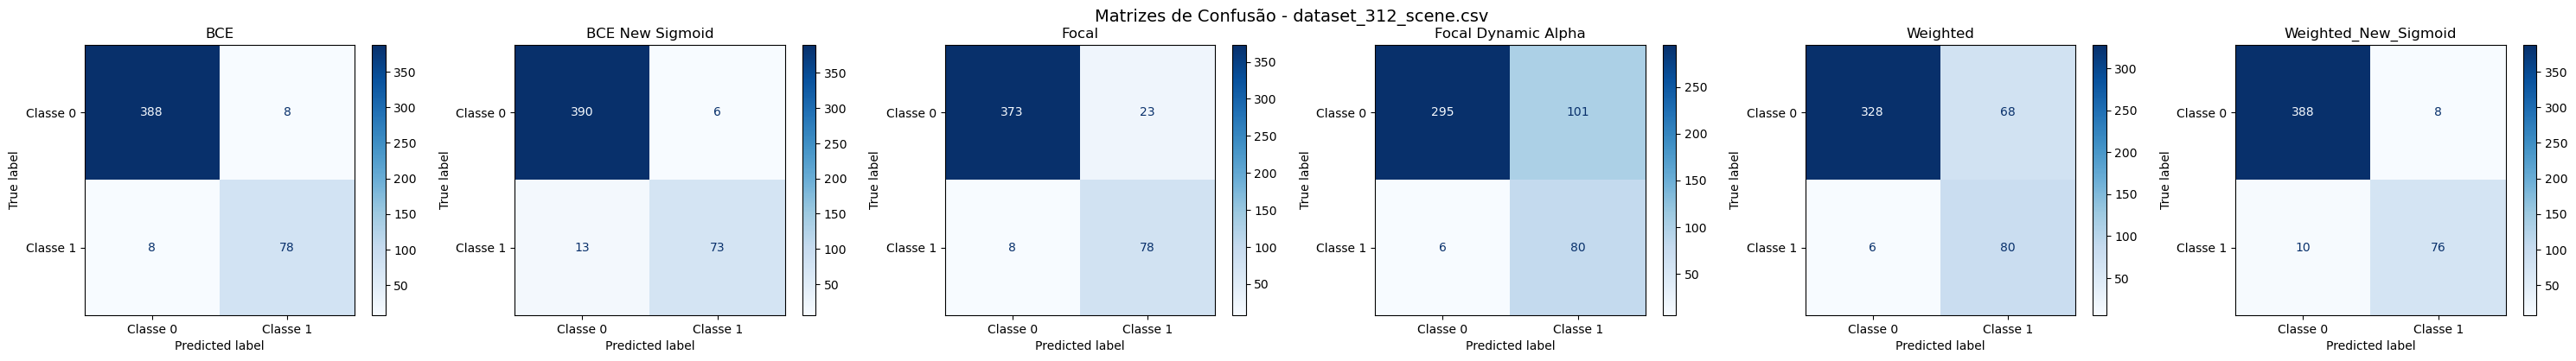


📁 Processando: dataset_947_arsenic-male-bladder.csv
Convergência alcançada em 567 iterações.
Convergência alcançada em 537 iterações.
Convergência alcançada em 327 iterações.


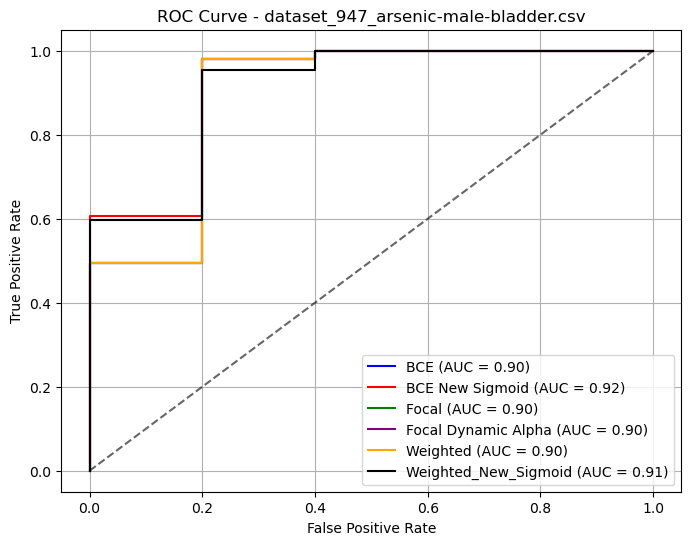

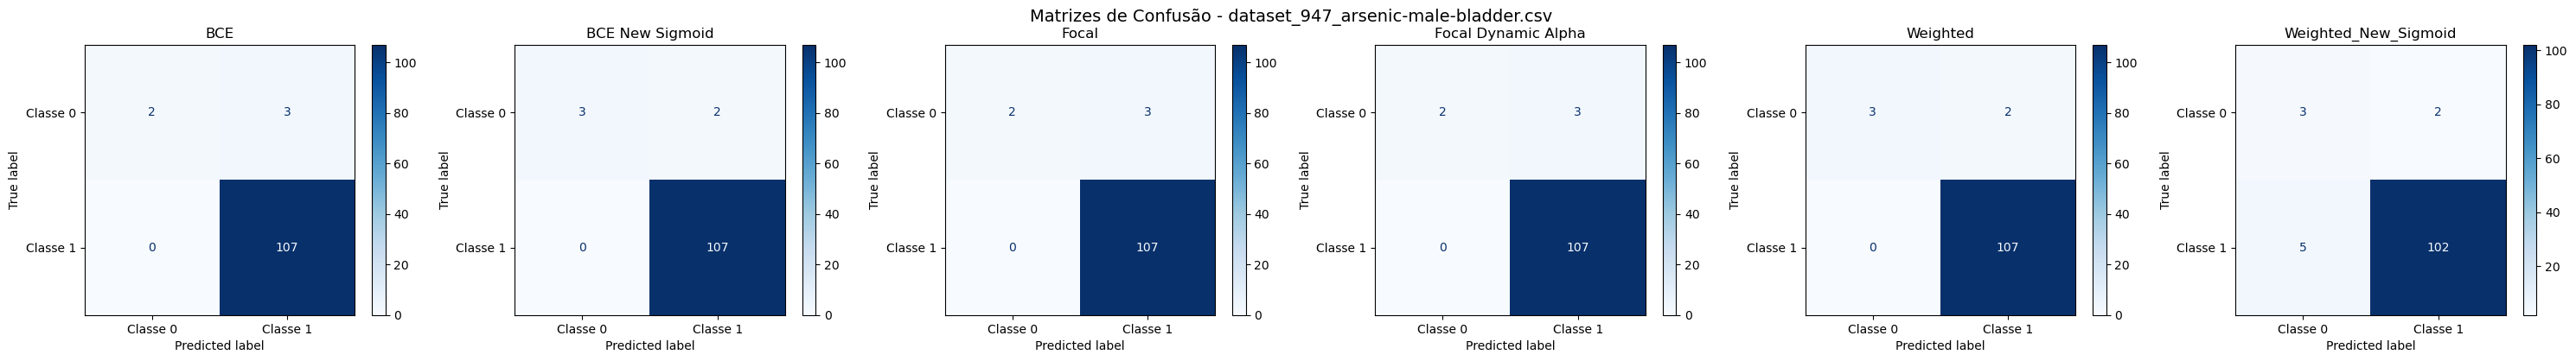


📁 Processando: dataset_1022_mfeat-pixel.csv
Convergência alcançada em 374 iterações.
Convergência alcançada em 402 iterações.


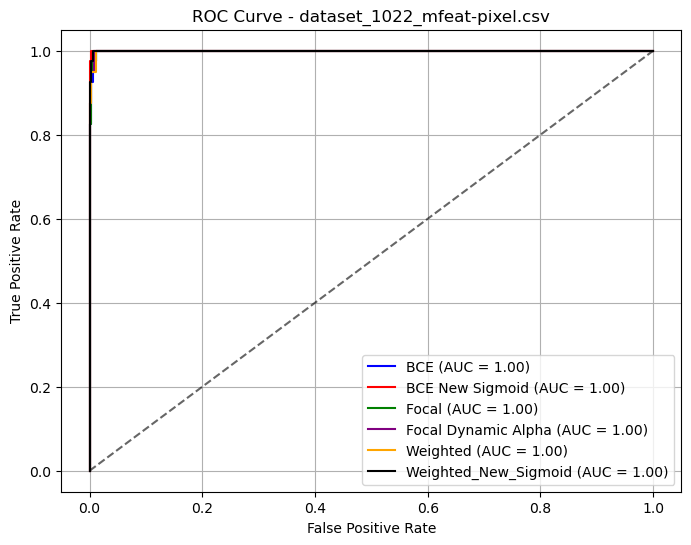

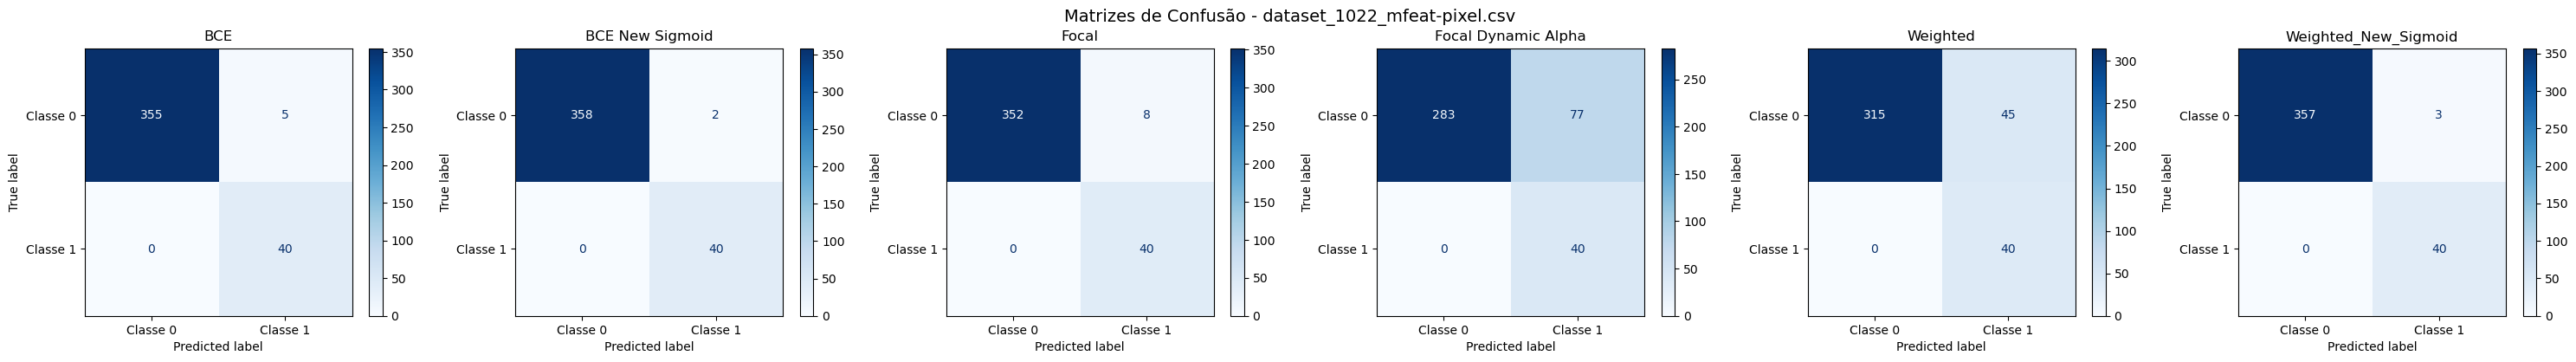


📁 Processando: dataset_463_backache.csv
Convergência alcançada em 204 iterações.


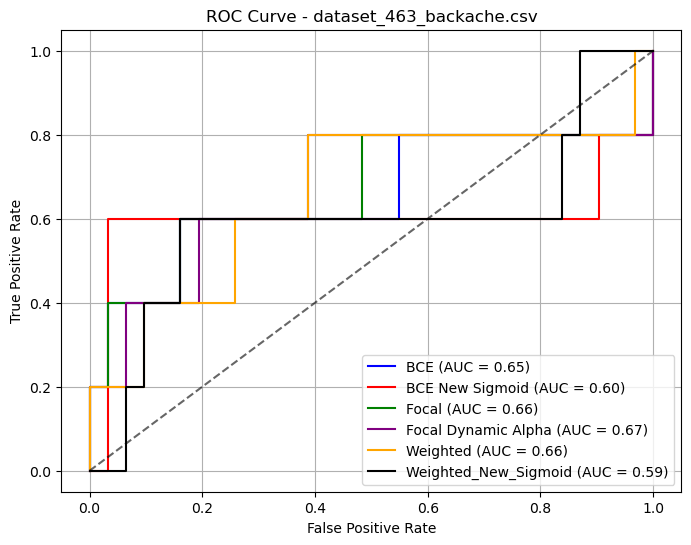

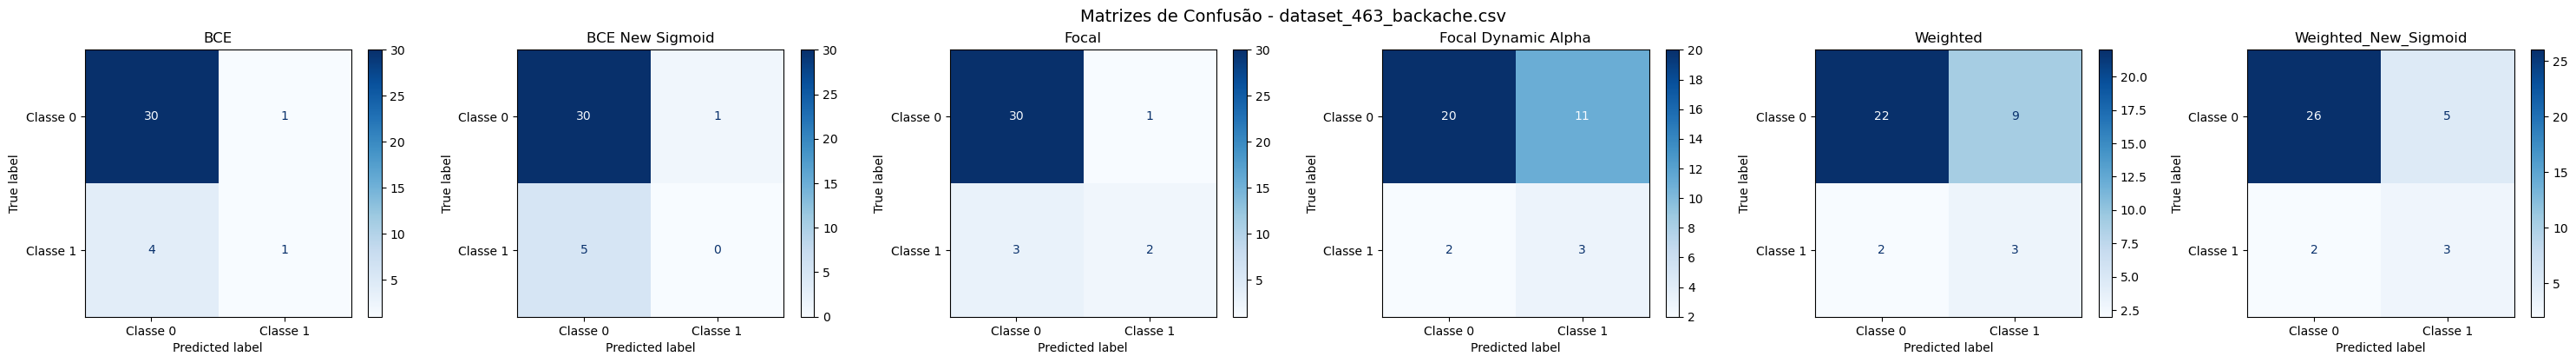


📁 Processando: dataset_1039_hiva_agnostic.csv


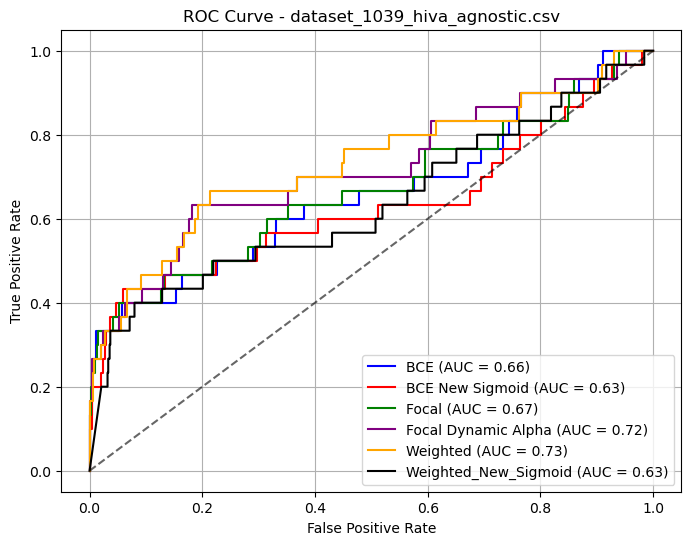

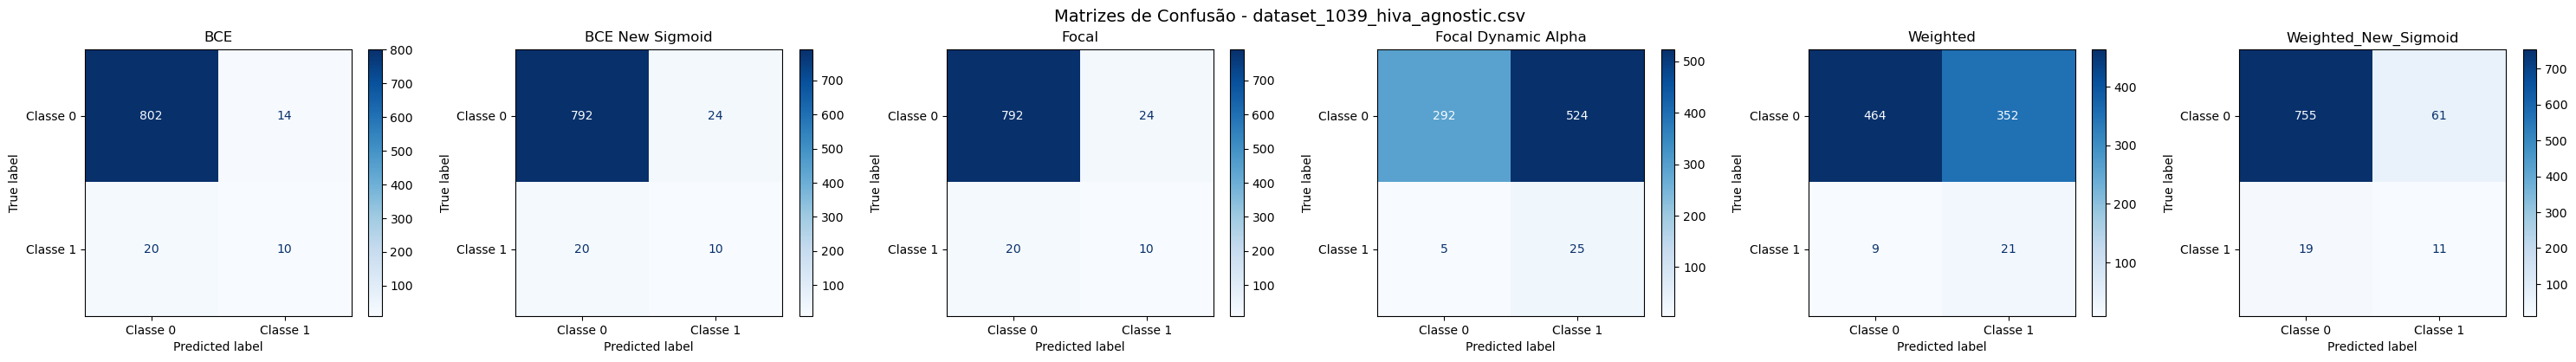


📁 Processando: dataset_954_spectrometer.csv


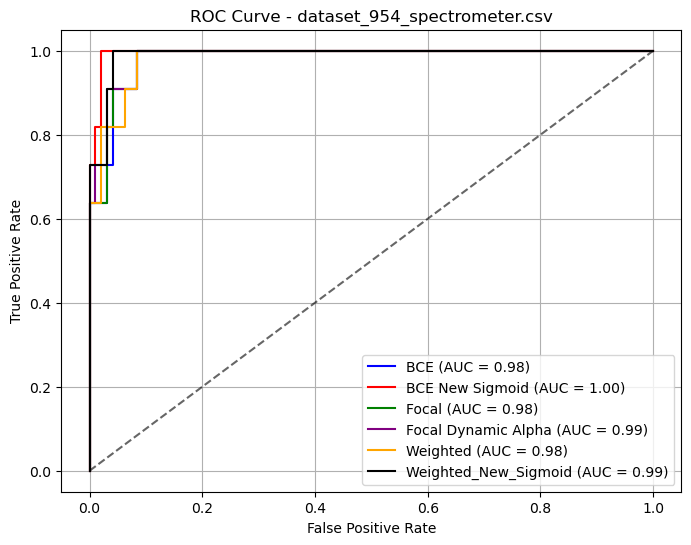

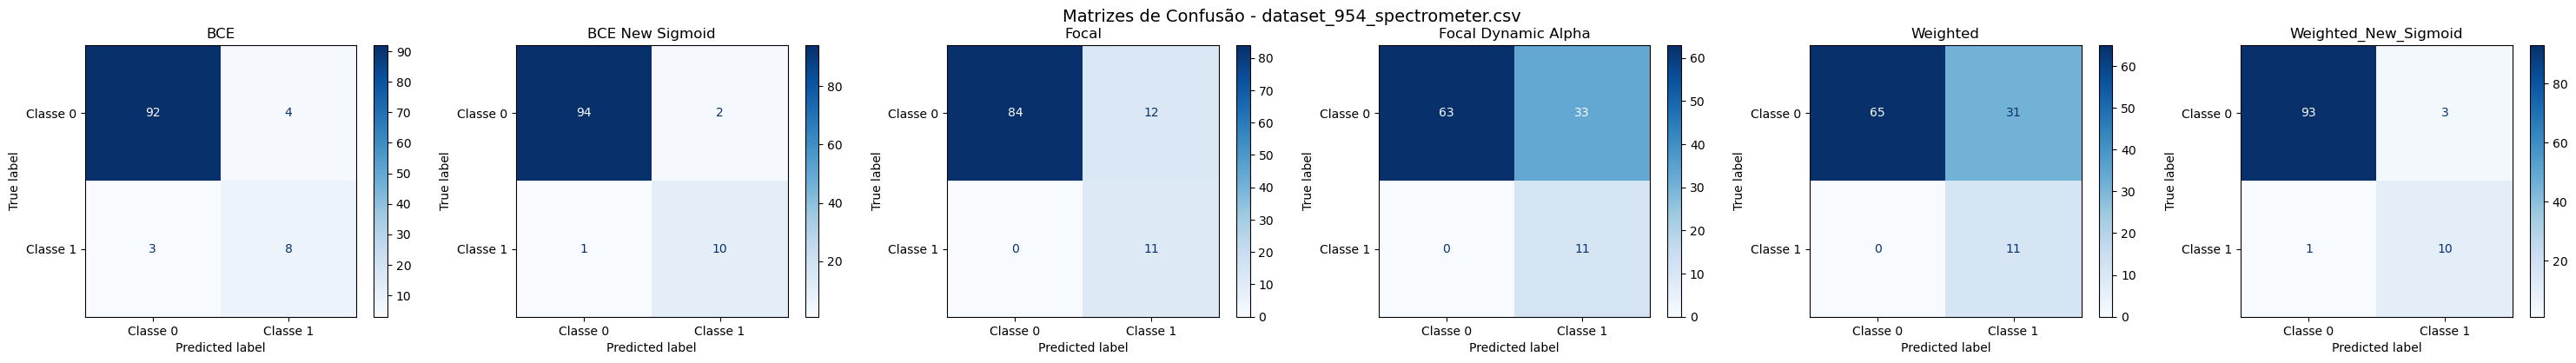


📁 Processando: dataset_950_arsenic-female-lung.csv
Convergência alcançada em 626 iterações.
Convergência alcançada em 565 iterações.
Convergência alcançada em 221 iterações.


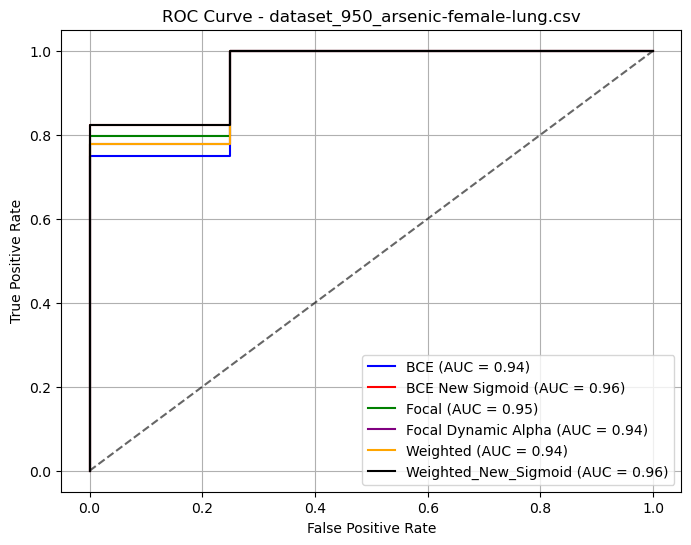

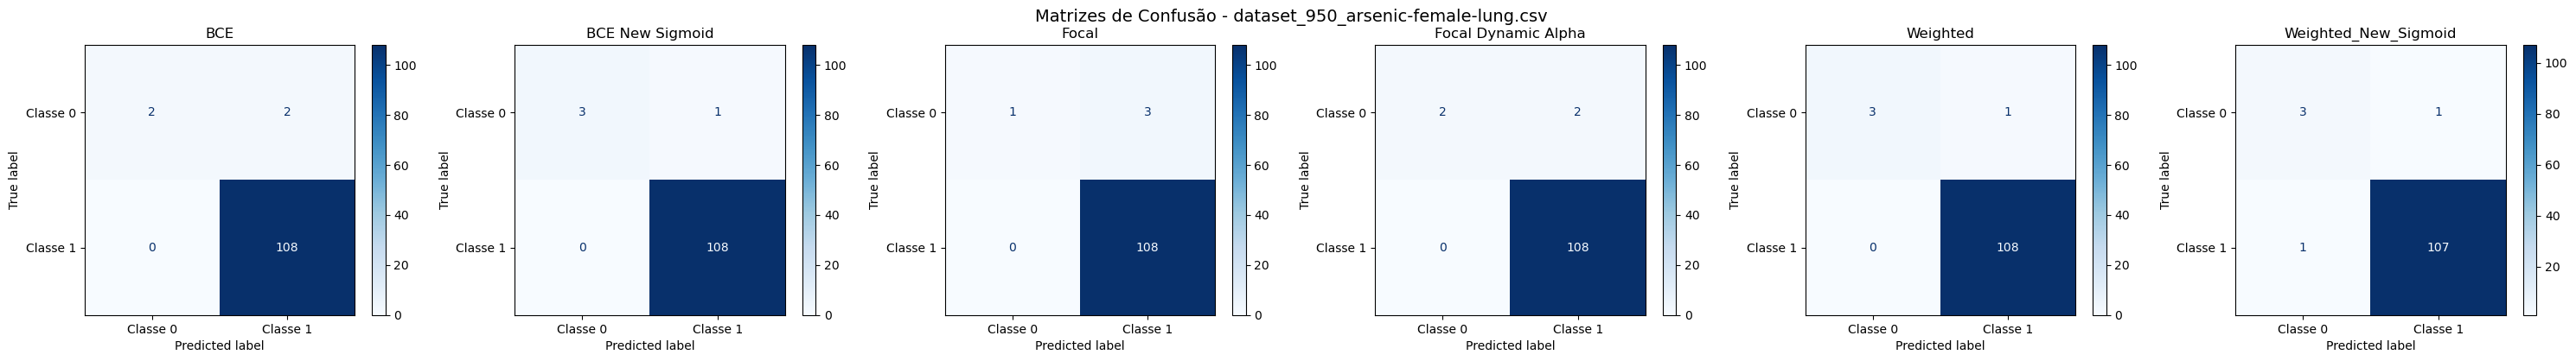


📁 Processando: dataset_764_analcatdata_apnea3.csv
Convergência alcançada em 678 iterações.
Convergência alcançada em 9 iterações.
Convergência alcançada em 506 iterações.
Convergência alcançada em 180 iterações.
Convergência alcançada em 447 iterações.
Convergência alcançada em 6 iterações.


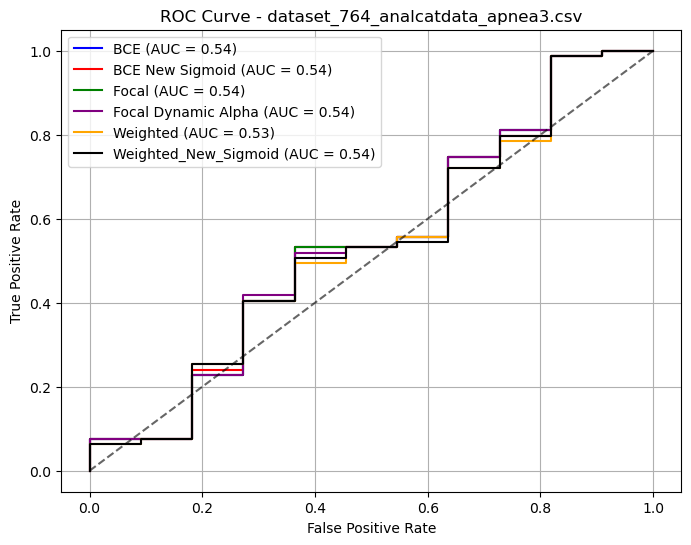

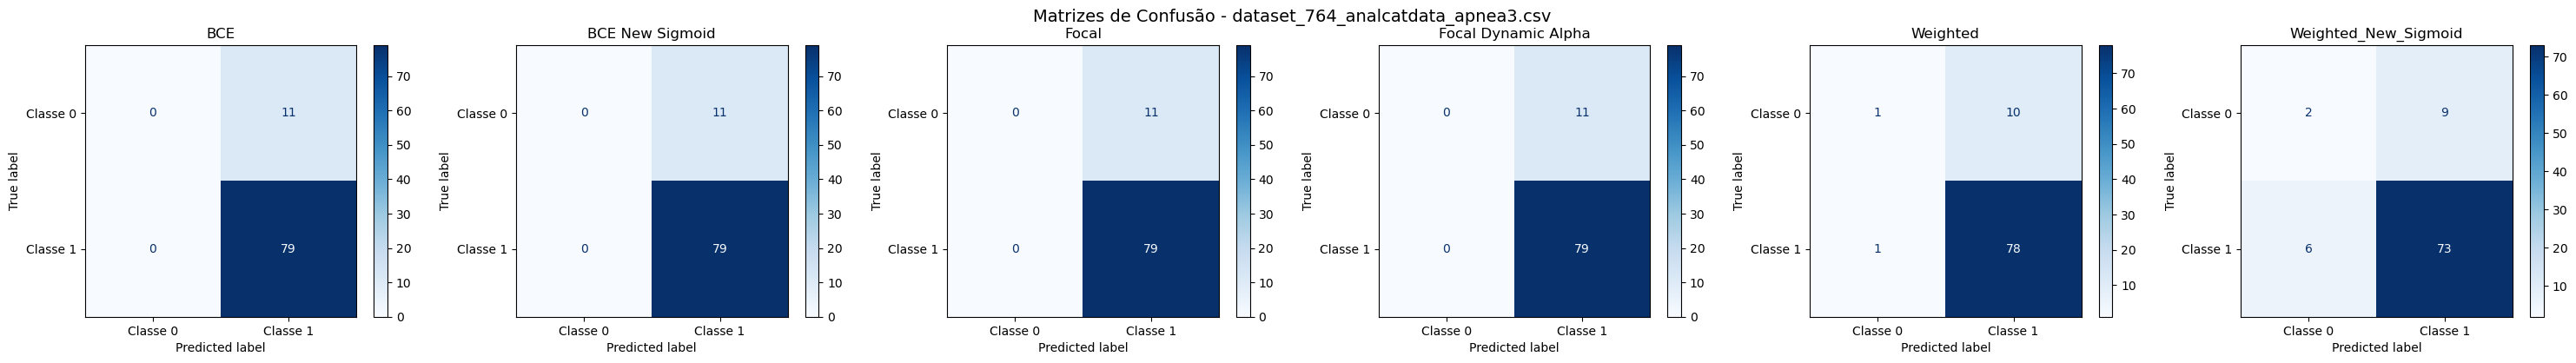


📁 Processando: dataset_962_mfeat-morphological.csv
Convergência alcançada em 827 iterações.
Convergência alcançada em 913 iterações.


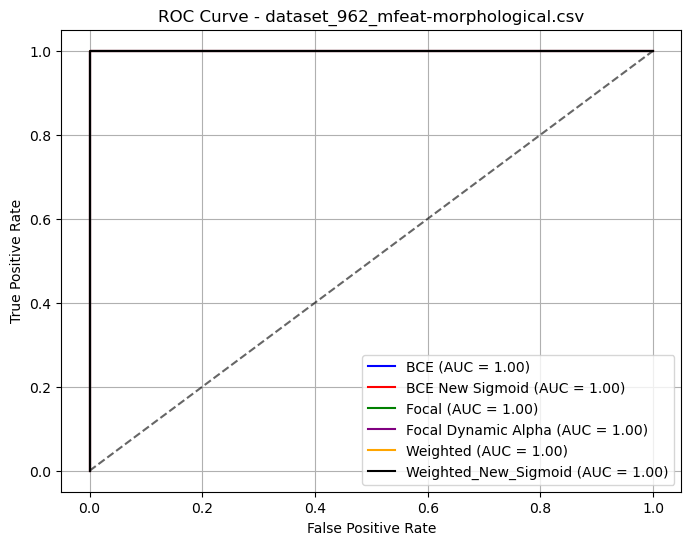

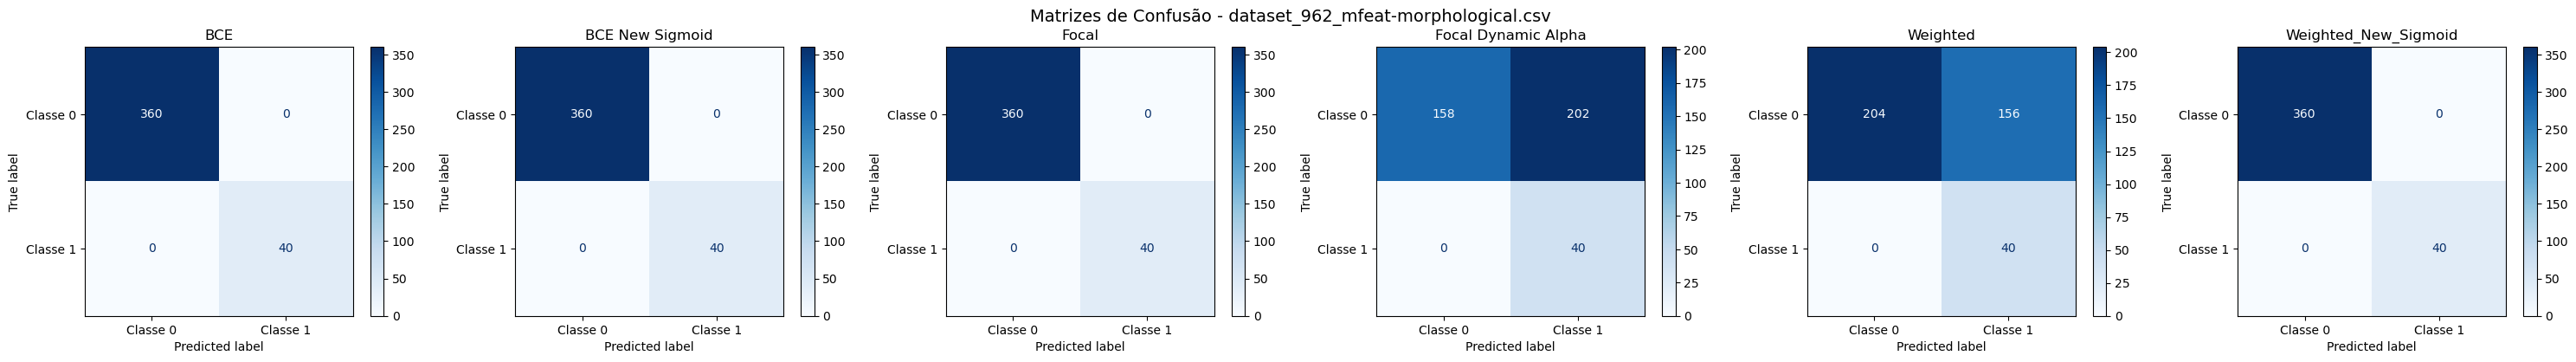


📁 Processando: dataset_966_analcatdata_halloffame.csv


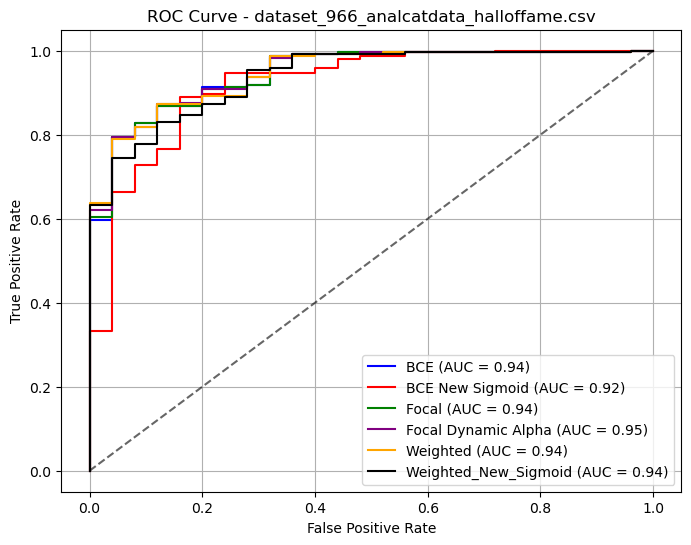

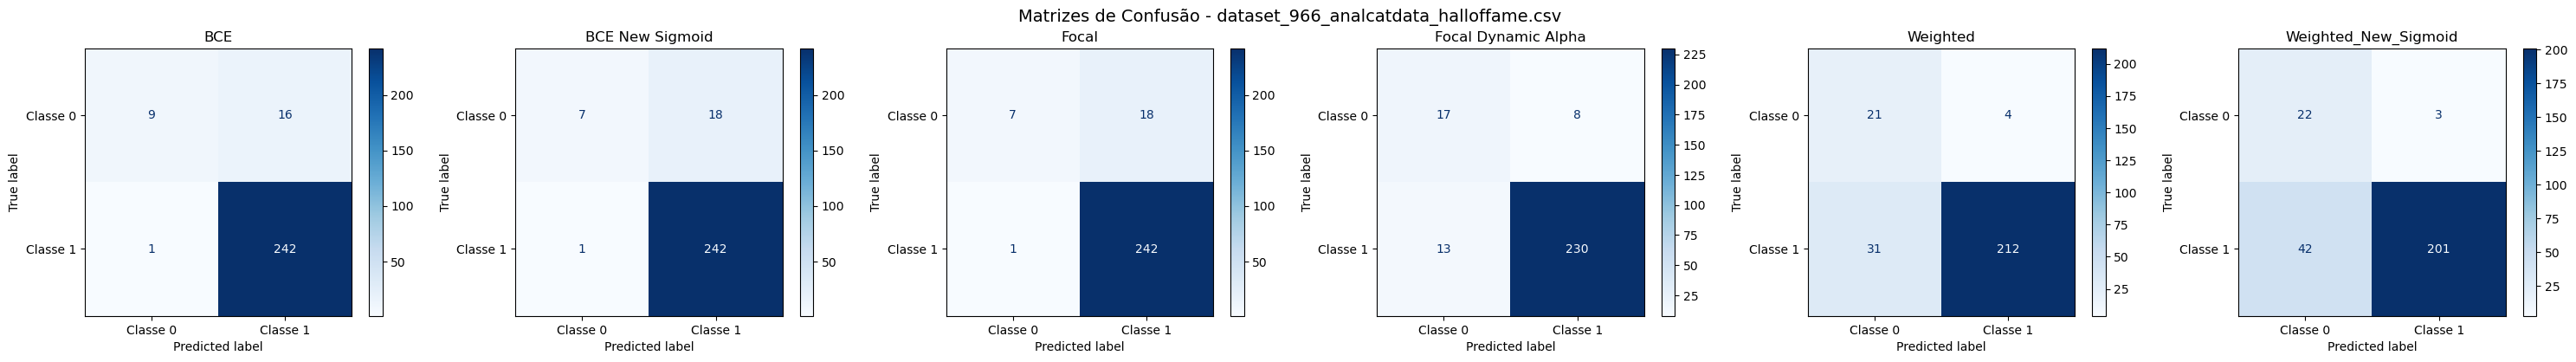


📁 Processando: dataset_38_sick.csv


/tmp/ipykernel_6785/3329694420.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({"t": 1, "f": 0, "M": 1, "F": 0}, inplace=True)


Convergência alcançada em 277 iterações.
Convergência alcançada em 208 iterações.


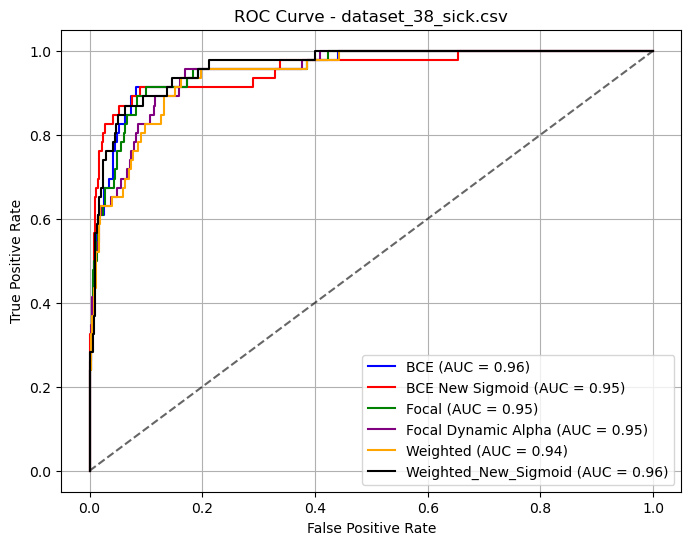

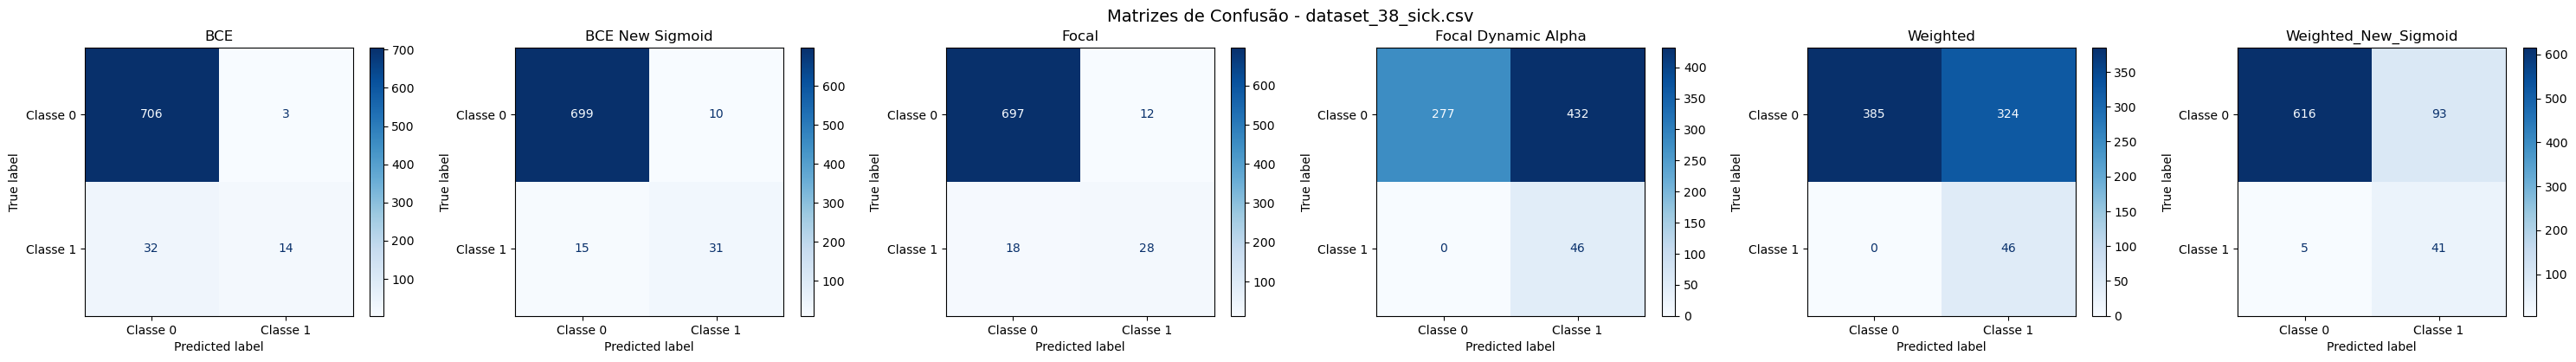


📁 Processando: dataset_968_analcatdata_birthday.csv
Convergência alcançada em 75 iterações.
Convergência alcançada em 61 iterações.


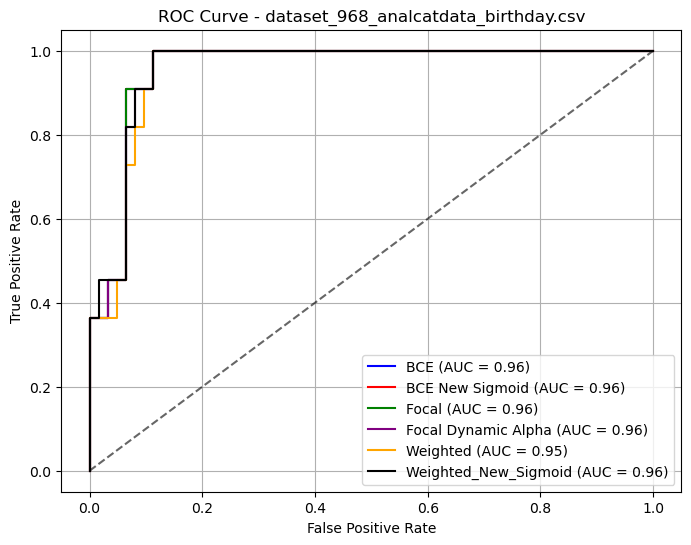

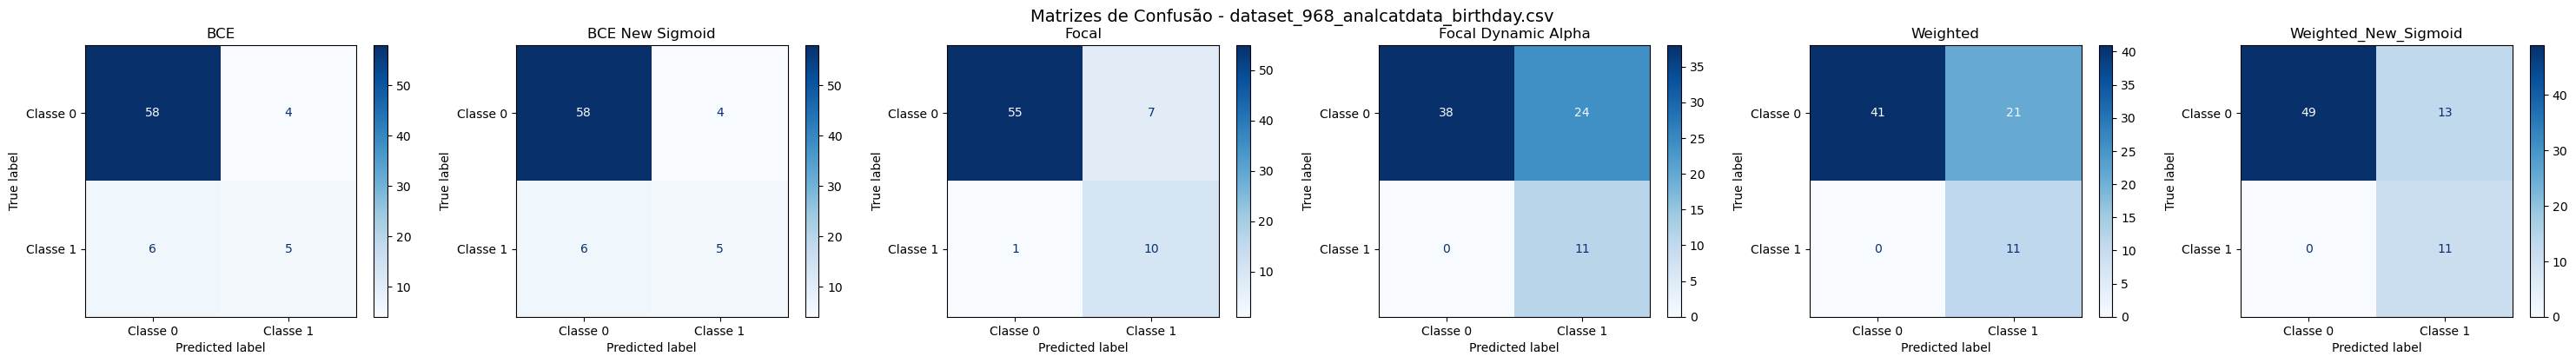


📁 Processando: dataset_1020_mfeat-karhunen.csv


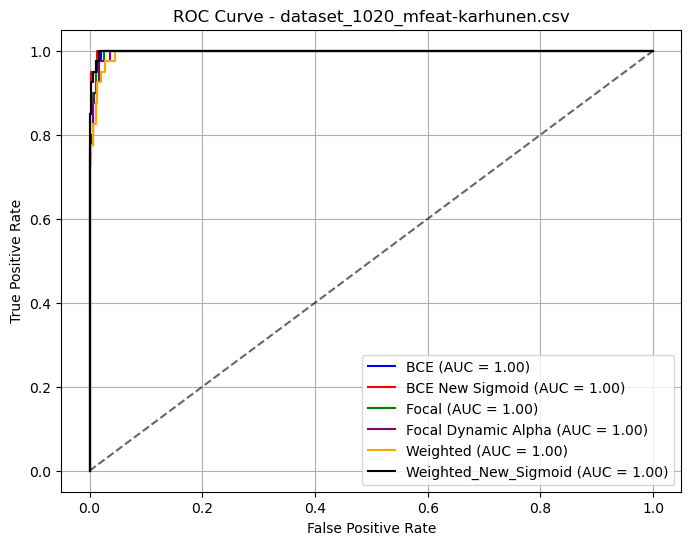

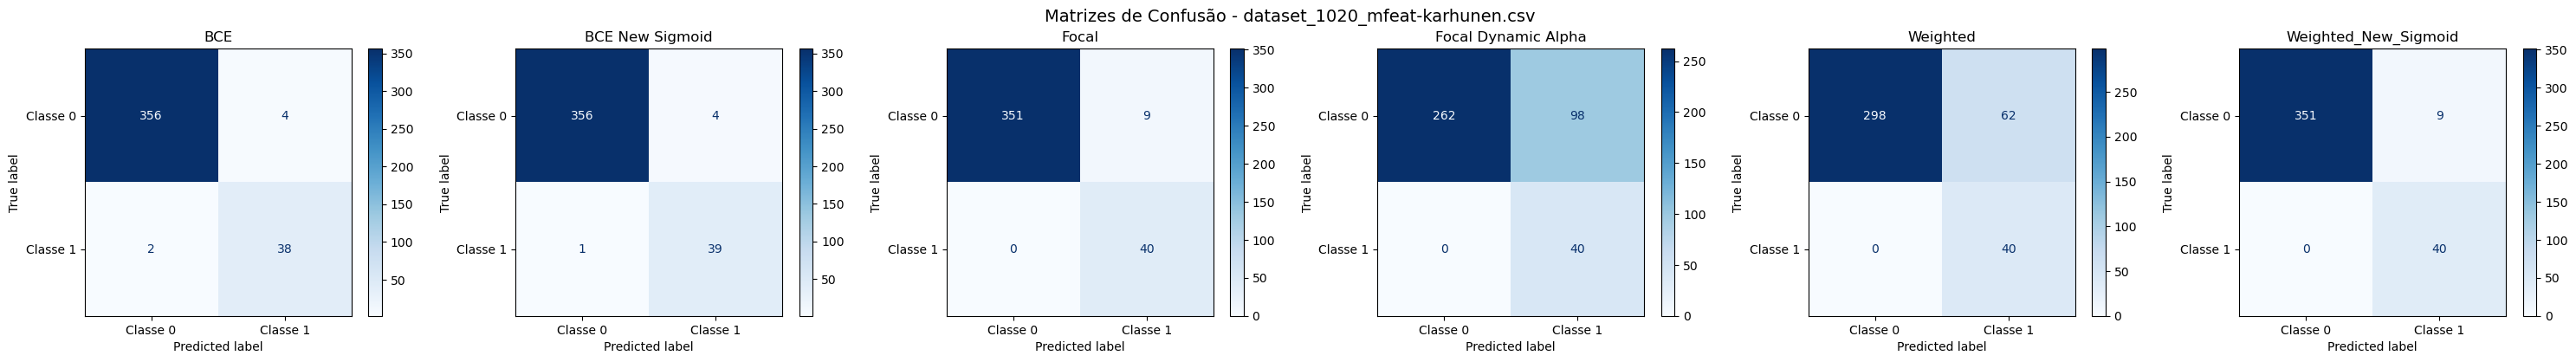


📁 Processando: dataset_1065_kc3.csv
Convergência alcançada em 810 iterações.


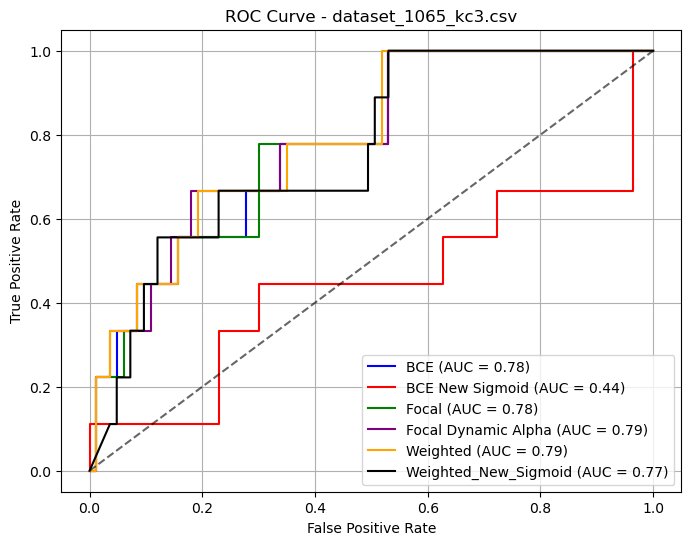

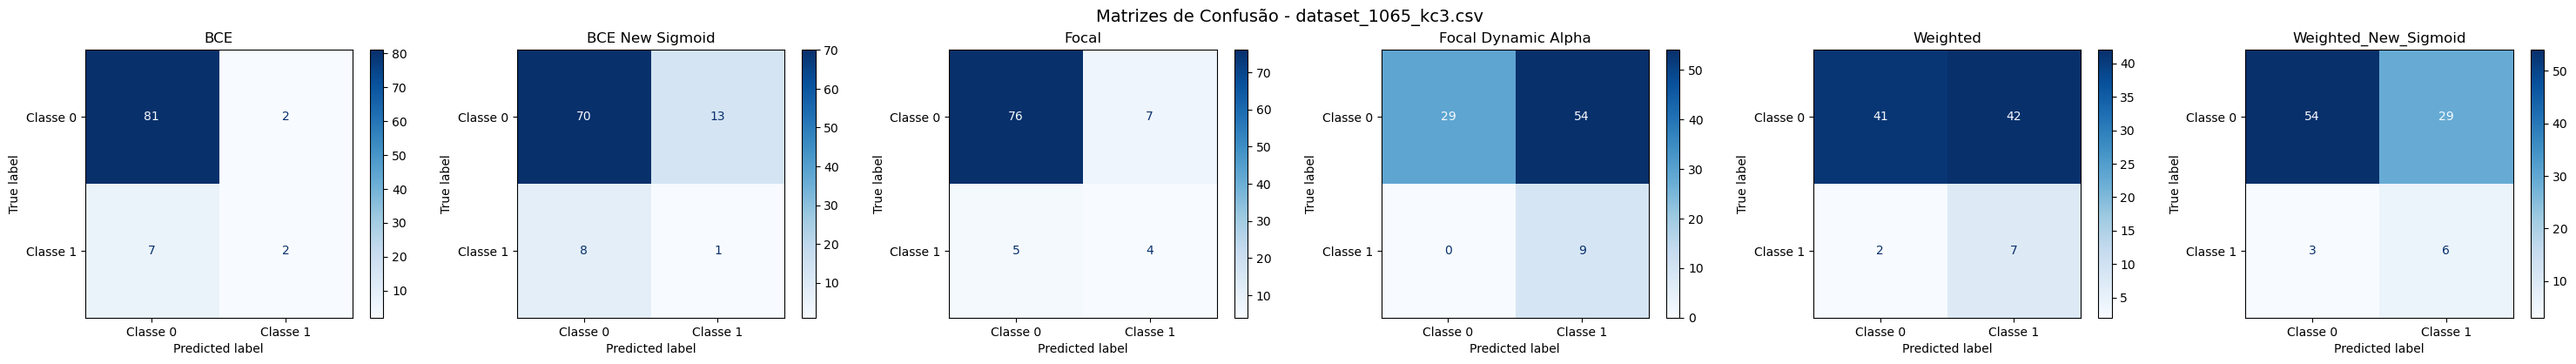


📁 Processando: dataset_1050_pc3.csv
Convergência alcançada em 817 iterações.
Convergência alcançada em 559 iterações.


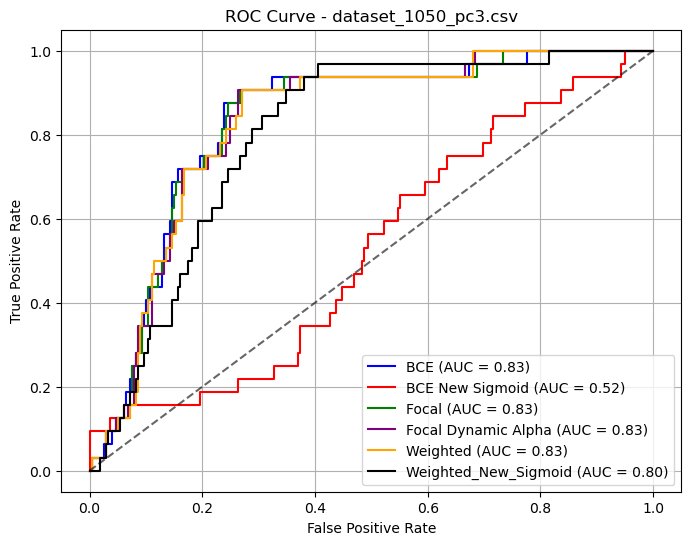

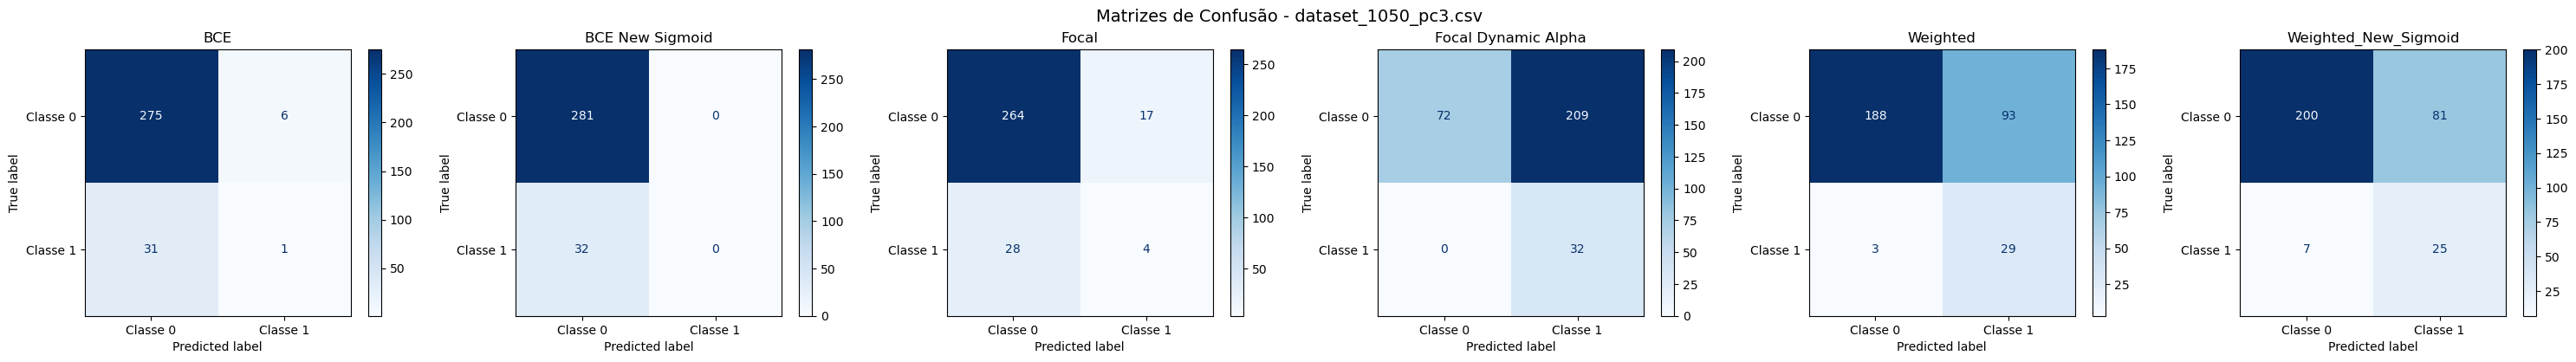


📁 Processando: dataset_765_analcatdata_apnea2.csv
Convergência alcançada em 614 iterações.
Convergência alcançada em 6 iterações.
Convergência alcançada em 471 iterações.
Convergência alcançada em 181 iterações.
Convergência alcançada em 424 iterações.
Convergência alcançada em 5 iterações.


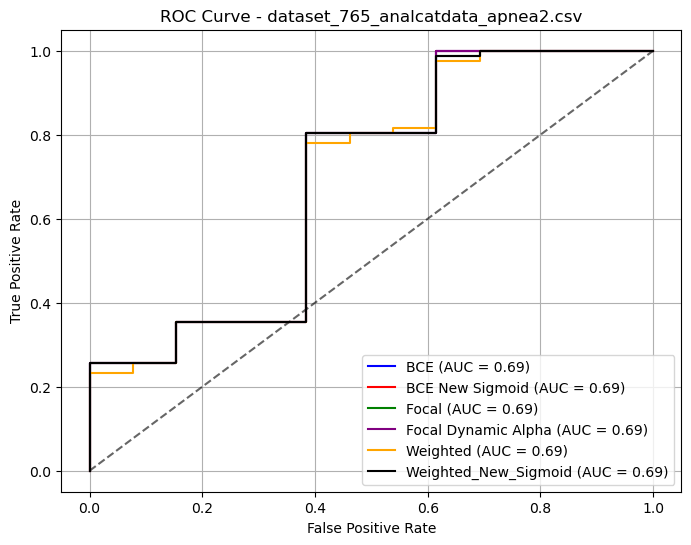

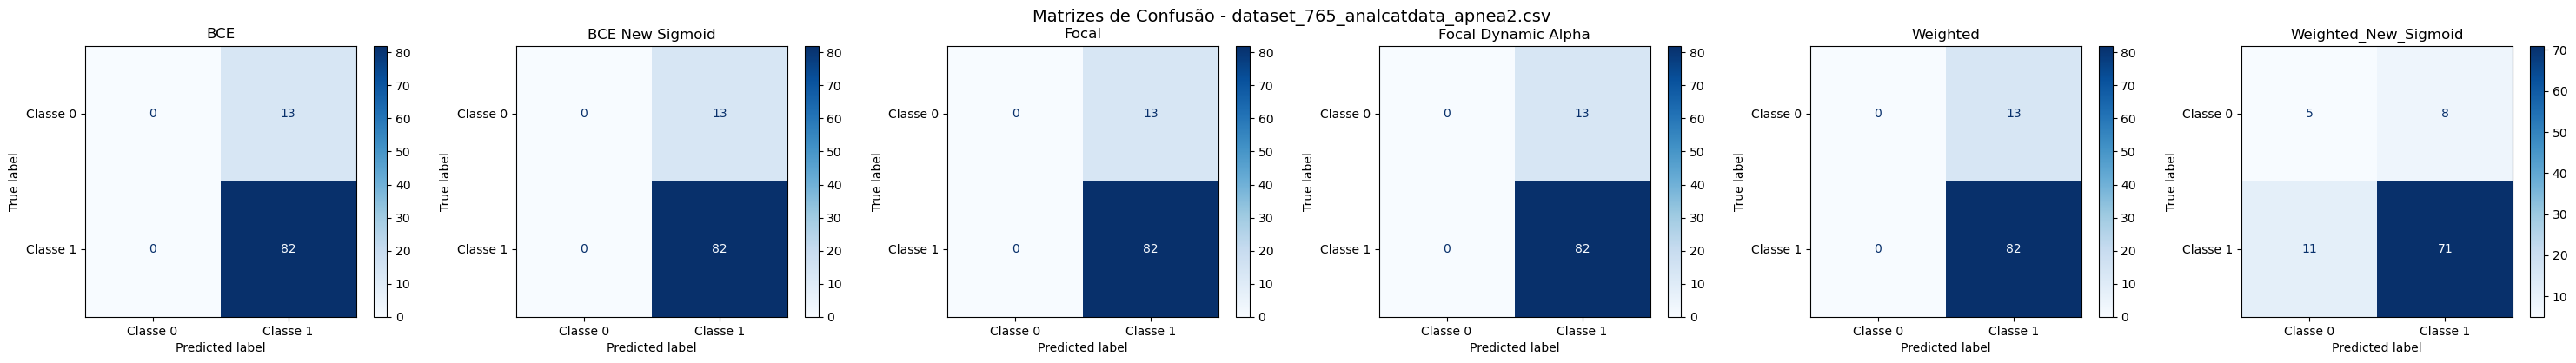


📁 Processando: dataset_958_segment.csv


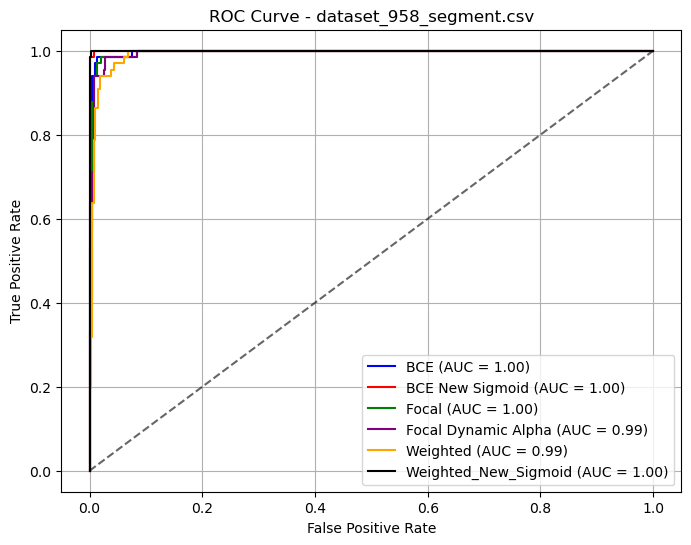

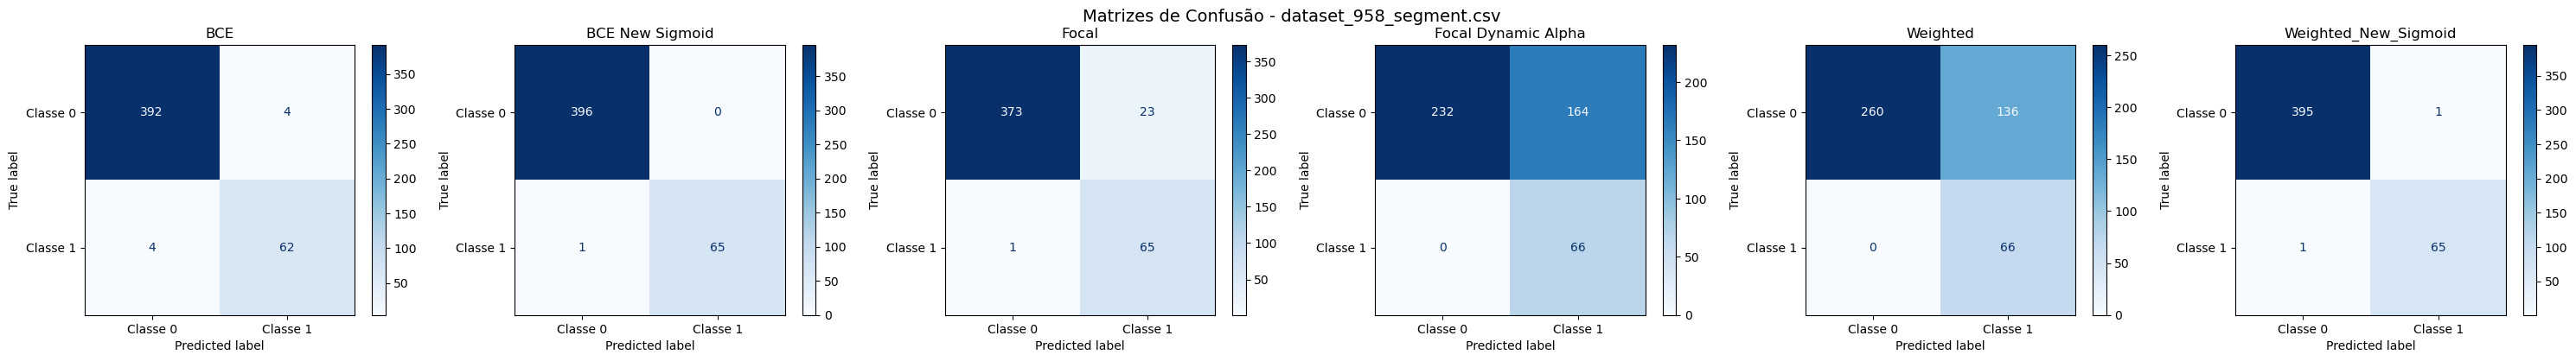


📁 Processando: dataset_987_collins.csv


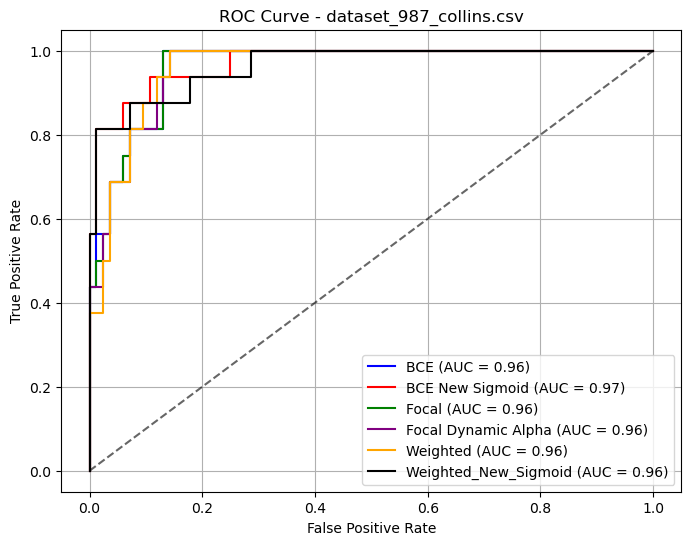

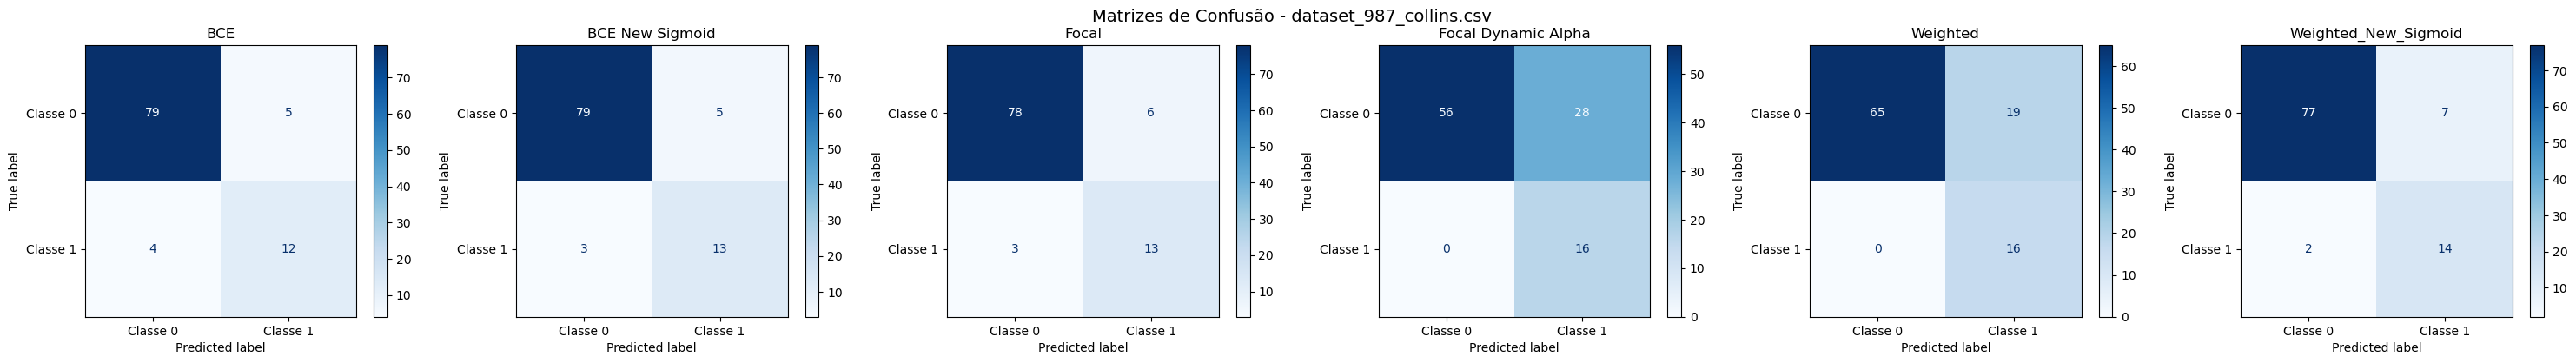


📁 Processando: dataset_1013_analcatdata_challenger.csv
Convergência alcançada em 24 iterações.
Convergência alcançada em 813 iterações.
Convergência alcançada em 441 iterações.
Convergência alcançada em 908 iterações.
Convergência alcançada em 7 iterações.


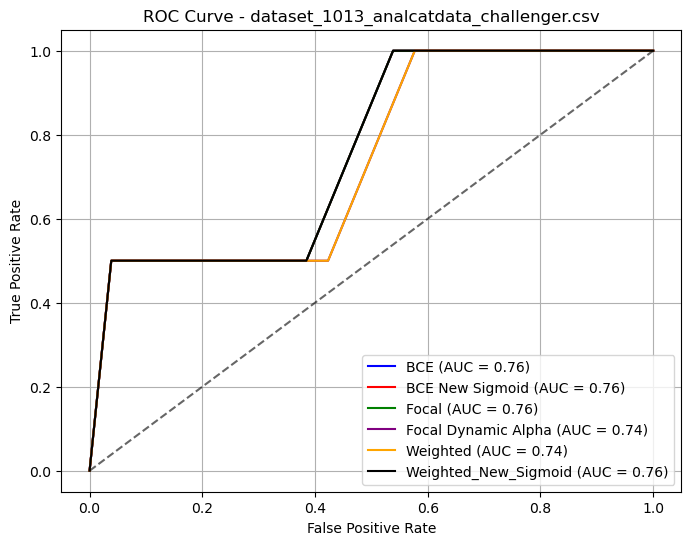

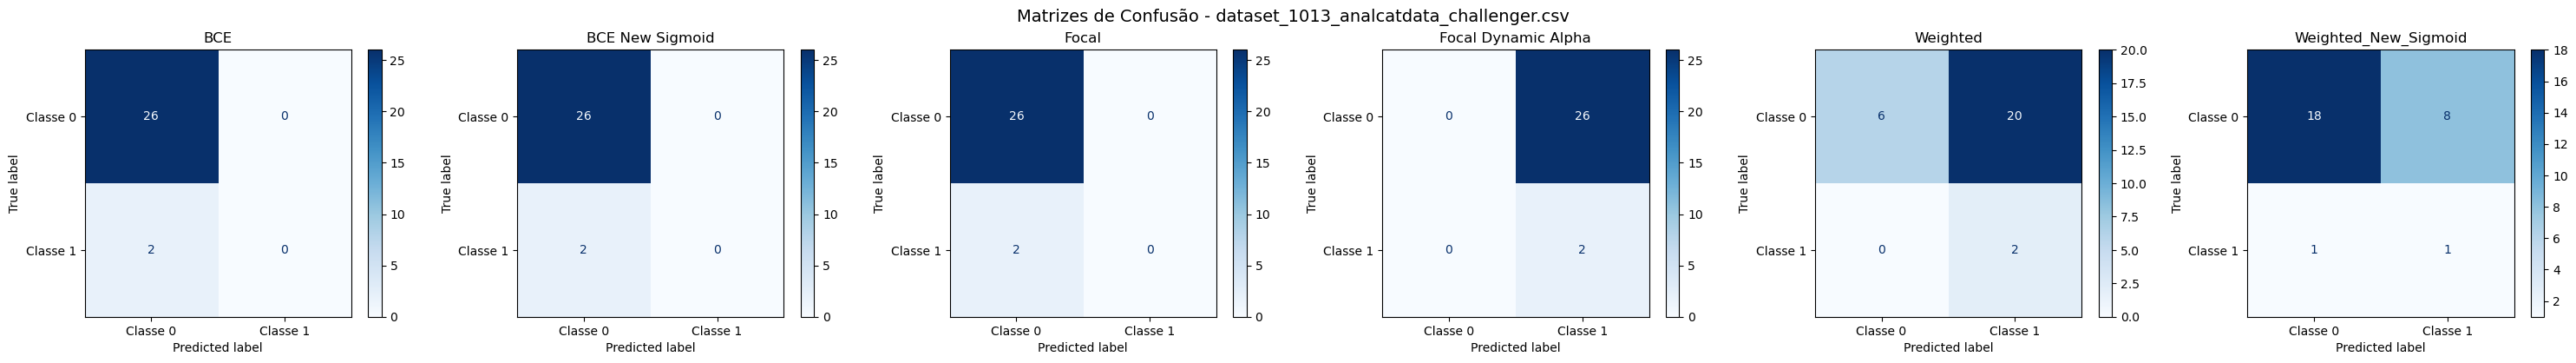


📁 Processando: dataset_450_analcatdata_lawsuit.csv


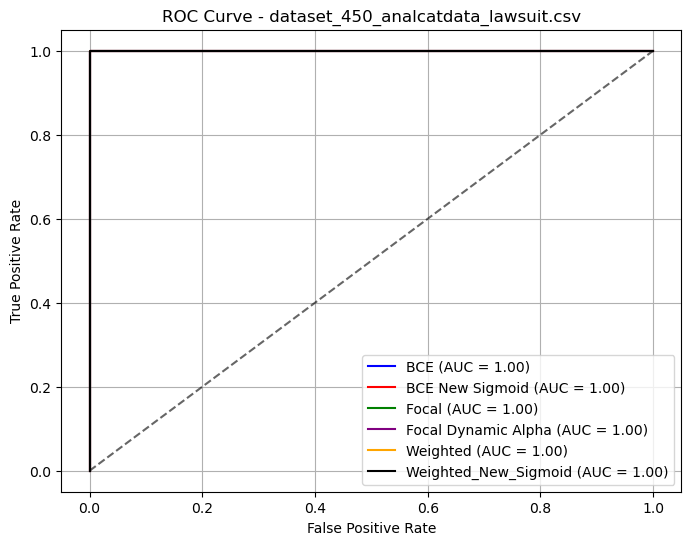

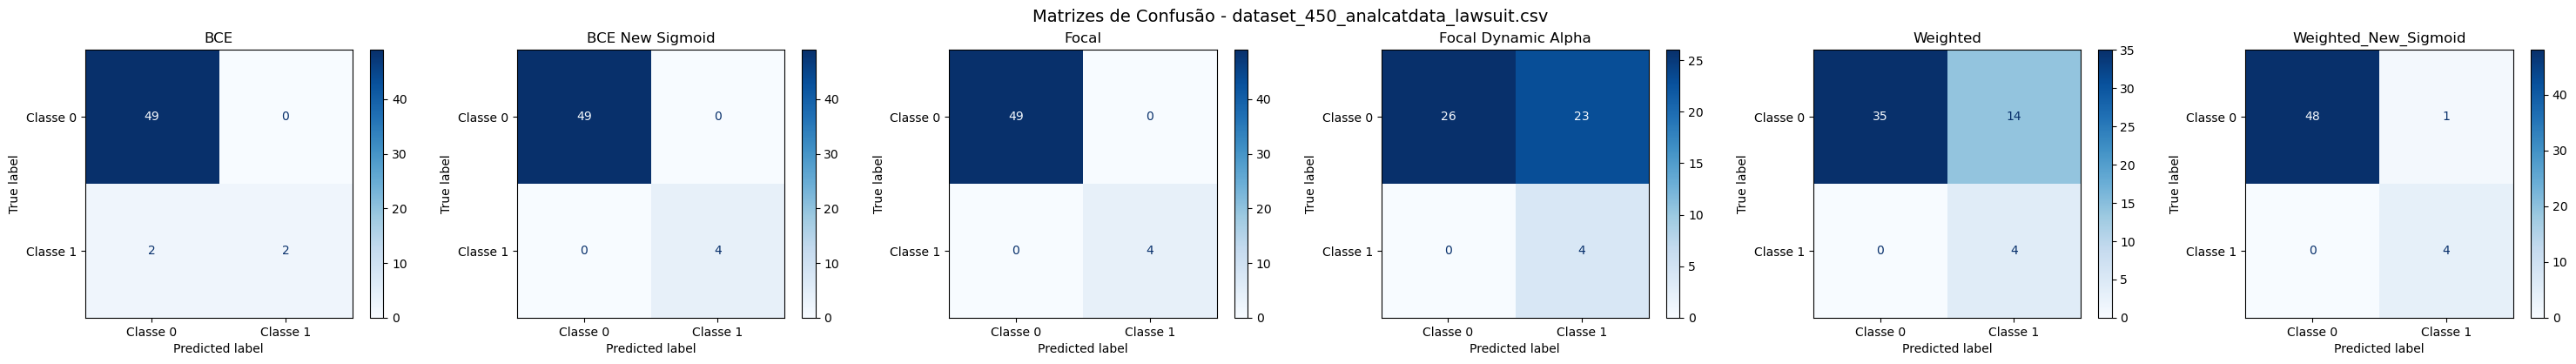


📁 Processando: dataset_1000_hypothyroid.csv


/tmp/ipykernel_6785/3329694420.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({"t": 1, "f": 0, "M": 1, "F": 0}, inplace=True)


Convergência alcançada em 967 iterações.
Convergência alcançada em 895 iterações.


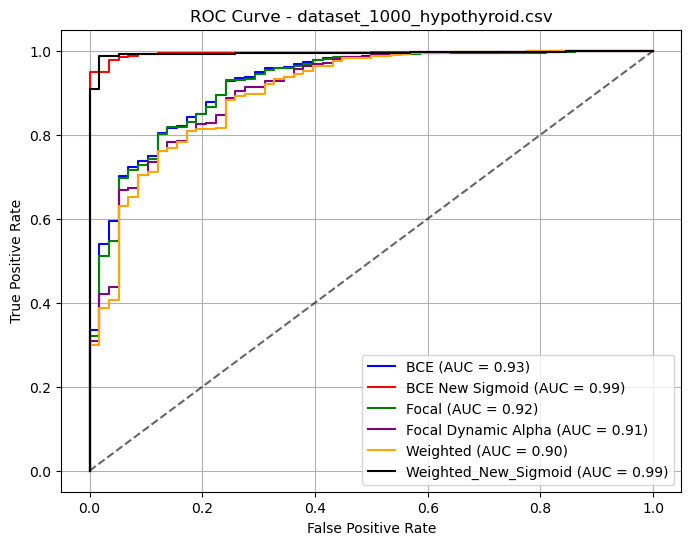

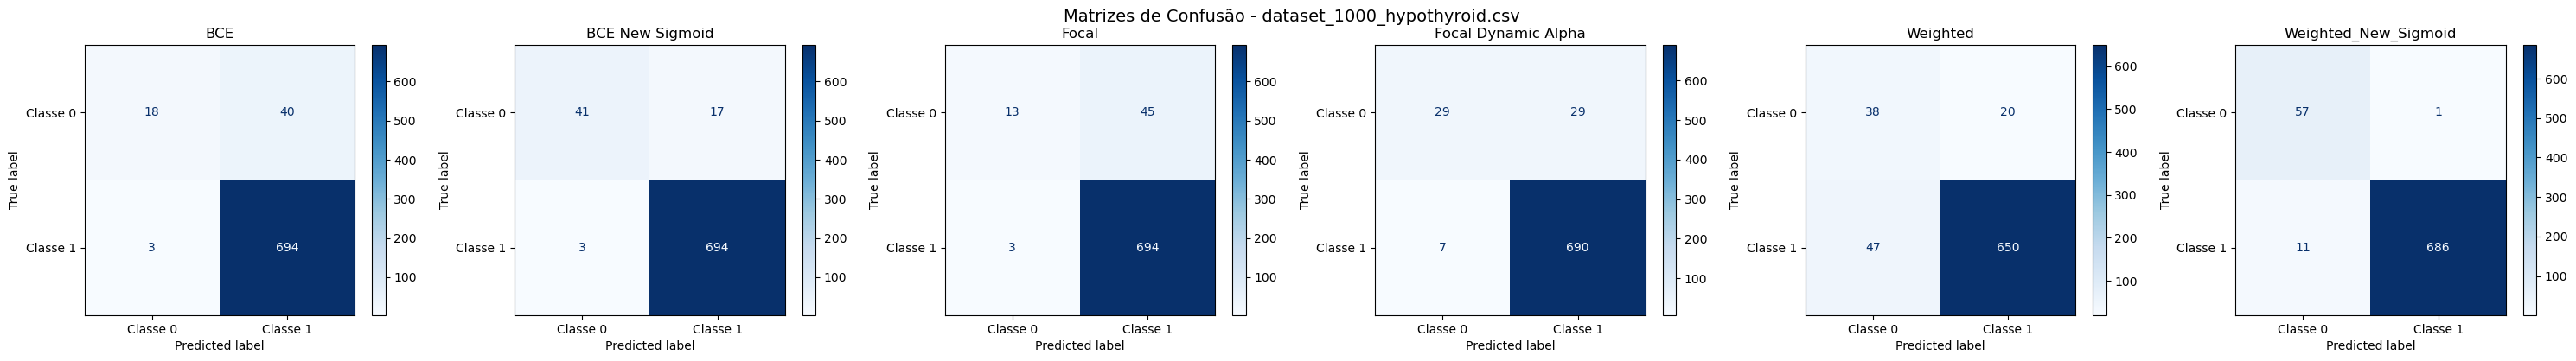


📁 Processando: dataset_951_arsenic-male-lung.csv
Convergência alcançada em 912 iterações.
Convergência alcançada em 612 iterações.


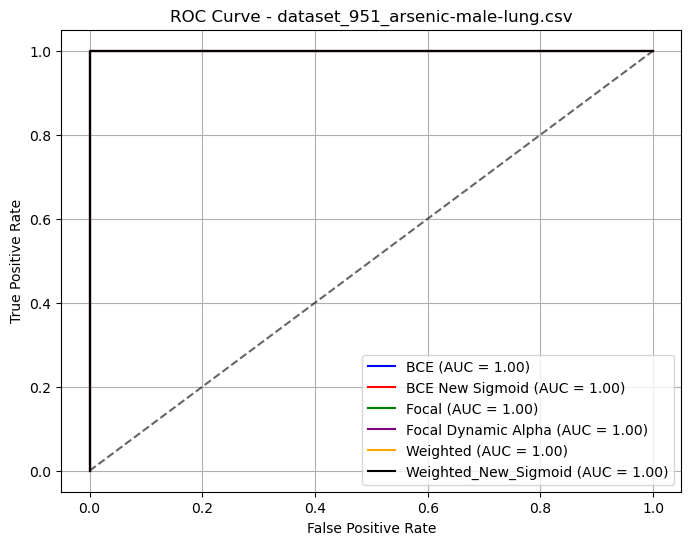

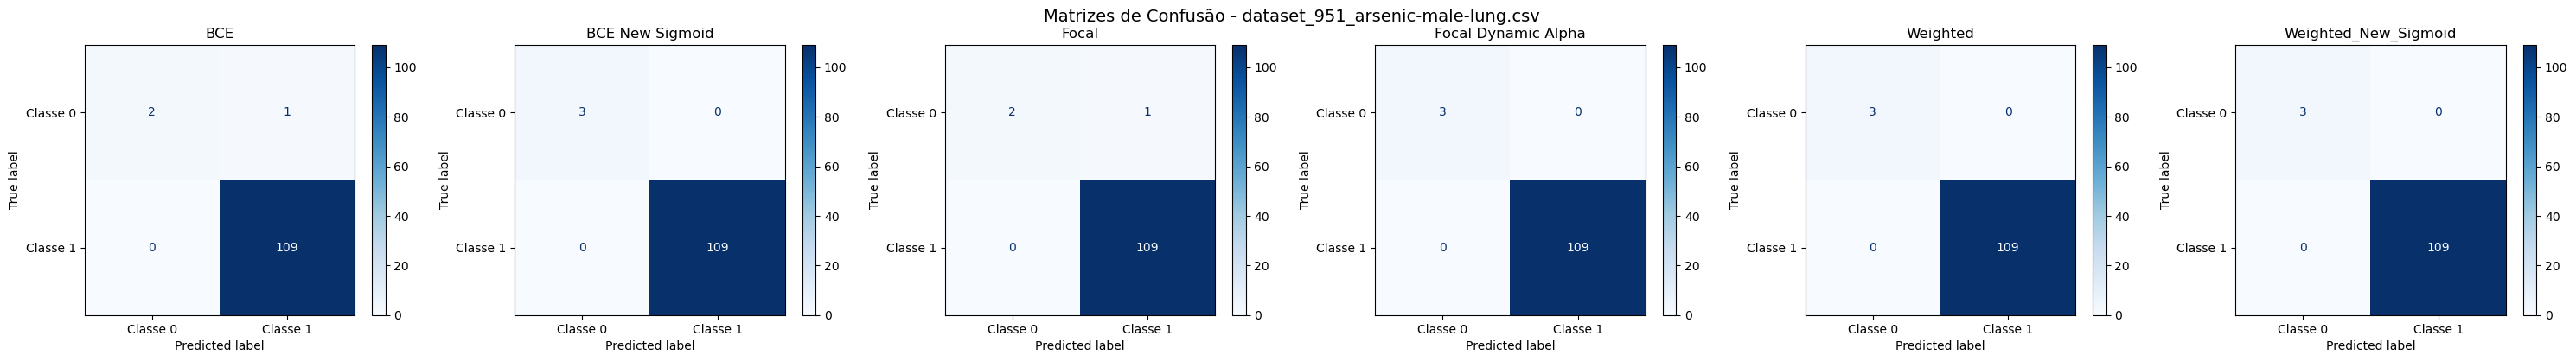


📁 Processando: dataset_311_oil_spill.csv


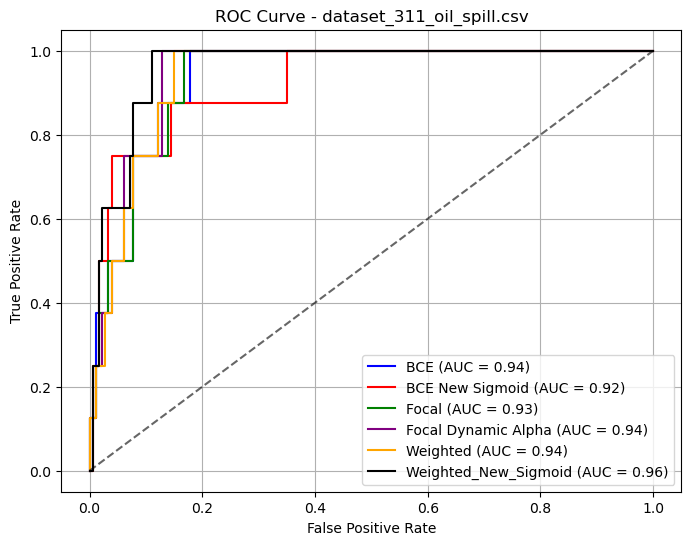

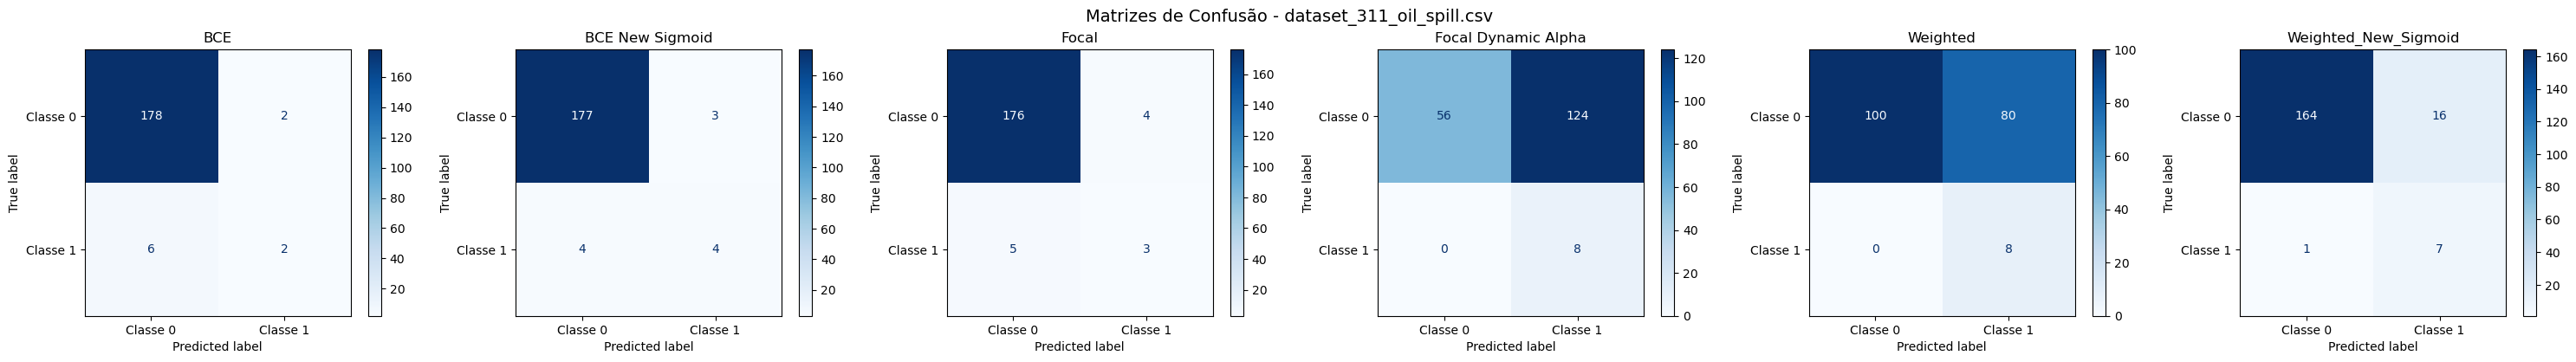


📁 Processando: dataset_1061_ar4.csv


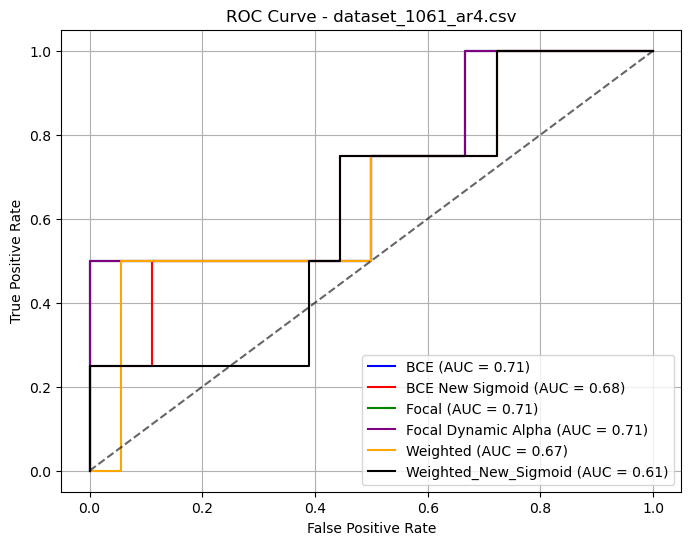

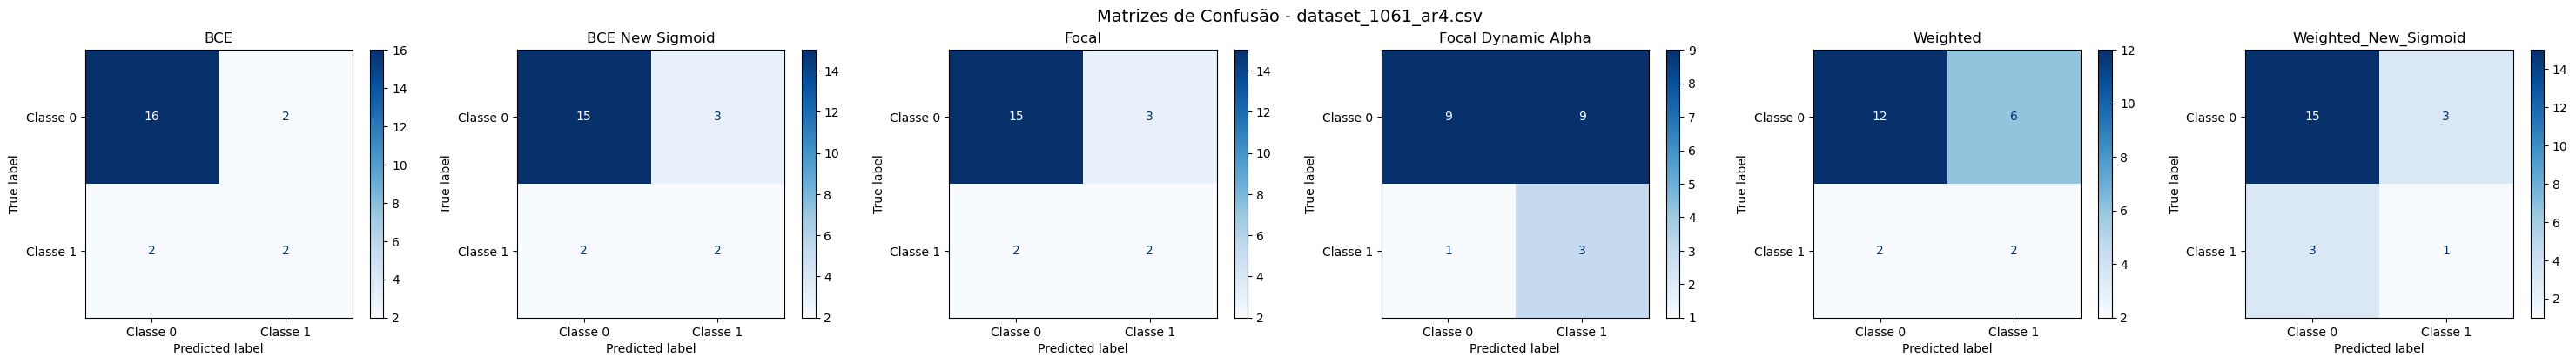


📁 Processando: dataset_949_arsenic-female-bladder.csv
Convergência alcançada em 206 iterações.
Convergência alcançada em 717 iterações.
Convergência alcançada em 618 iterações.
Convergência alcançada em 304 iterações.


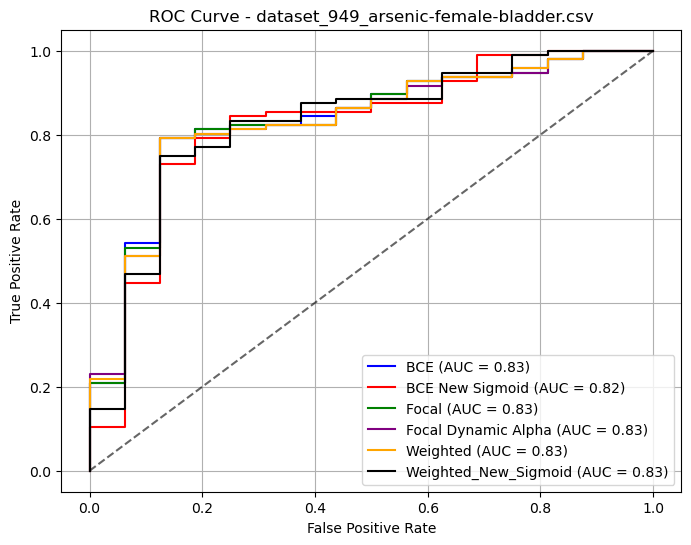

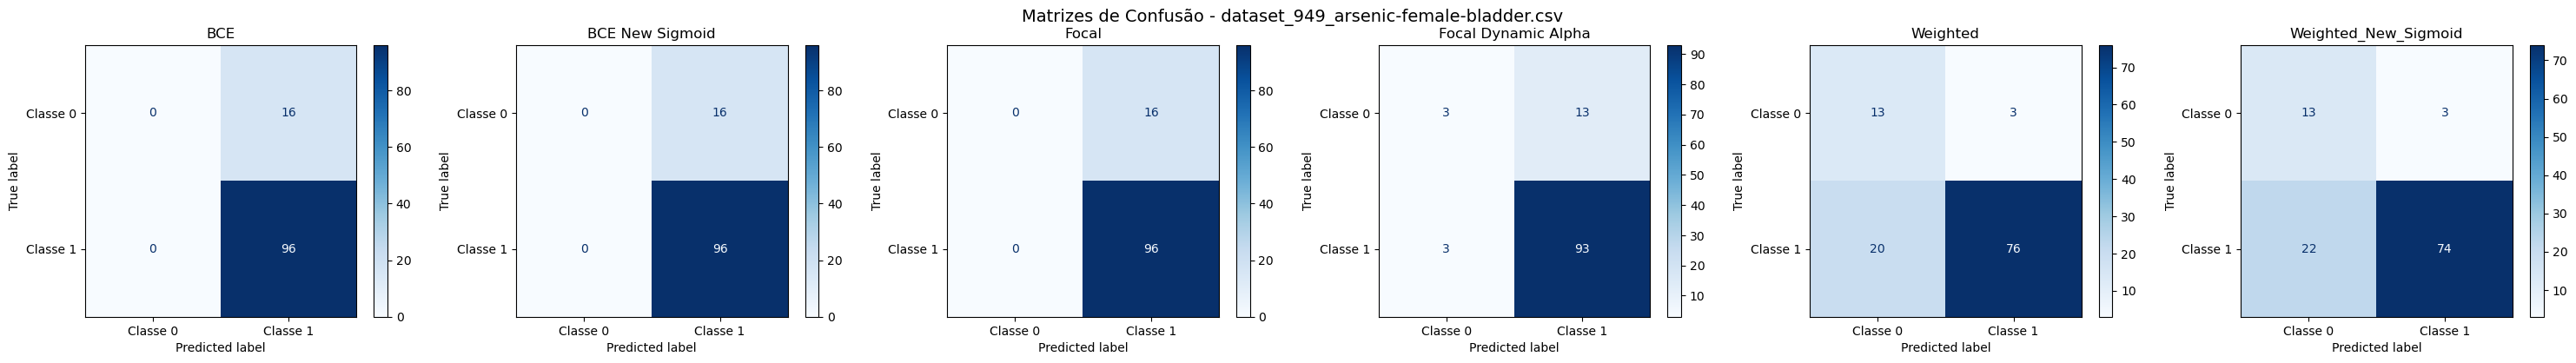


📁 Processando: dataset_865_analcatdata_neavote.csv
Convergência alcançada em 52 iterações.
Convergência alcançada em 709 iterações.
Convergência alcançada em 292 iterações.
Convergência alcançada em 638 iterações.


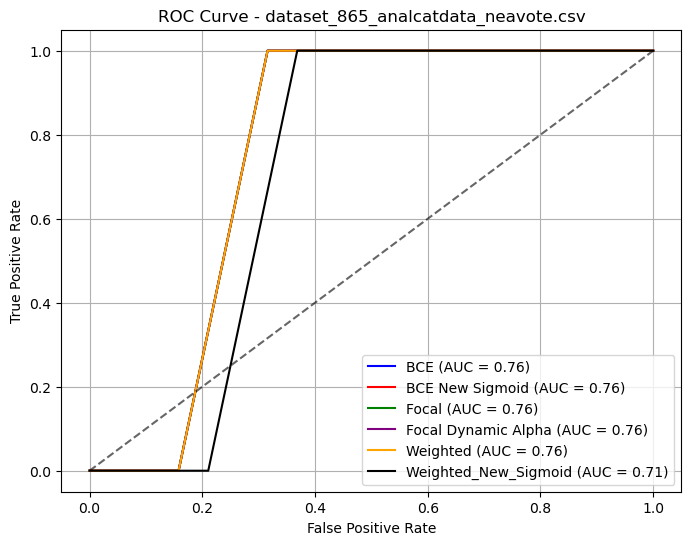

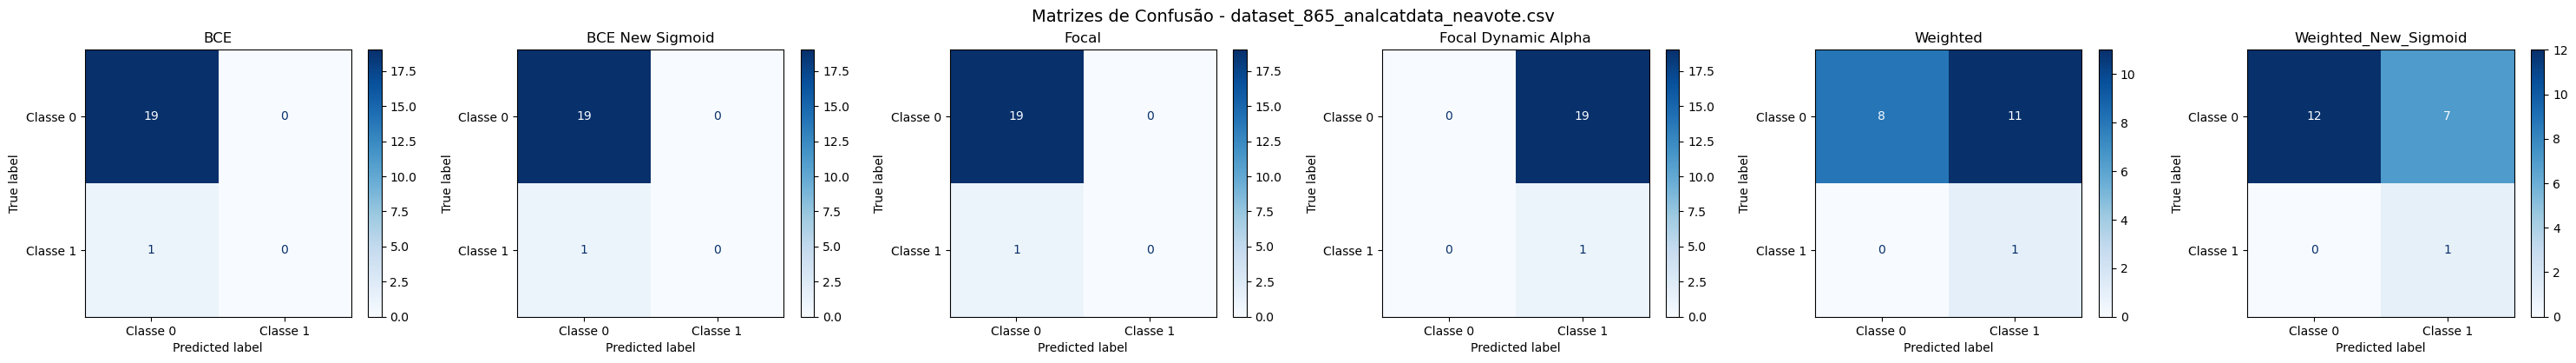


📁 Processando: dataset_1064_ar6.csv
Convergência alcançada em 926 iterações.


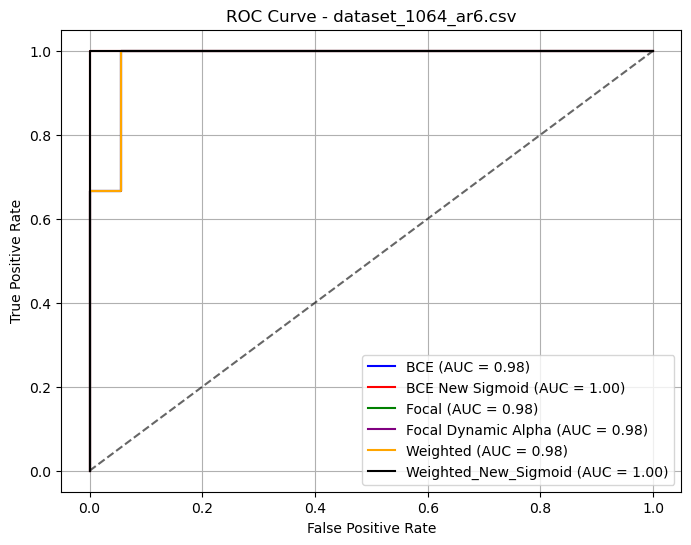

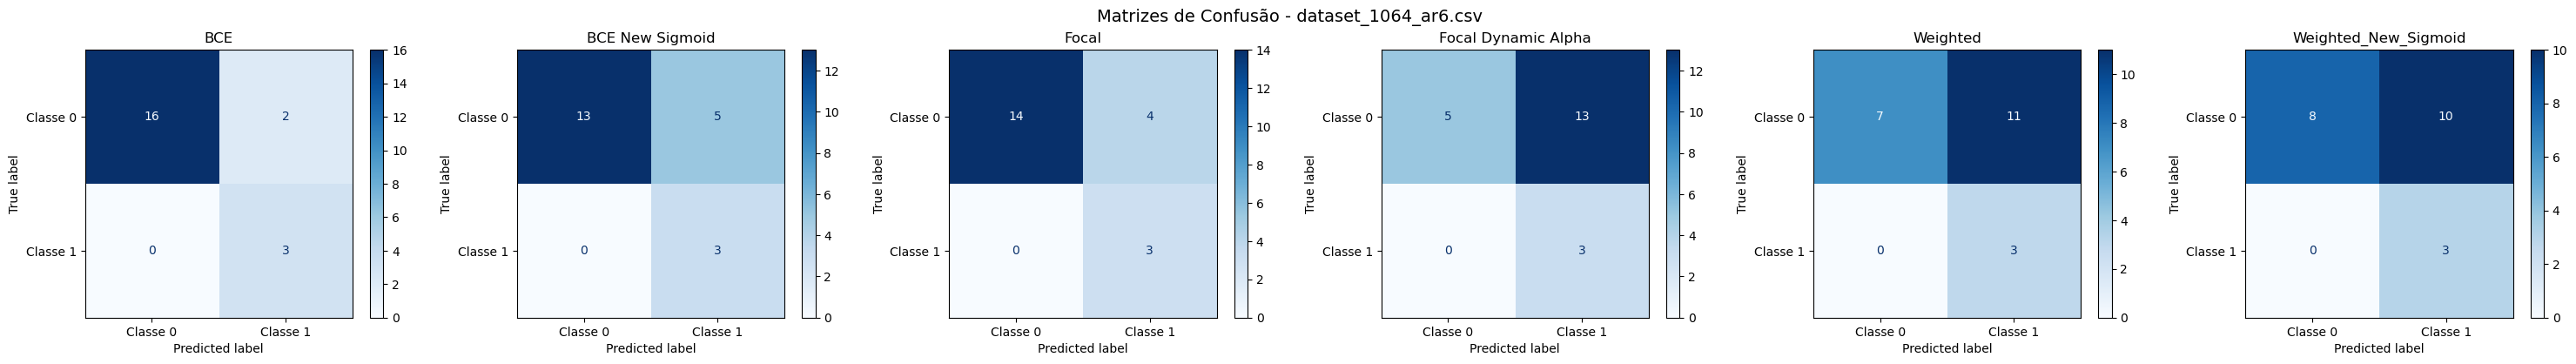


📁 Processando: dataset_980_optdigits.csv
Convergência alcançada em 860 iterações.
Convergência alcançada em 887 iterações.


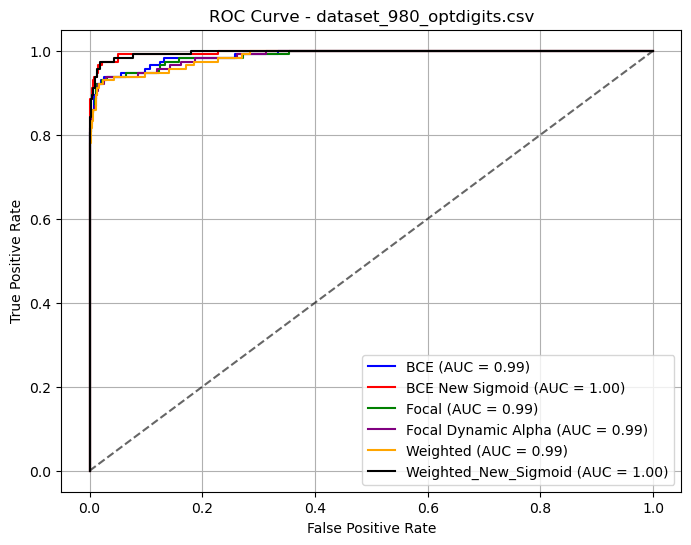

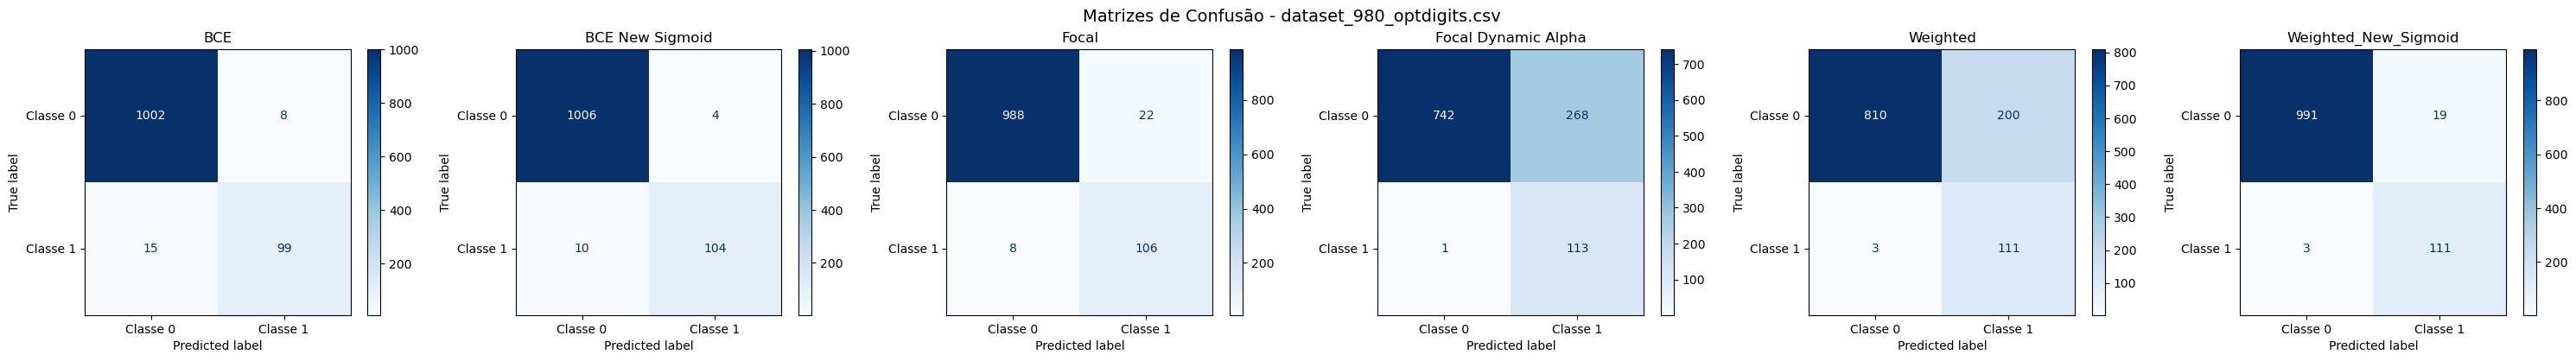


📁 Processando: dataset_995_mfeat-zernike.csv
Convergência alcançada em 915 iterações.


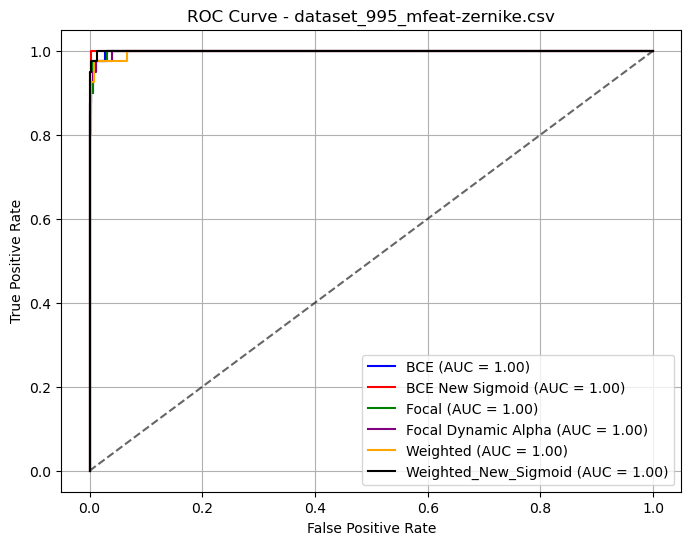

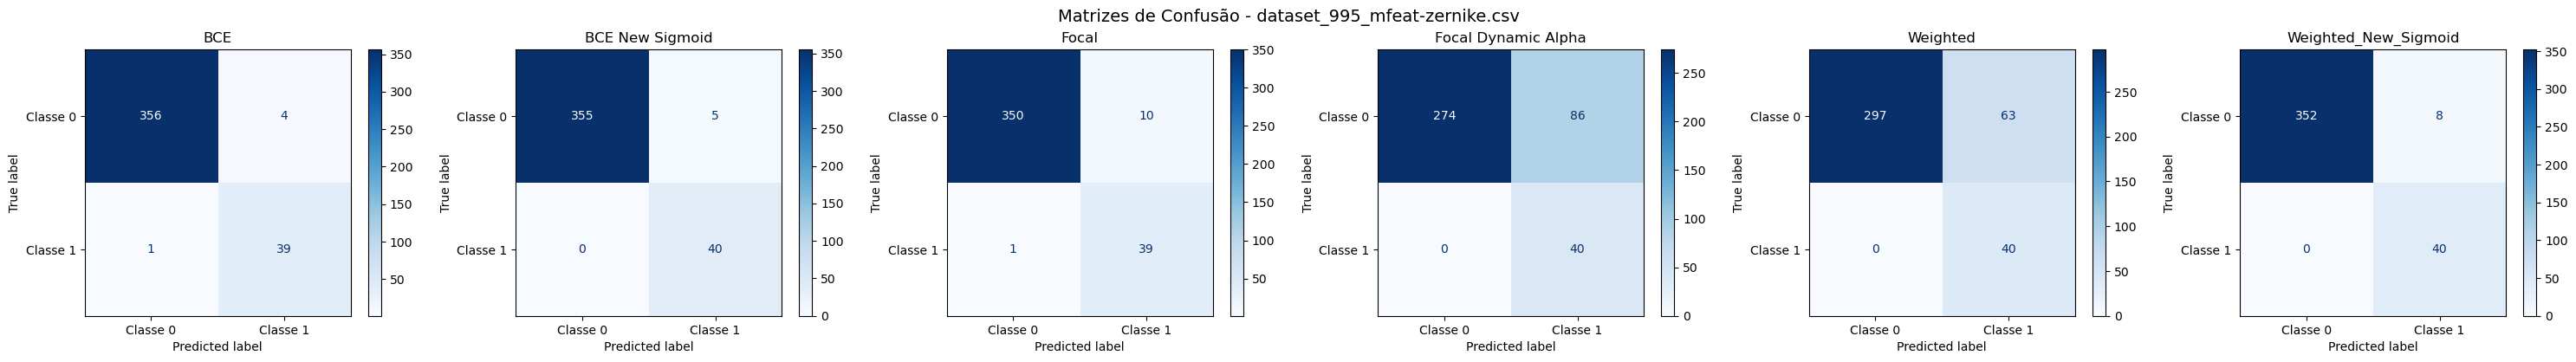


📁 Processando: dataset_316_yeast_ml8.csv
Convergência alcançada em 363 iterações.


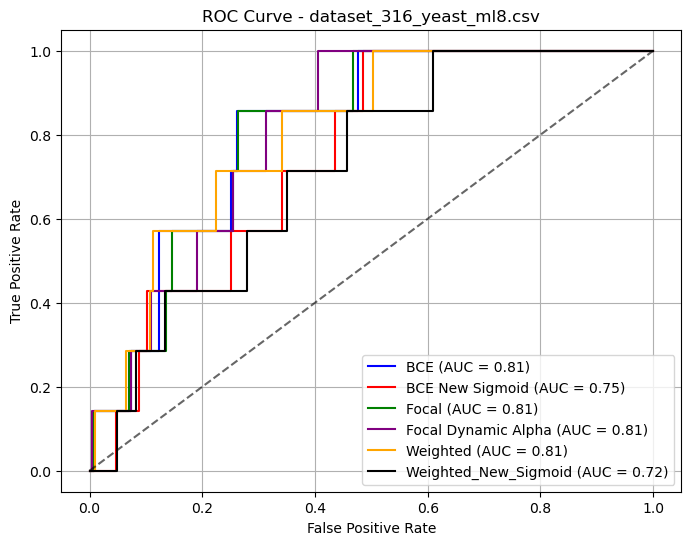

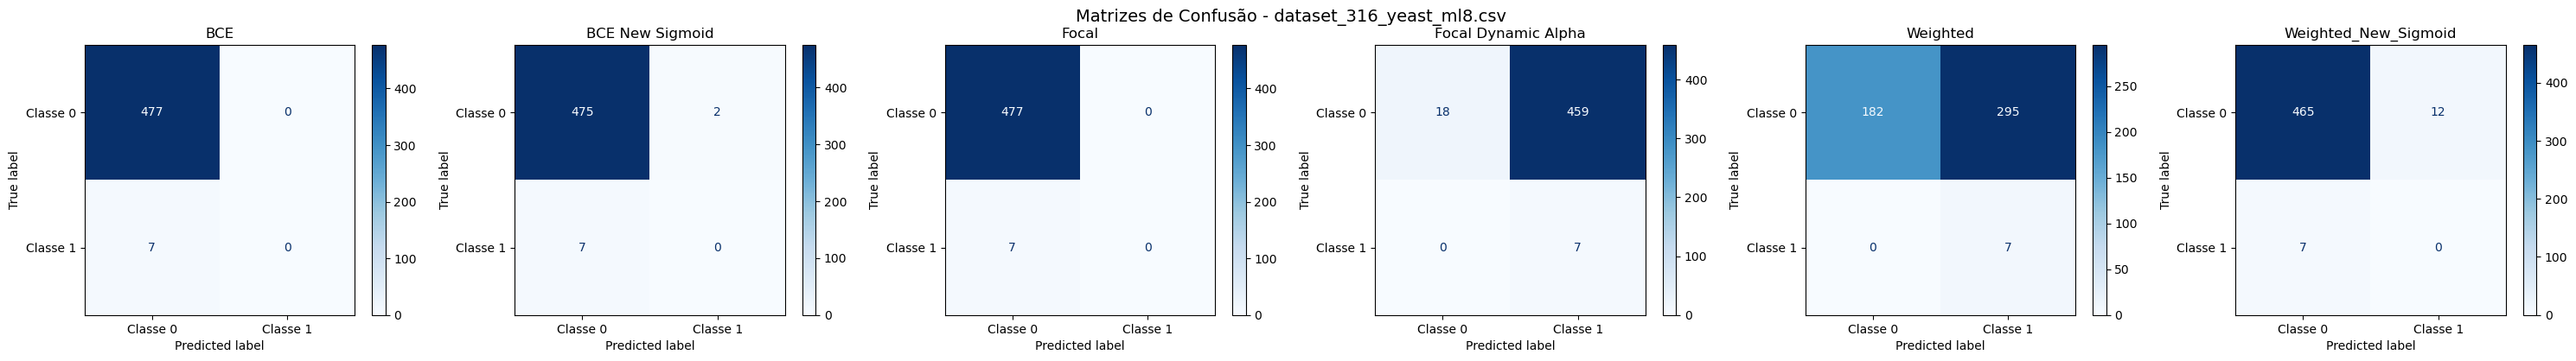


📁 Processando: dataset_1018_ipums_la_99-small.csv
Convergência alcançada em 941 iterações.


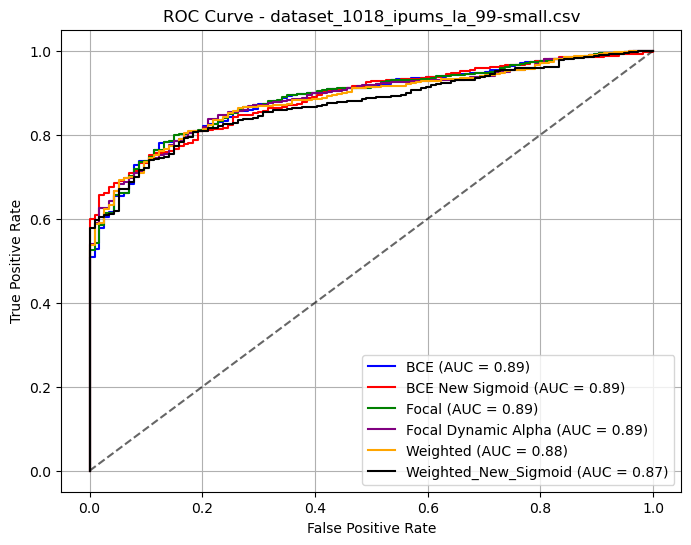

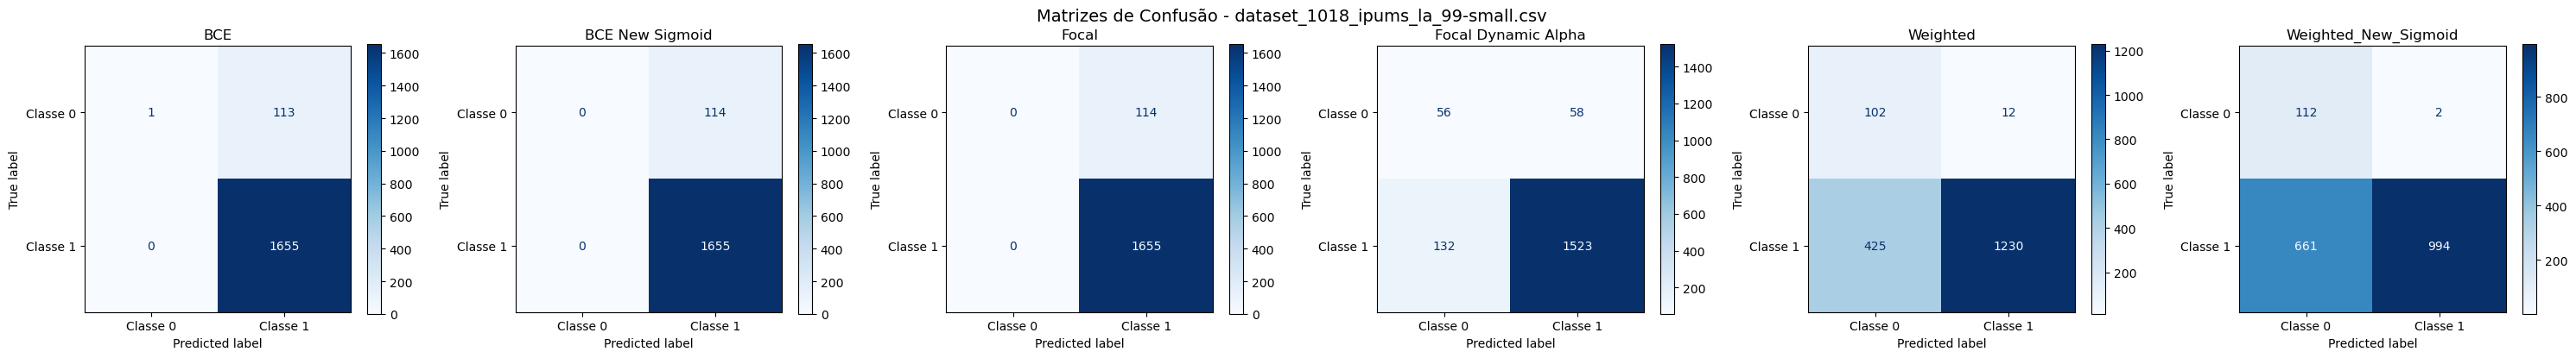


📁 Processando: dataset_767_analcatdata_apnea1.csv
Convergência alcançada em 680 iterações.
Convergência alcançada em 8 iterações.
Convergência alcançada em 503 iterações.
Convergência alcançada em 218 iterações.
Convergência alcançada em 502 iterações.
Convergência alcançada em 6 iterações.


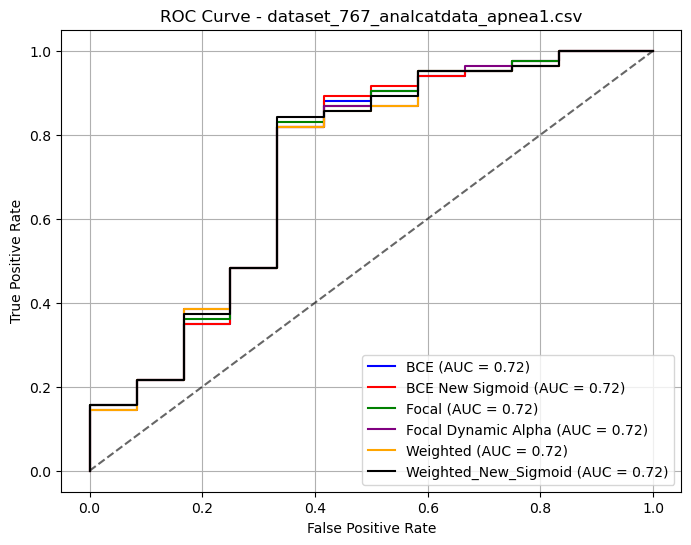

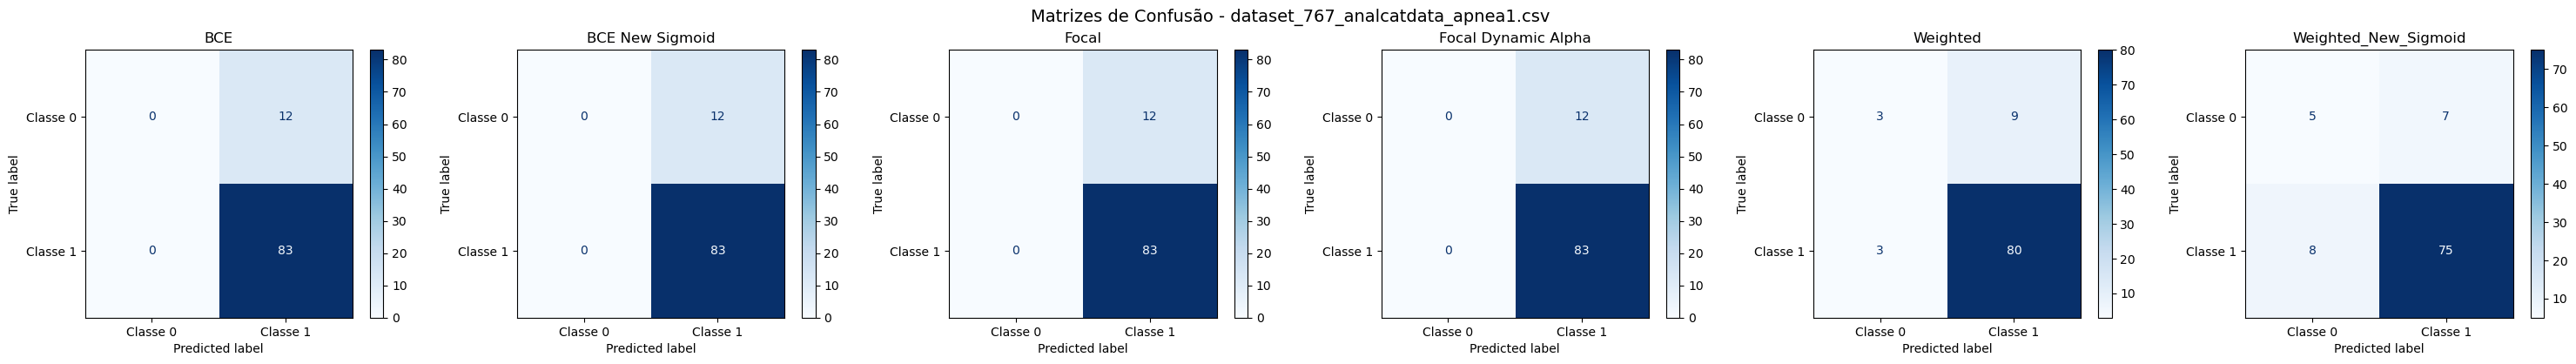


📁 Processando: dataset_1002_ipums_la_98-small.csv
Convergência alcançada em 970 iterações.


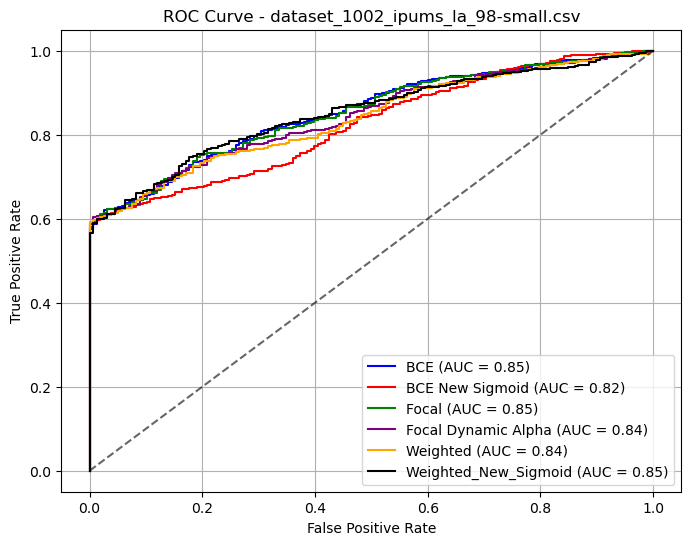

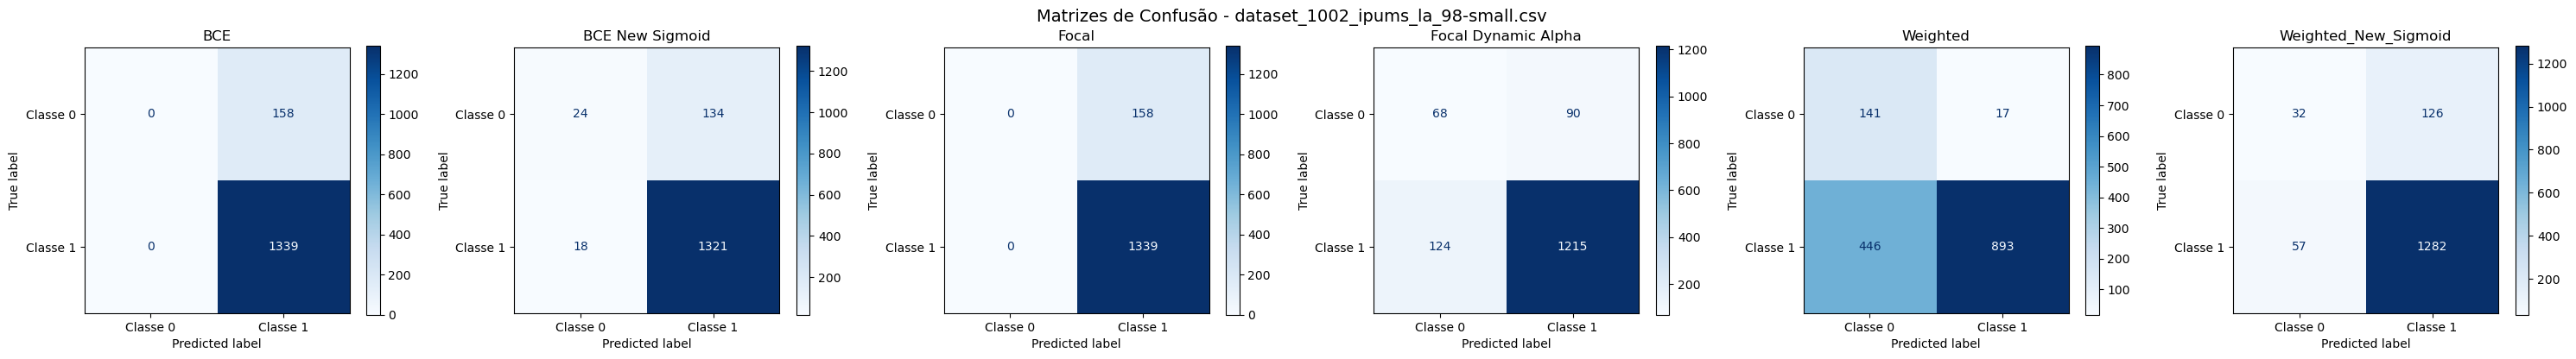


📁 Processando: dataset_1004_synthetic_control.csv


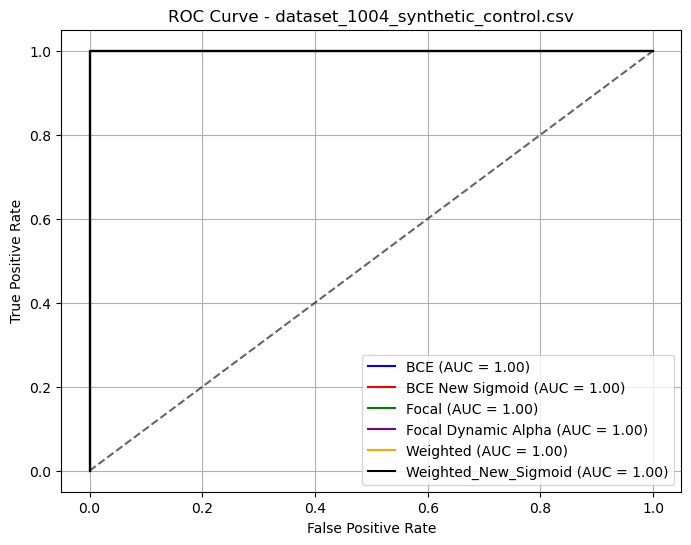

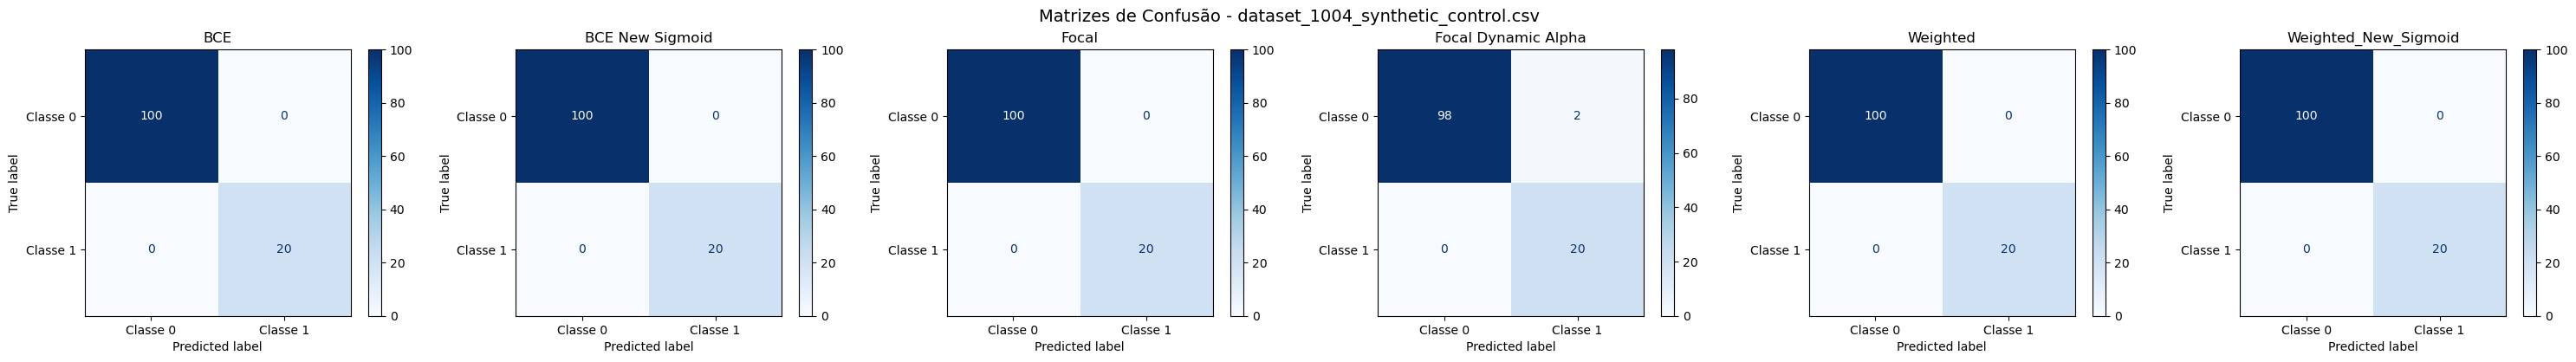


📁 Processando: dataset_1021_page-blocks.csv
Convergência alcançada em 272 iterações.
Convergência alcançada em 983 iterações.
Convergência alcançada em 366 iterações.


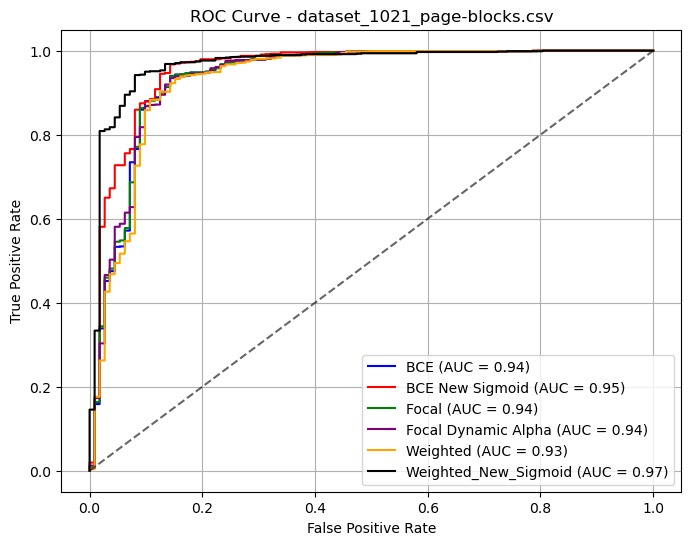

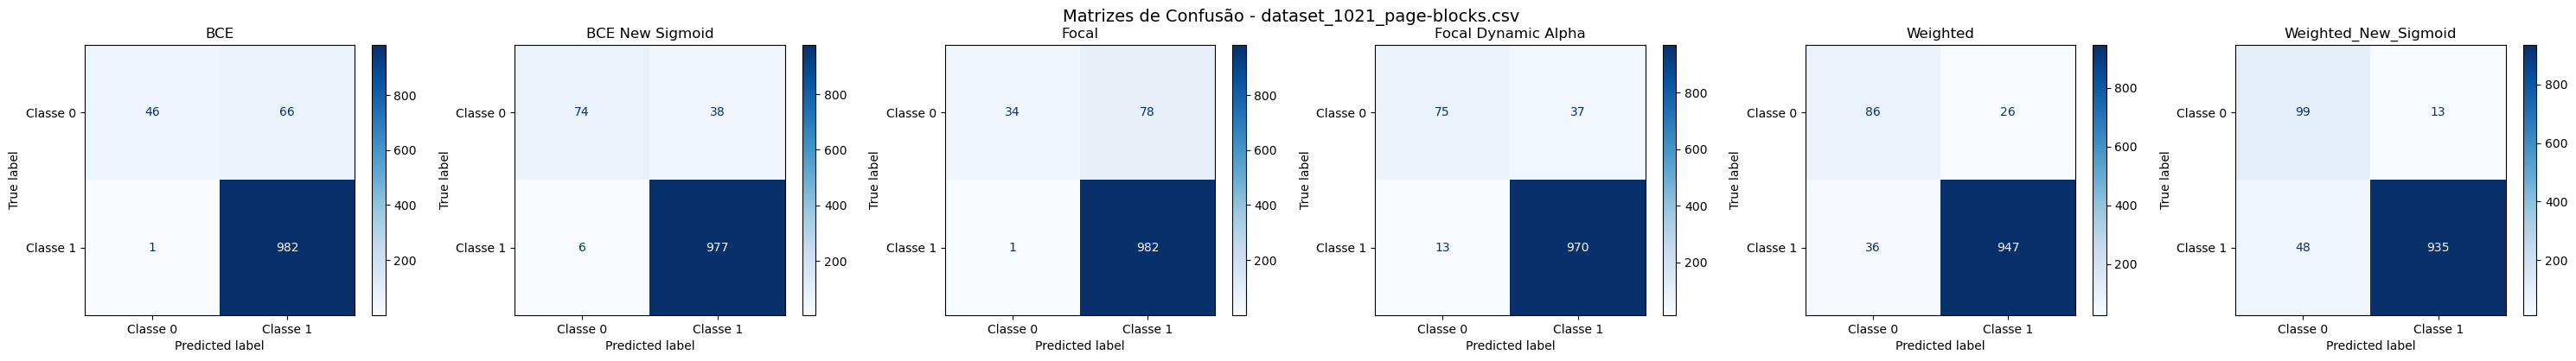


📁 Processando: dataset_1045_kc1-top5.csv
Convergência alcançada em 523 iterações.


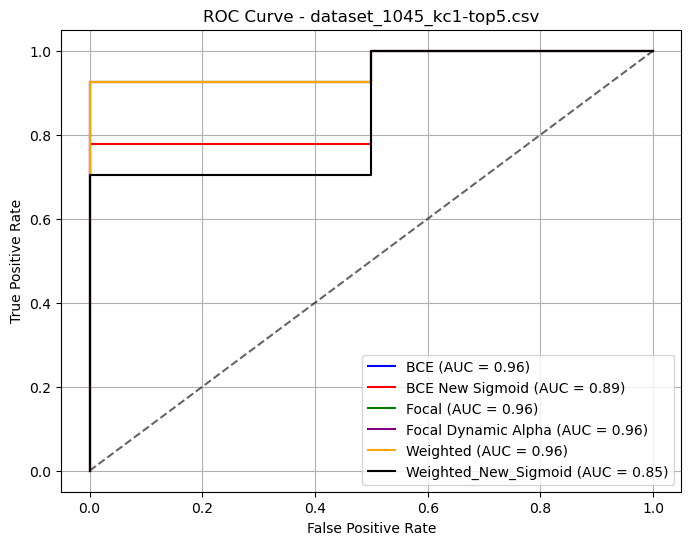

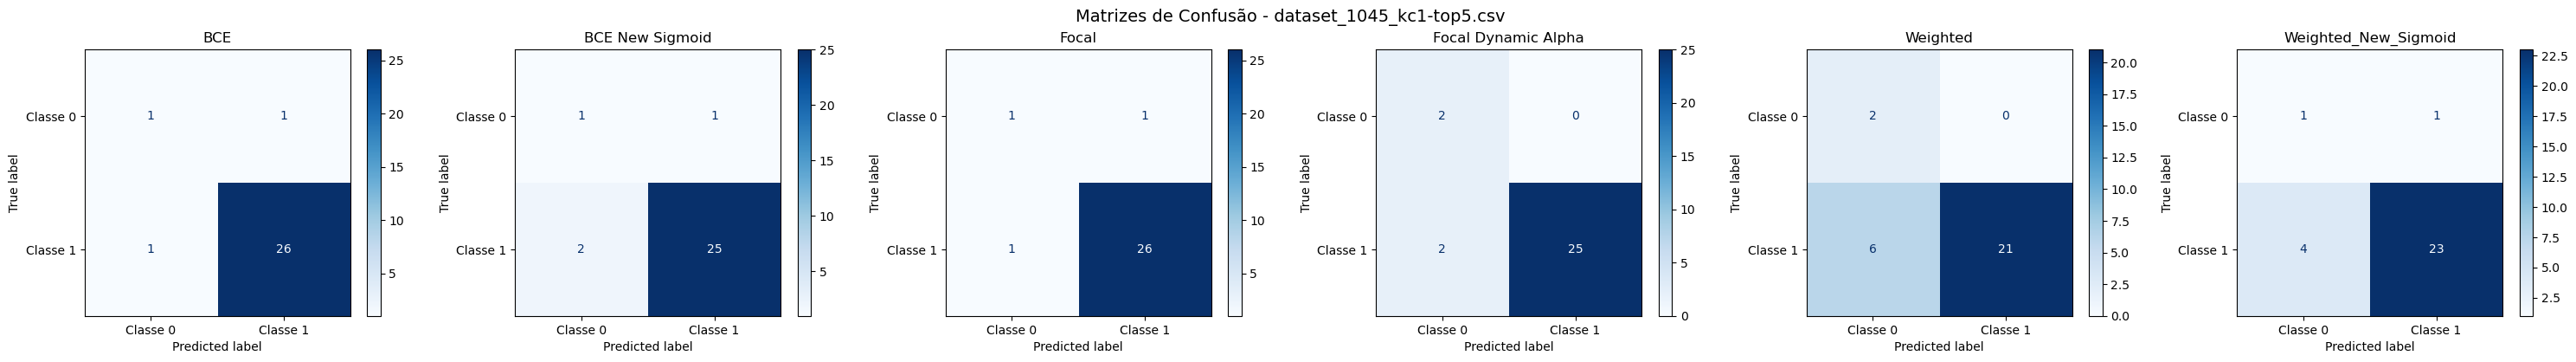


📁 Processando: dataset_976_JapaneseVowels.csv
Convergência alcançada em 369 iterações.
Convergência alcançada em 318 iterações.


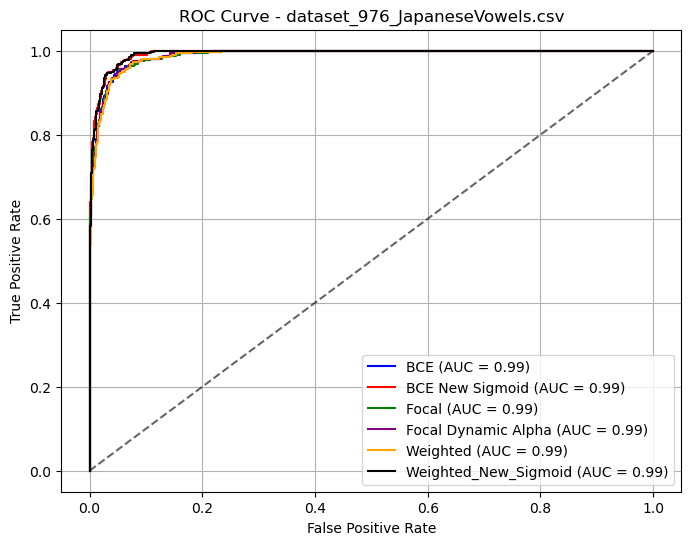

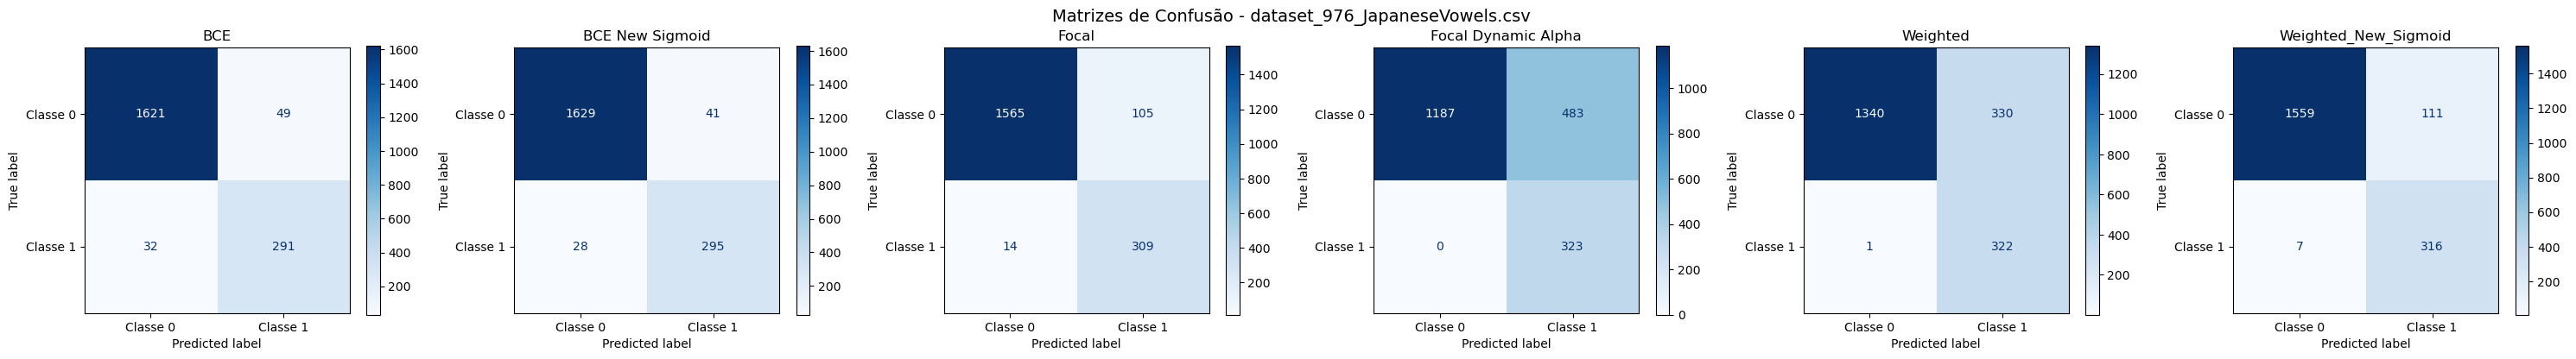


📁 Processando: dataset_875_analcatdata_chlamydia.csv
Convergência alcançada em 38 iterações.
Convergência alcançada em 944 iterações.
Convergência alcançada em 922 iterações.
Convergência alcançada em 30 iterações.


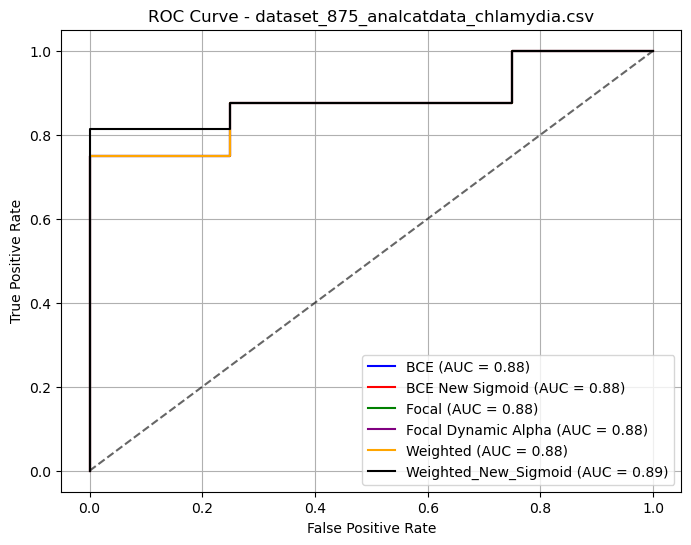

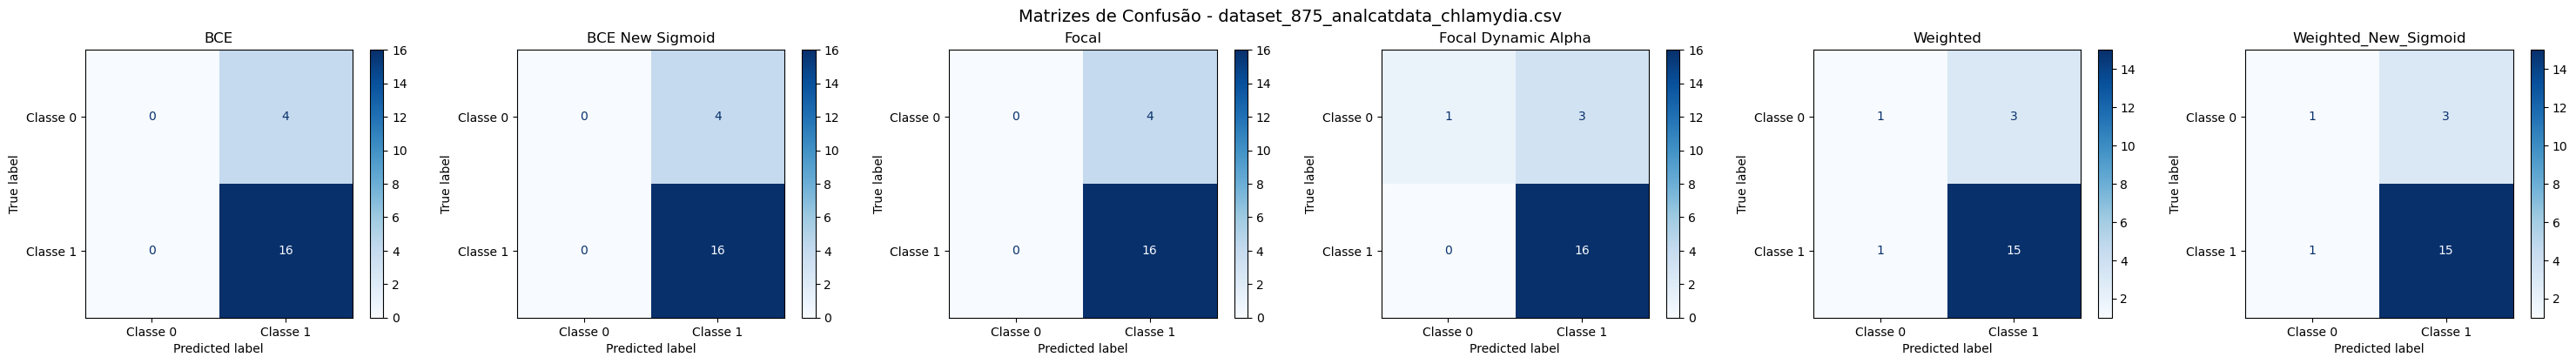


📁 Processando: dataset_1059_ar1.csv


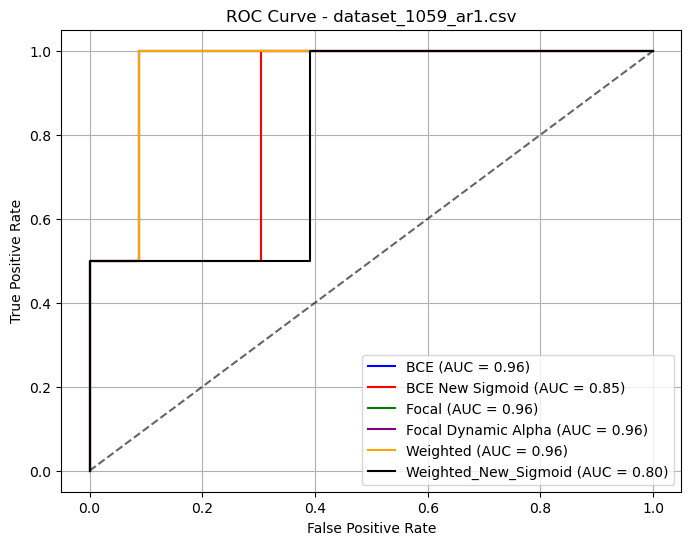

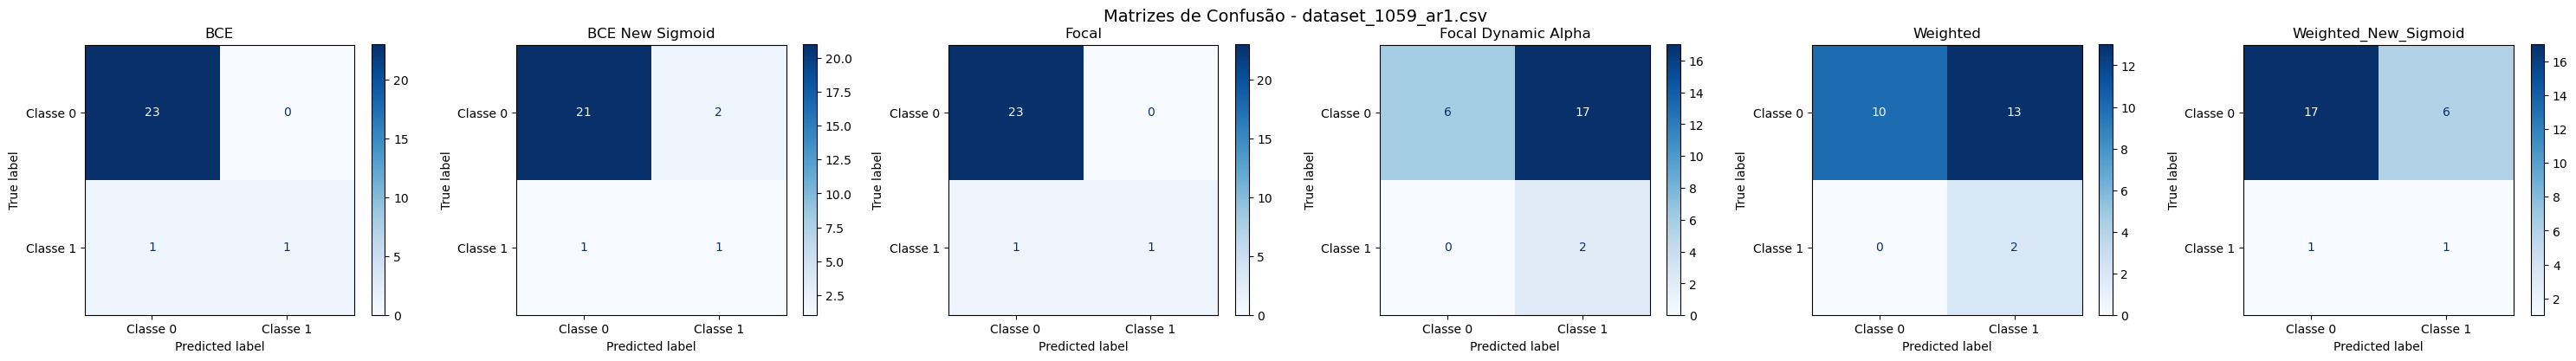


📁 Processando: dataset_1016_vowel.csv
Convergência alcançada em 812 iterações.
Convergência alcançada em 572 iterações.


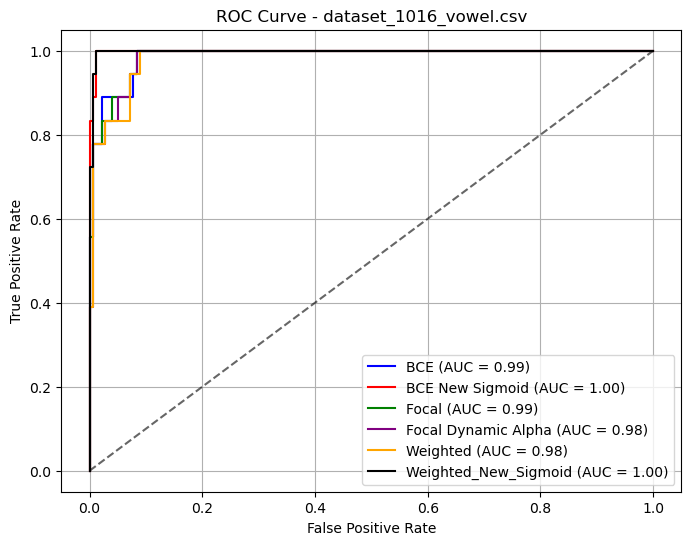

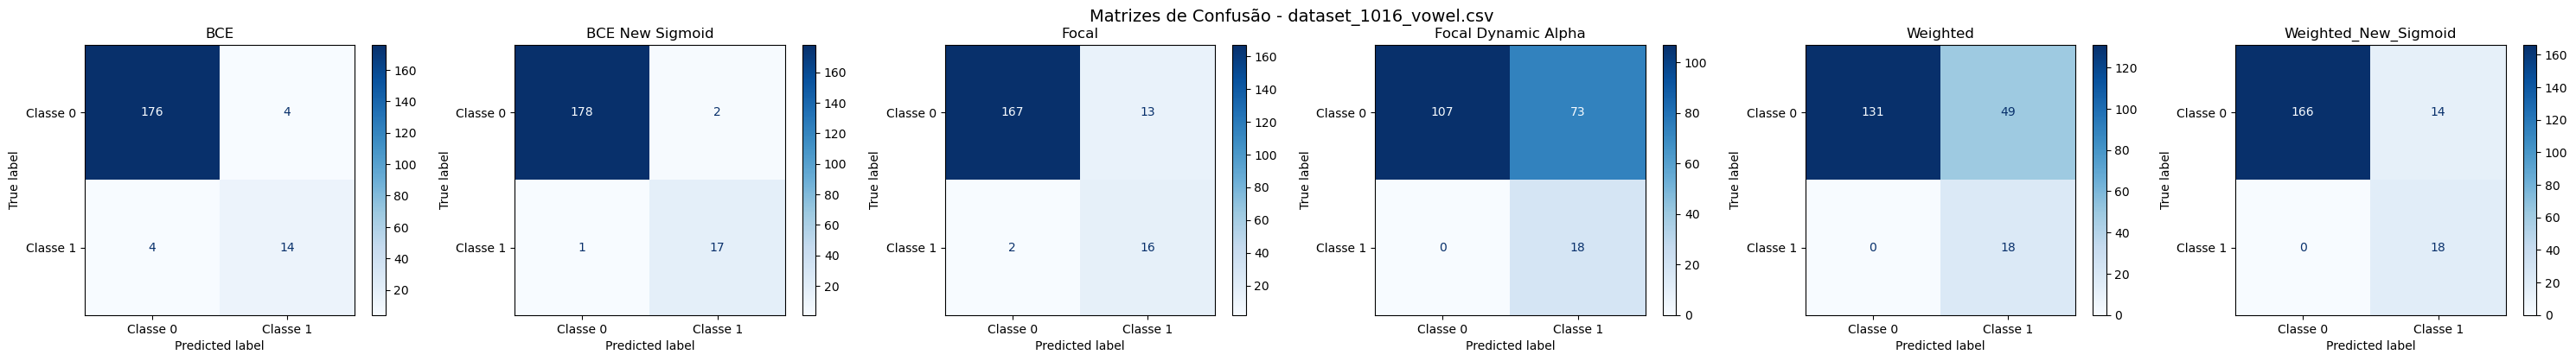


📁 Processando: dataset_757_meta.csv
Convergência alcançada em 874 iterações.
Convergência alcançada em 646 iterações.


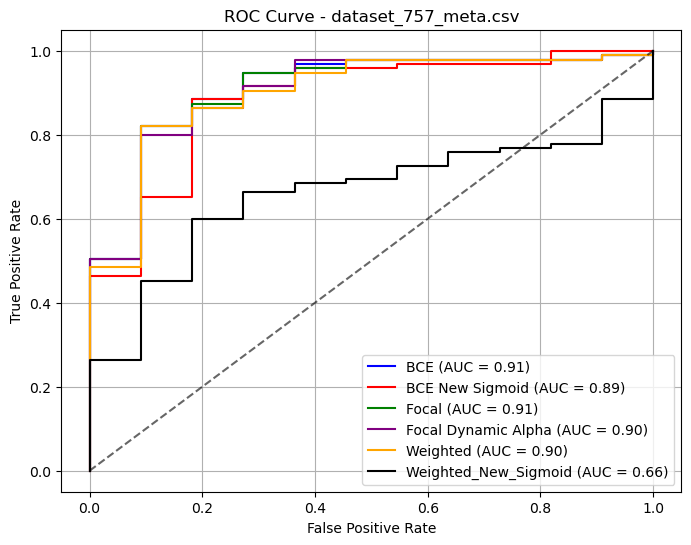

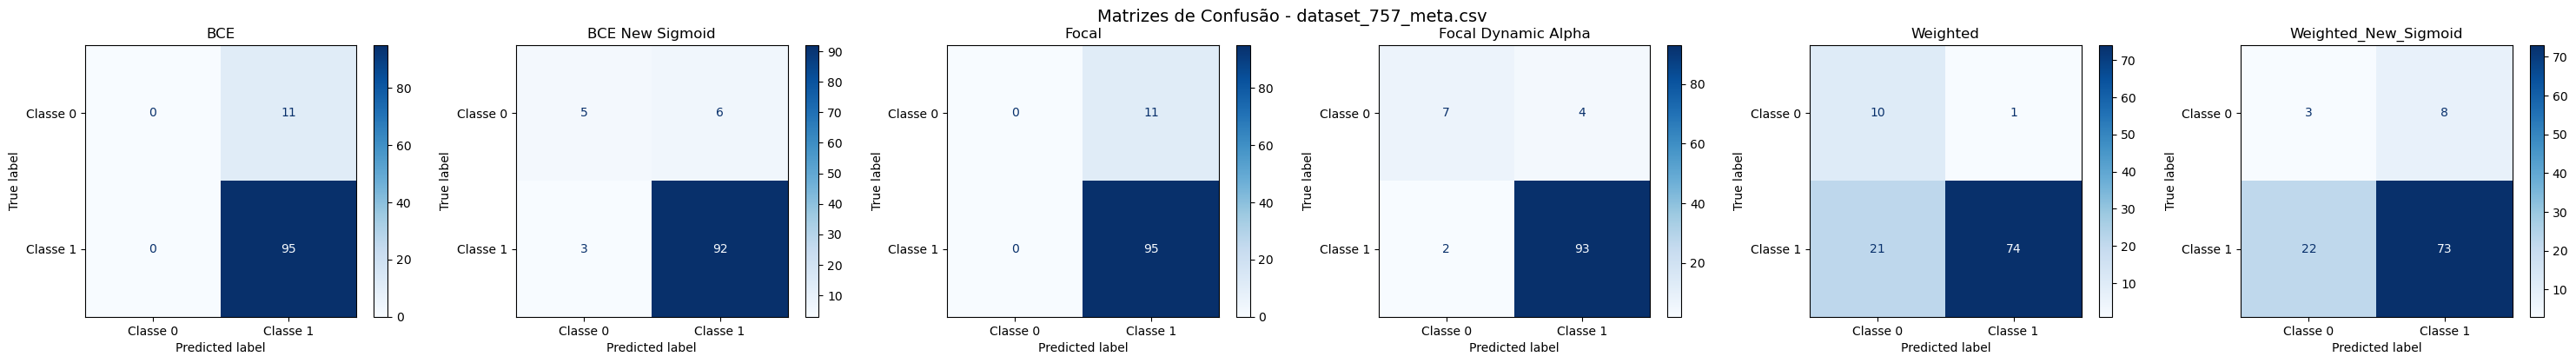


📁 Processando: dataset_1014_analcatdata_dmft.csv
Convergência alcançada em 530 iterações.
Convergência alcançada em 10 iterações.
Convergência alcançada em 400 iterações.
Convergência alcançada em 189 iterações.
Convergência alcançada em 453 iterações.


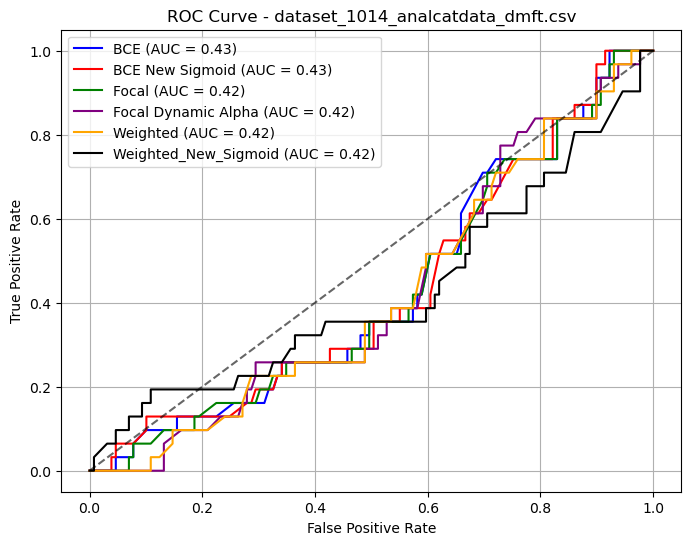

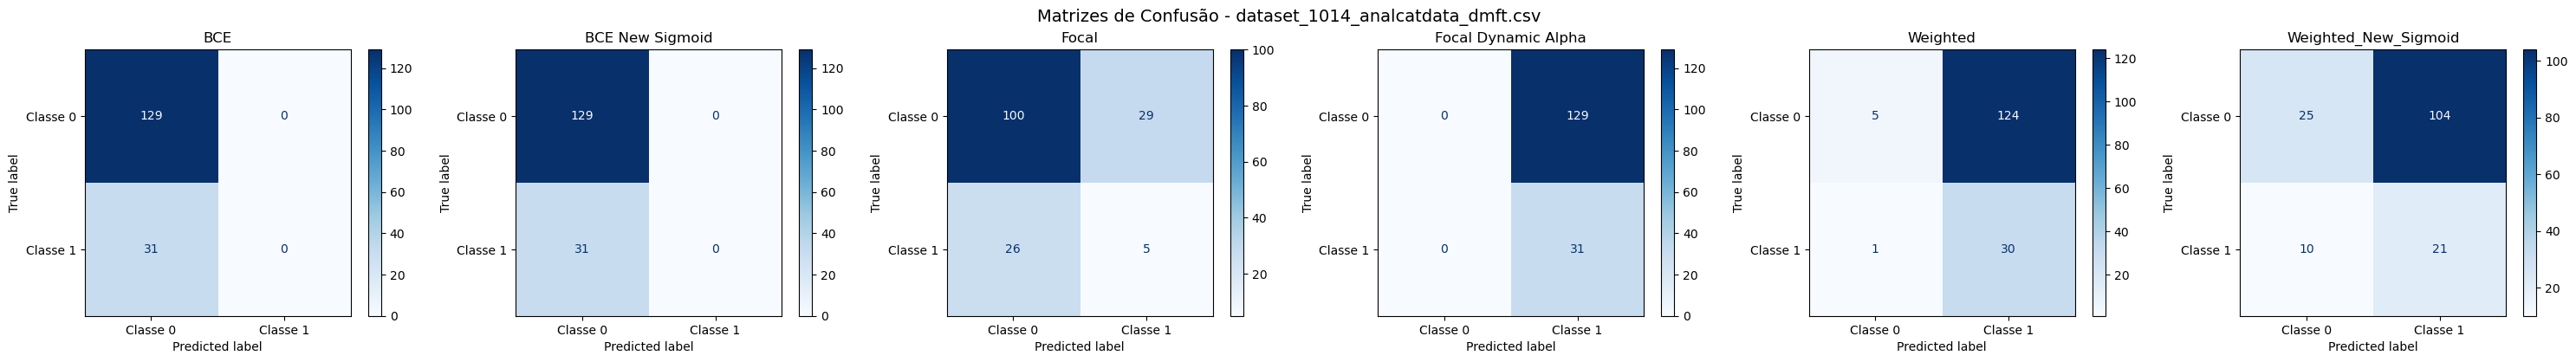


📁 Processando: dataset_984_analcatdata_draft.csv
Convergência alcançada em 790 iterações.
Convergência alcançada em 12 iterações.
Convergência alcançada em 577 iterações.
Convergência alcançada em 1 iterações.
Convergência alcançada em 313 iterações.
Convergência alcançada em 7 iterações.


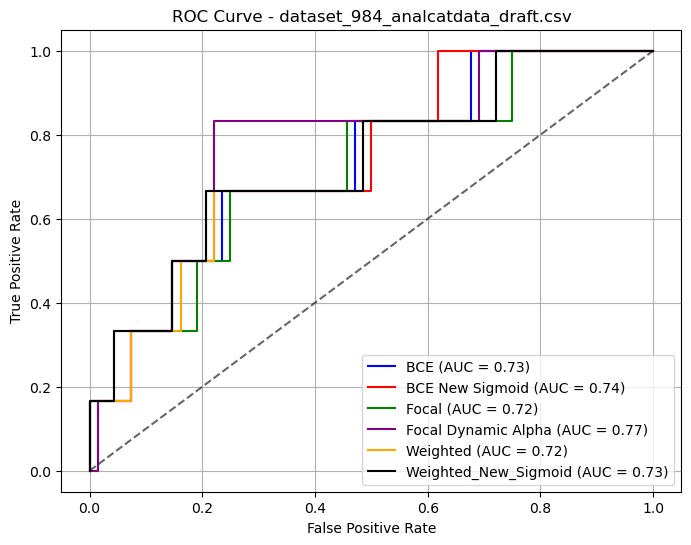

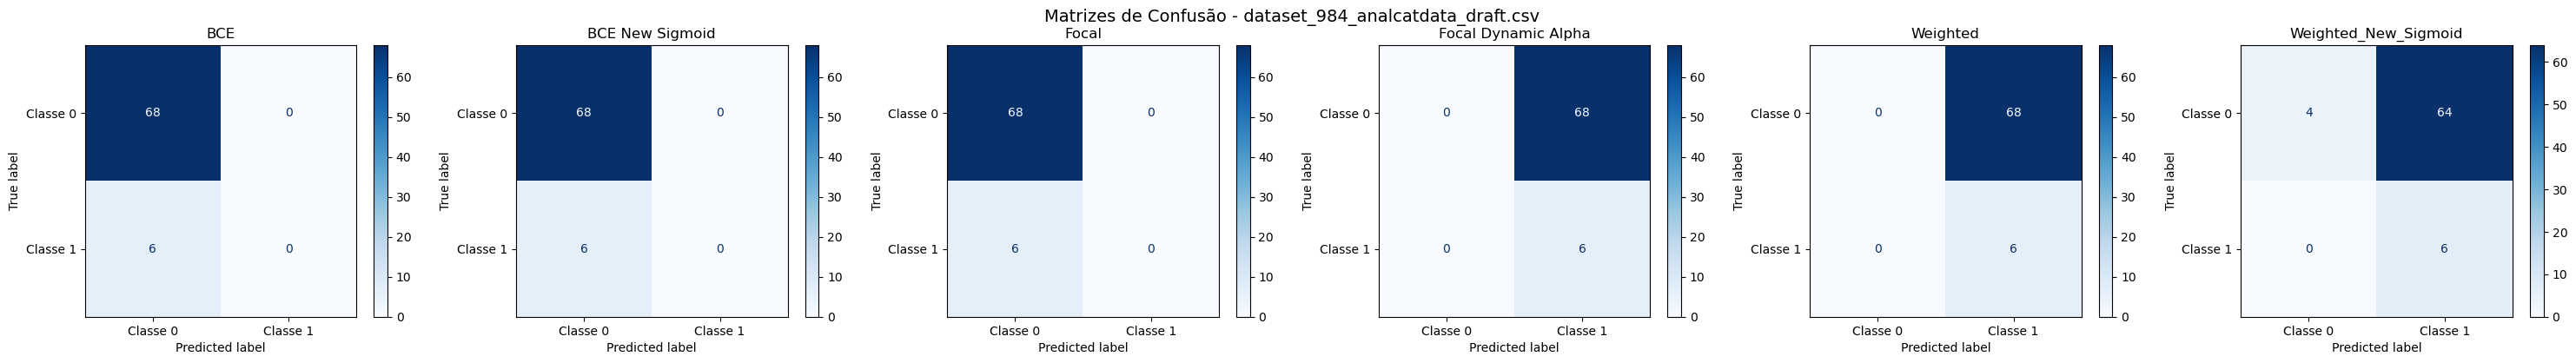


📁 Processando: dataset_1023_soybean.csv


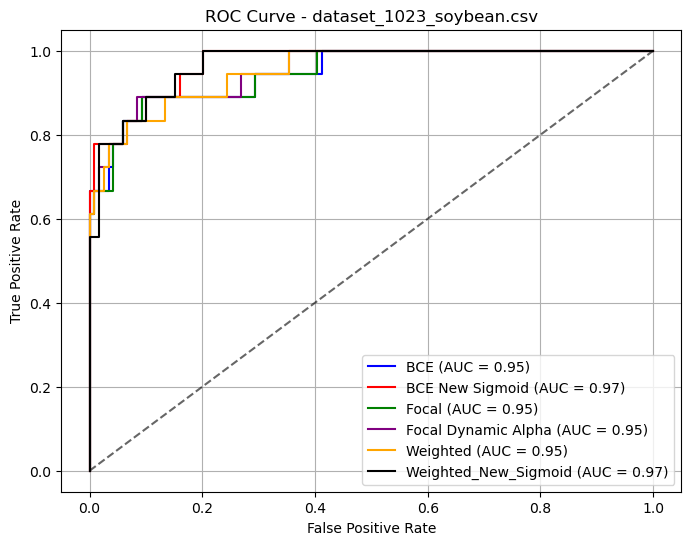

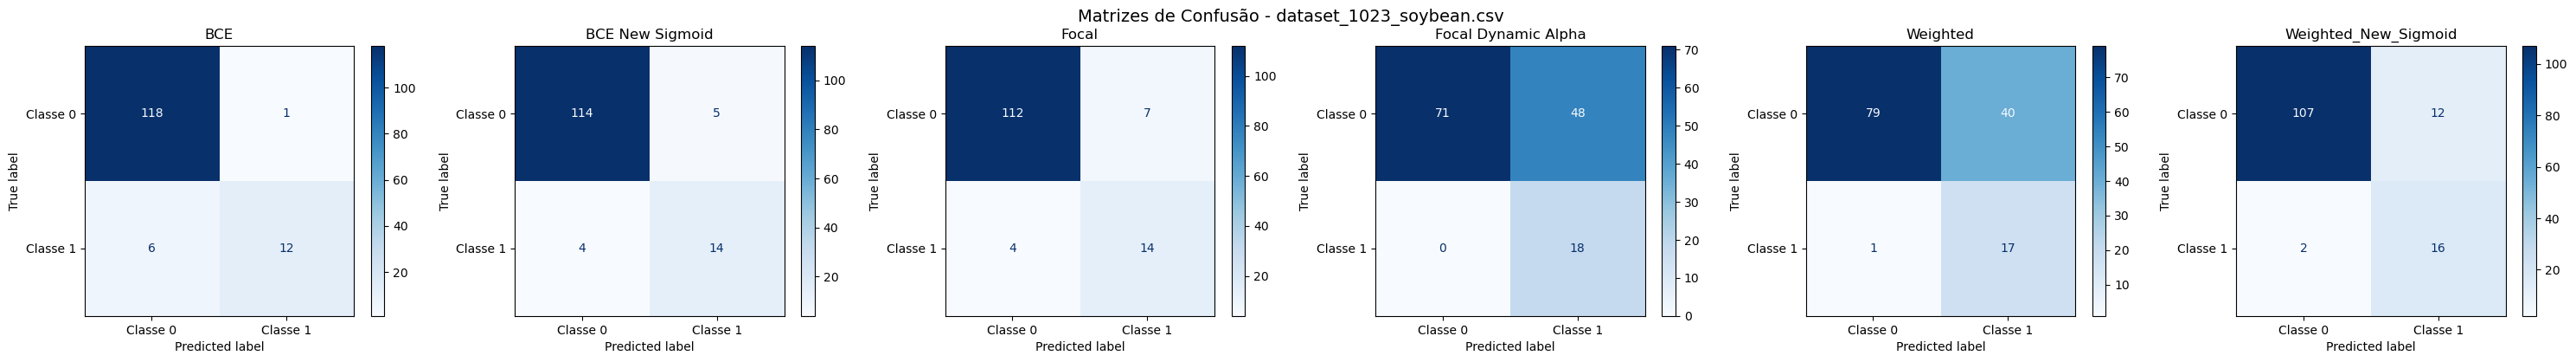


📁 Processando: dataset_978_mfeat-factors.csv
Convergência alcançada em 419 iterações.
Convergência alcançada em 988 iterações.


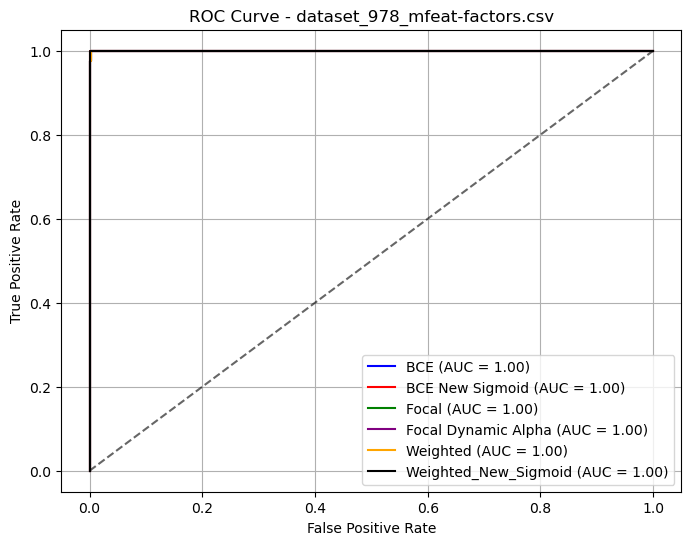

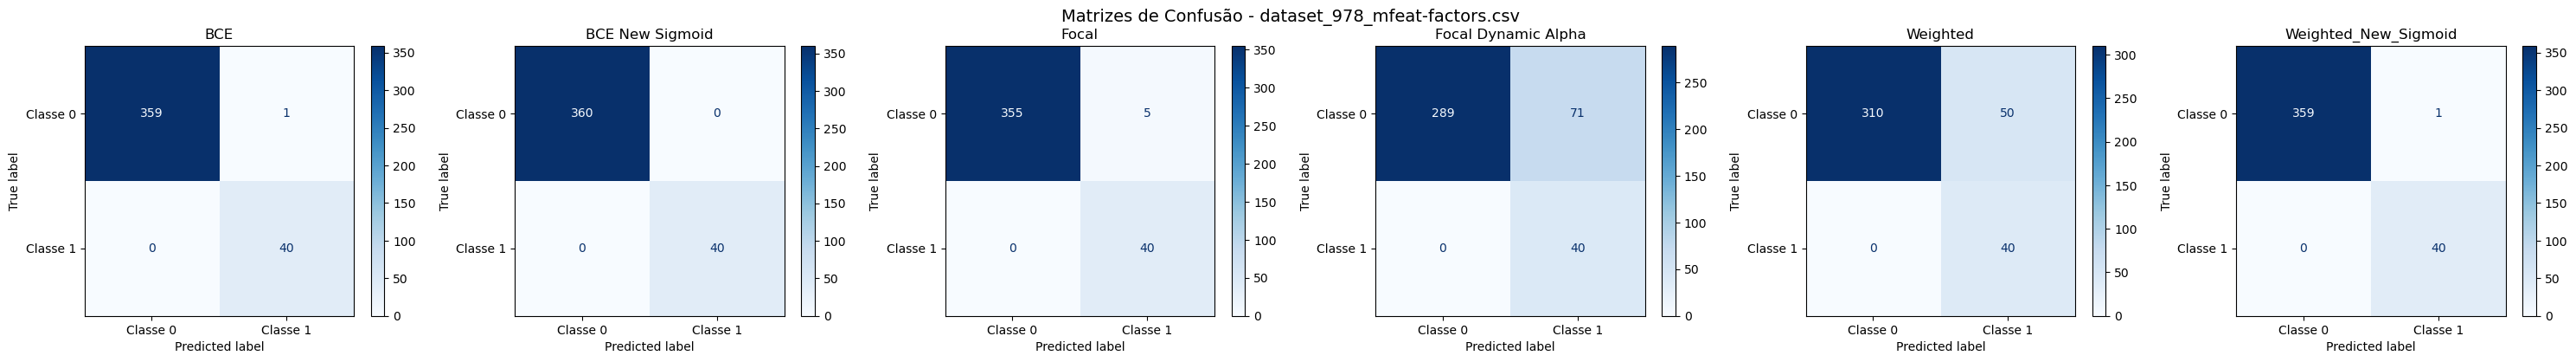


📁 Processando: dataset_1056_mc1.csv
Convergência alcançada em 148 iterações.
Convergência alcançada em 386 iterações.


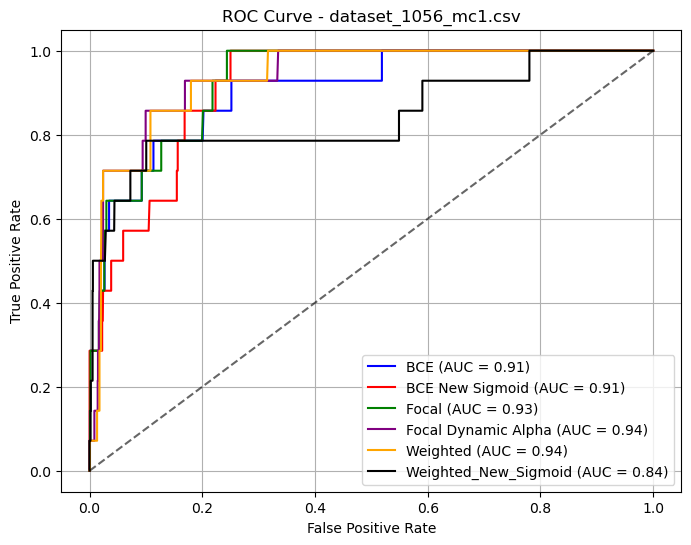

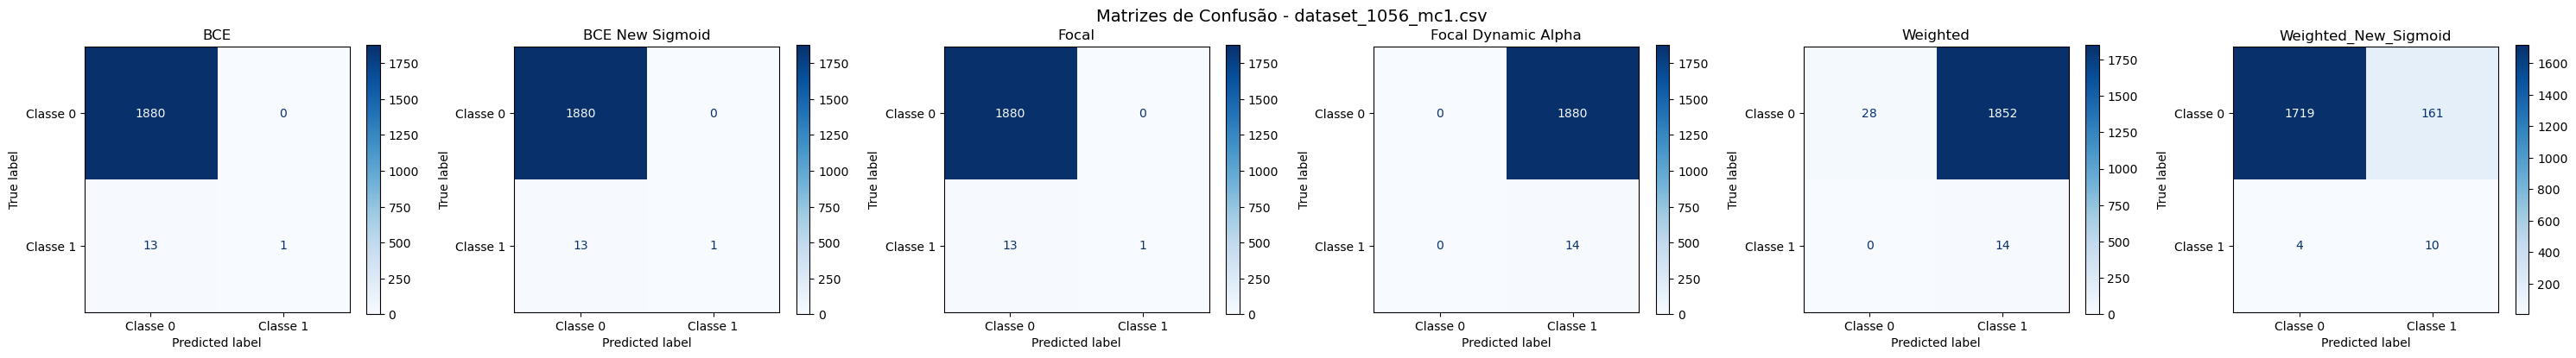


📁 Processando: dataset_971_mfeat-fourier.csv
Convergência alcançada em 502 iterações.
Convergência alcançada em 634 iterações.


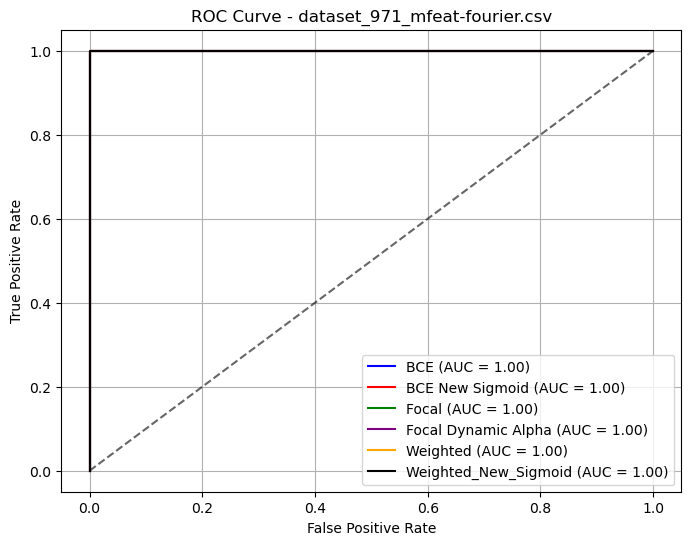

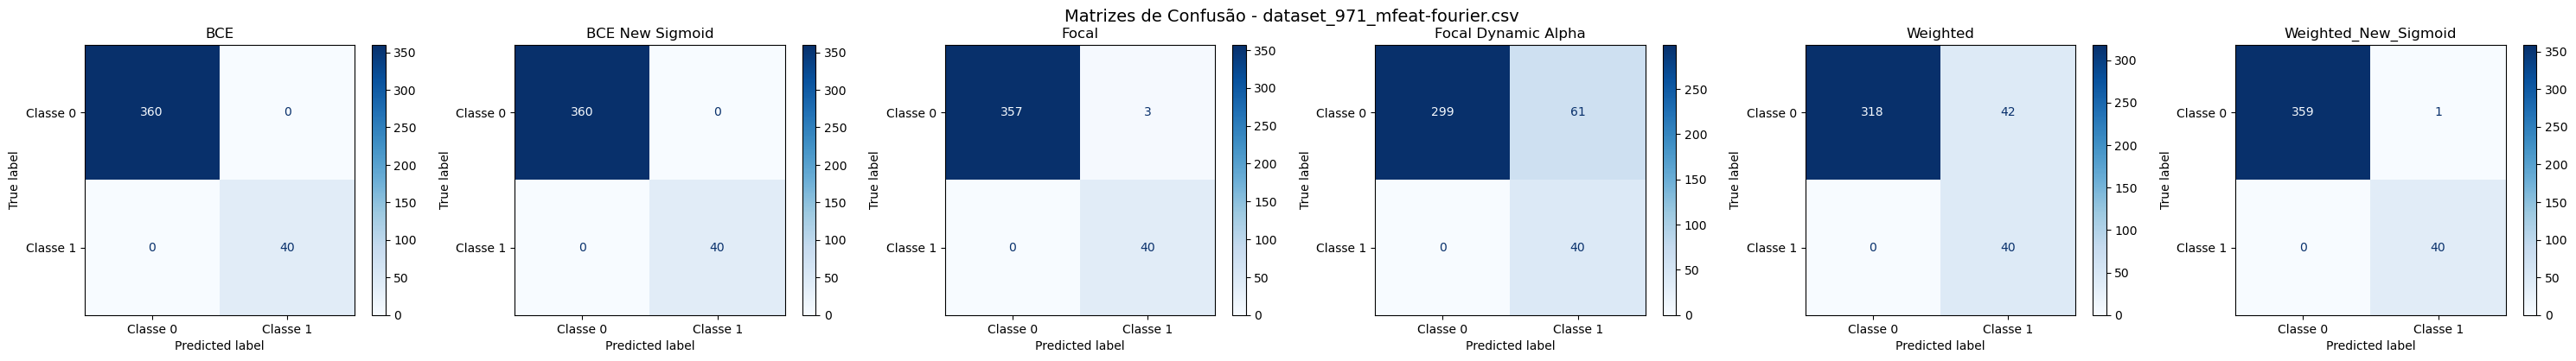


📁 Processando: dataset_867_visualizing_livestock.csv
Convergência alcançada em 744 iterações.
Convergência alcançada em 11 iterações.
Convergência alcançada em 536 iterações.
Convergência alcançada em 416 iterações.
Convergência alcançada em 823 iterações.
Convergência alcançada em 5 iterações.


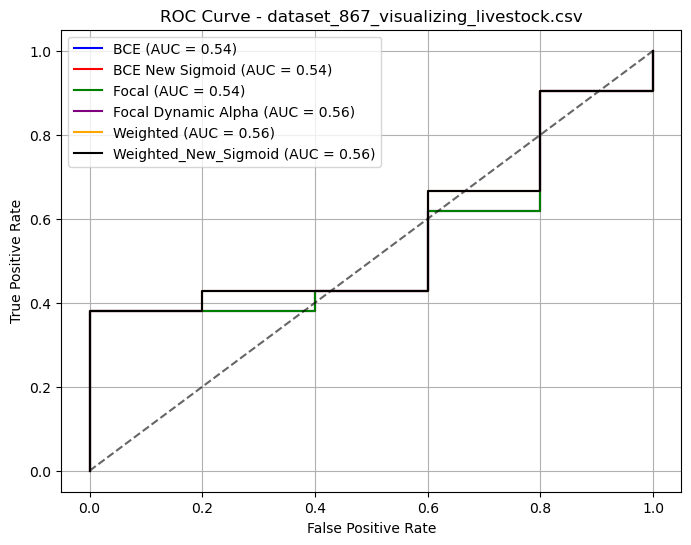

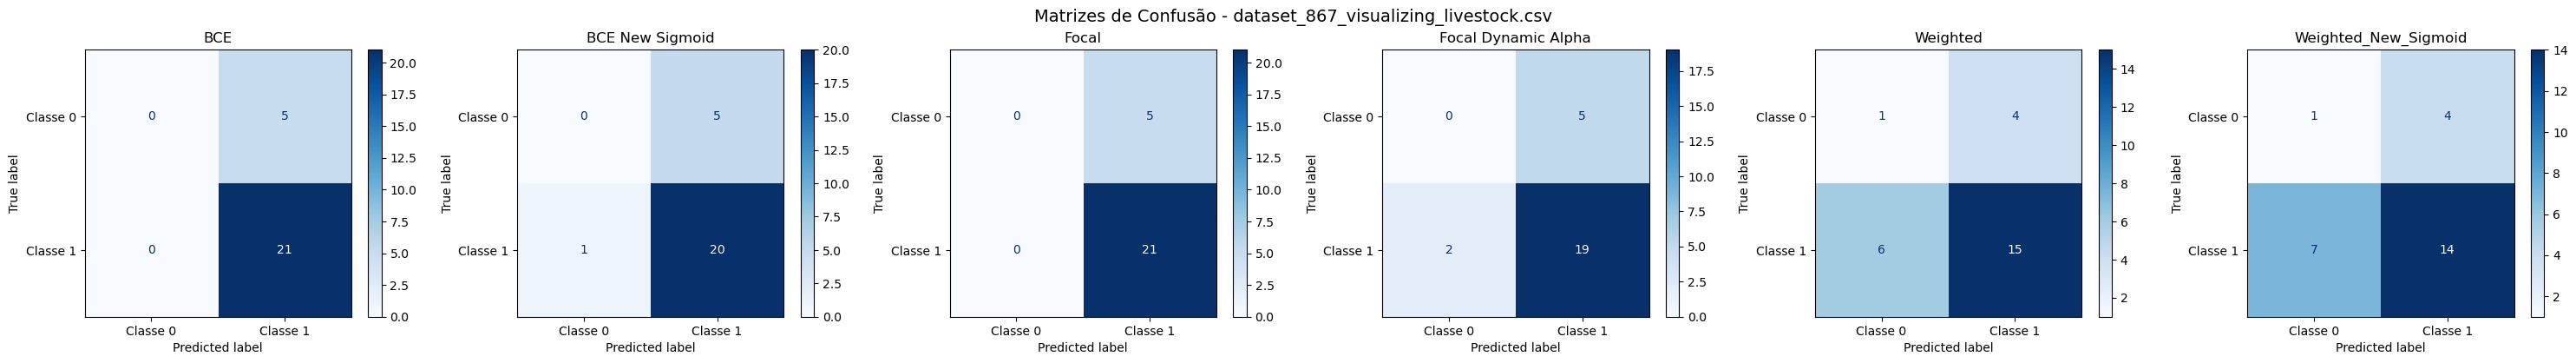


📁 Processando: dataset_1049_pc4.csv


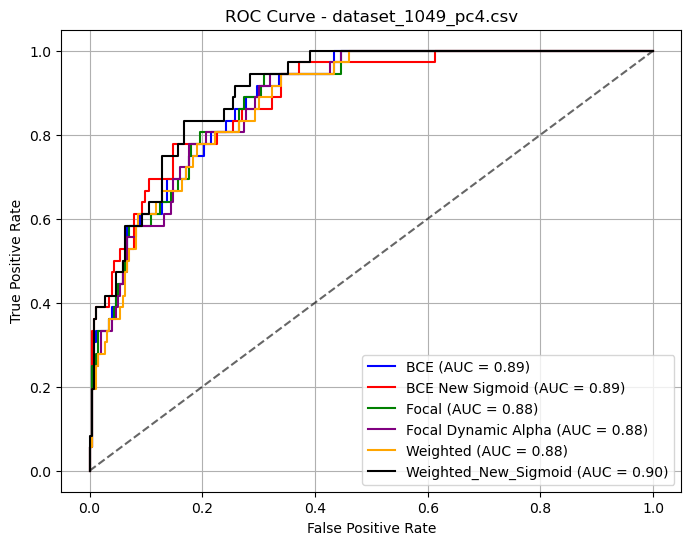

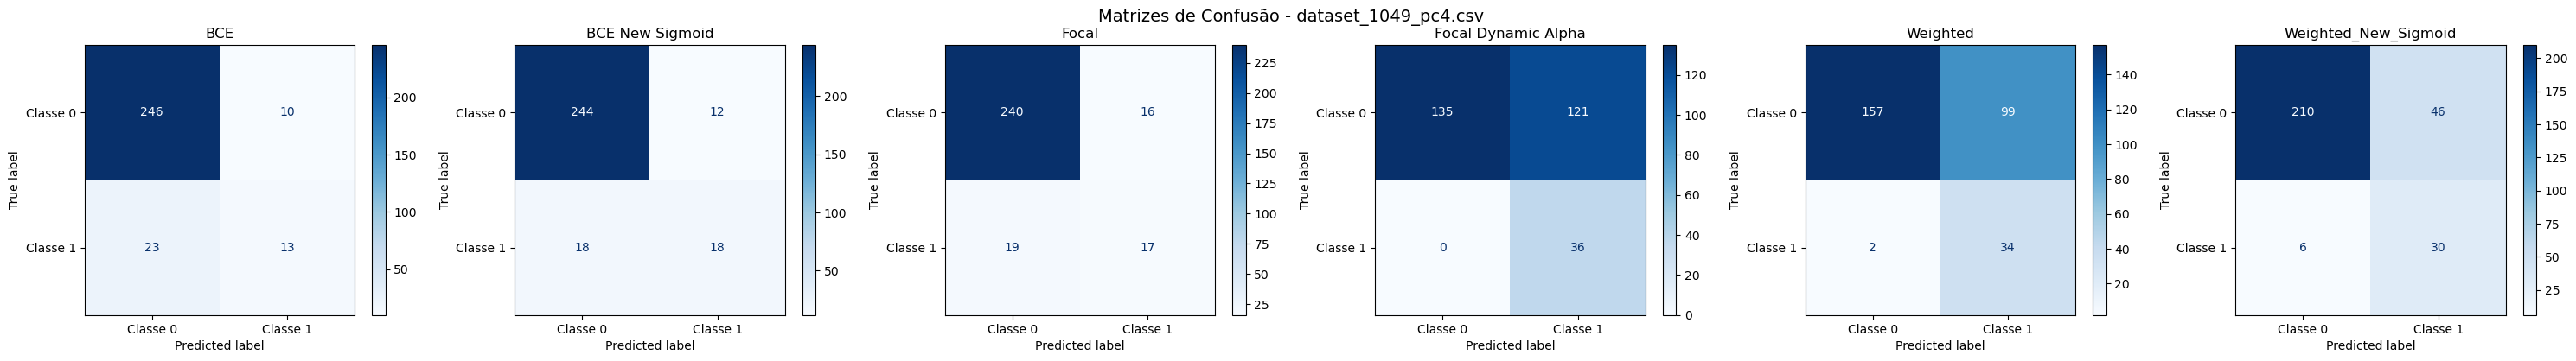


📁 Processando: dataset_940_water-treatment.csv


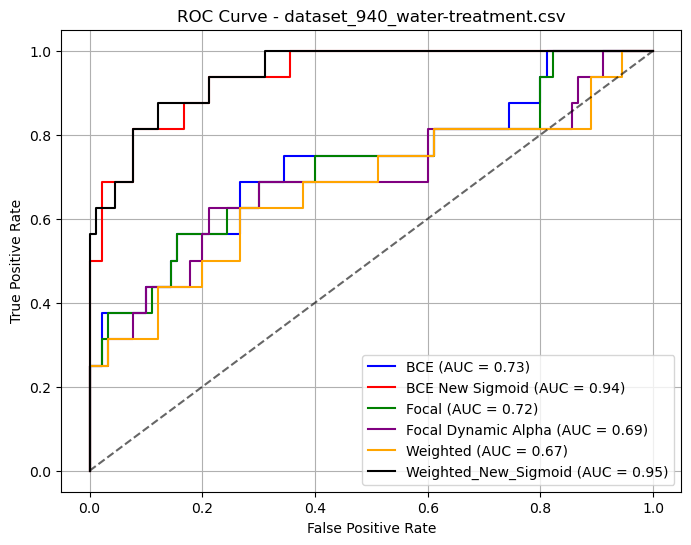

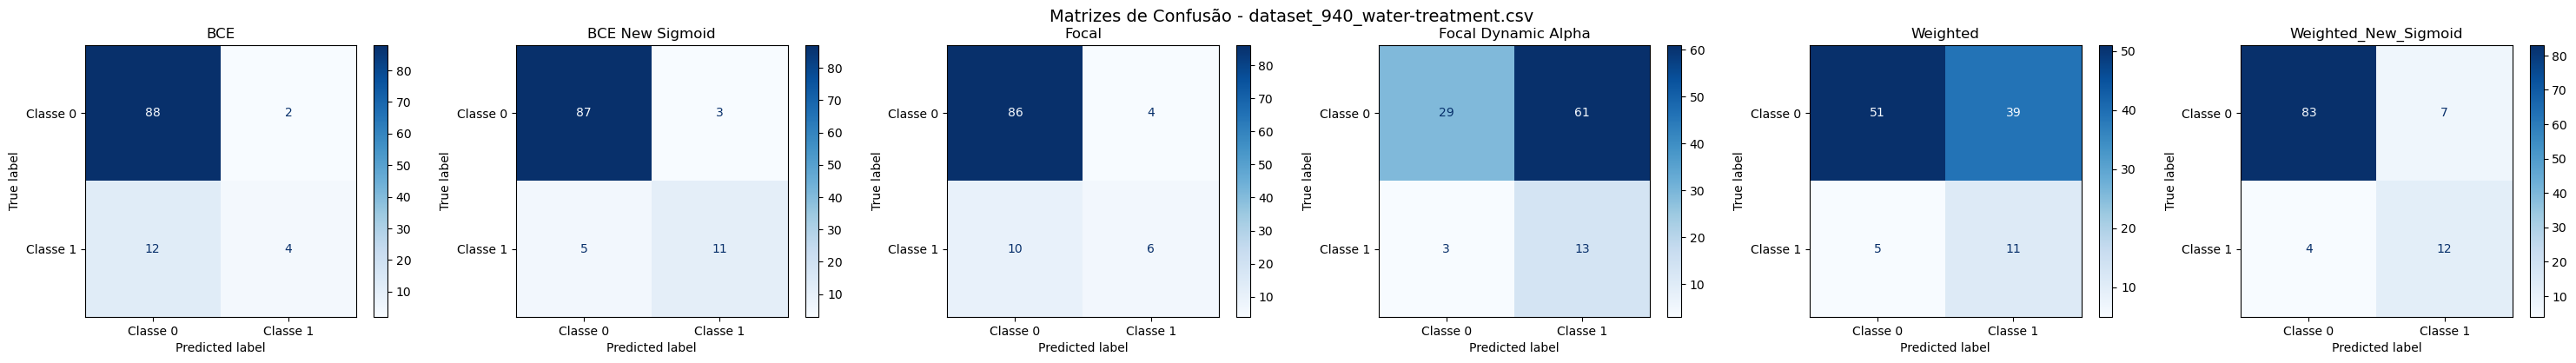

In [9]:
# Loop sobre arquivos
for file in csv_files:
    print(f"\n📁 Processando: {os.path.basename(file)}")
    try:
        df = pd.read_csv(file)
        df = robust_preprocessing(df)

        # Separar features e target
        X = df.iloc[:, :-1].values
        y_raw = df.iloc[:, -1]
        try:
            y = binarise_target(y_raw).values
        except ValueError as e:
            print(f"⚠️ Dataset ignorado: {e}")
            continue

        # Verificação final
        if np.isnan(X).any() or np.isnan(y).any():
            print(f"⚠️ Ainda contém NaNs após tudo. Ignorando.")
            continue

        # Normalização
        scaler = StandardScaler()
        X = scaler.fit_transform(X)

        # Split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, stratify=y, random_state=42
        )

        y_preds = {}
        plt.figure(figsize=(8, 6))

        for i, (name, model) in enumerate(models.items()):
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            y_proba = model.predict_proba(X_test)

            y_preds[name] = y_pred

            acc = accuracy_score(y_test, y_pred)
            bal_acc = balanced_accuracy_score(y_test, y_pred)
            prec = precision_score(y_test, y_pred, zero_division=0)
            rec = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            fpr, tpr, _ = roc_curve(y_test, y_proba)
            roc_auc = auc(fpr, tpr)

            eps = 1e-12

            # after confusion_matrix:
            tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
            den = tn + fp
            if den == 0:
                specificity = 0.0
            else:
                specificity = tn / den

            # alternatively with epsilon-smoothing:
            specificity = tn / (den + eps)

            gmean = np.sqrt(rec * specificity)

            metrics[name]["accuracy"].append(acc)
            metrics[name]["balanced_accuracy"].append(bal_acc)
            metrics[name]["precision"].append(prec)
            metrics[name]["recall"].append(rec)
            metrics[name]["f1"].append(f1)
            metrics[name]["auc"].append(roc_auc)
            metrics[name]["gmean"].append(gmean)

            plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})", color=colors[i])

        plt.plot([0, 1], [0, 1], "k--", alpha=0.6)
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve - {os.path.basename(file)}")
        plt.legend()
        plt.grid(True)
        plt.show()

        # Matriz de Confusão de cada modelo
        n_models = len(models)
        fig, axes = plt.subplots(1, n_models, figsize=(5*n_models, 4))
        axes = axes.flatten()

        for i, name in enumerate(models):
            ConfusionMatrixDisplay.from_predictions(
                y_test, y_preds[name],
                display_labels=["Classe 0", "Classe 1"],
                cmap="Blues",
                values_format='d',
                ax=axes[i]
            )
            axes[i].set_title(name)

        plt.suptitle(f"Matrizes de Confusão - {os.path.basename(file)}", fontsize=14)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"❌ Erro ao processar {file}: {e}")

In [10]:
# ---------------------------------------------------------------------------
# 5.  Aggregate metric table
# ---------------------------------------------------------------------------

# Highlight best per metric (Markdown bold)
def bold_best(s):
    # parse mean part before ' ± '
    numbers = s.str.extract(r'([0-9.]+)').astype(float)[0]
    best = numbers.max()
    return s.where(numbers < best, "**" + s + "**")

metric_table_cols = metric_names  # order for display

rows = []
for name in models:
    row = {"Model": name}
    for metric in metric_table_cols:
        vals = metrics[name][metric]
        mean, std = np.mean(vals), np.std(vals)
        row[metric] = f"{mean:.3f} ± {std:.3f}"
    rows.append(row)

df = pd.DataFrame(rows).set_index("Model")
#print("\n=== Aggregated metrics across datasets ===")
#print(df.to_markdown())


df_bold = df.apply(bold_best)
print("\n=== Best values highlighted ===")
print(df_bold.to_markdown())



=== Best values highlighted ===
| Model                | accuracy          | balanced_accuracy   | precision         | recall            | f1                | auc               | gmean             |
|:---------------------|:------------------|:--------------------|:------------------|:------------------|:------------------|:------------------|:------------------|
| BCE                  | **0.929 ± 0.056** | 0.709 ± 0.183       | **0.734 ± 0.307** | 0.688 ± 0.375     | 0.688 ± 0.341     | 0.874 ± 0.139     | 0.531 ± 0.376     |
| BCE New Sigmoid      | 0.925 ± 0.070     | 0.742 ± 0.199       | 0.702 ± 0.351     | 0.725 ± 0.373     | 0.700 ± 0.361     | 0.861 ± 0.163     | 0.579 ± 0.399     |
| Focal                | 0.918 ± 0.067     | 0.724 ± 0.191       | 0.691 ± 0.300     | 0.749 ± 0.350     | **0.701 ± 0.317** | 0.874 ± 0.140     | 0.561 ± 0.380     |
| Focal Dynamic Alpha  | 0.641 ± 0.284     | 0.712 ± 0.149       | 0.453 ± 0.355     | **0.969 ± 0.074** | 0.538 ± 0.324     | **0.8

In [11]:
# ---------------------------------------------------------------------------
# 6.  Paired t‑tests vs baseline
# ---------------------------------------------------------------------------

def paired_confidence_interval(a, b, confidence=0.95):
    """Mean paired difference ± CI using Student's t."""
    diff = np.array(b) - np.array(a)
    m    = diff.mean()
    se   = diff.std(ddof=1) / np.sqrt(len(diff))
    h    = se * t.ppf((1 + confidence) / 2., len(diff) - 1)
    return m, m - h, m + h
# ------------------------------------------------------------------------

baseline_name   = "BCE"
comparisons     = [m for m in models if m != baseline_name]
metrics_to_test = ["f1", "balanced_accuracy", "recall", "gmean"]

print(f"\nBaseline model: {baseline_name}\n")

for name in comparisons:                 # 1️⃣ loop over each competing model
    for metric in metrics_to_test:       # 2️⃣ loop over each metric
        a = np.array(metrics[baseline_name][metric])
        b = np.array(metrics[name][metric])

        # --- make sure vectors are the same length ----------------------
        if len(a) != len(b):
            n = min(len(a), len(b))
            print(f"⚠️  {metric} — {baseline_name} has {len(a)} folds,"
                  f" {name} has {len(b)} → trimming to {n}")
            a, b = a[:n], b[:n]
        # ----------------------------------------------------------------

        stat, p = ttest_rel(a, b)
        md, lo, hi = paired_confidence_interval(a, b)

        metric_label = metric.replace("_", " ").title()
        sig = "significativo (p<0.05)" if p < 0.05 else "não significativo (p≥0.05)"
        print(f"→ {baseline_name} vs {name} — {metric_label}:")
        print(f"   t = {stat:.3f}, p = {p:.3f}; Δmean = {md:.3f}, 95% CI [{lo:.3f}, {hi:.3f}]")
        print(f"   {sig}\n")



Baseline model: BCE

→ BCE vs BCE New Sigmoid — F1:
   t = -0.748, p = 0.458; Δmean = 0.012, 95% CI [-0.021, 0.046]
   não significativo (p≥0.05)

→ BCE vs BCE New Sigmoid — Balanced Accuracy:
   t = -2.919, p = 0.005; Δmean = 0.033, 95% CI [0.010, 0.056]
   significativo (p<0.05)

→ BCE vs BCE New Sigmoid — Recall:
   t = -2.116, p = 0.039; Δmean = 0.037, 95% CI [0.002, 0.072]
   significativo (p<0.05)

→ BCE vs BCE New Sigmoid — Gmean:
   t = -2.124, p = 0.039; Δmean = 0.048, 95% CI [0.003, 0.094]
   significativo (p<0.05)

→ BCE vs Focal — F1:
   t = -1.031, p = 0.307; Δmean = 0.013, 95% CI [-0.012, 0.037]
   não significativo (p≥0.05)

→ BCE vs Focal — Balanced Accuracy:
   t = -1.790, p = 0.080; Δmean = 0.015, 95% CI [-0.002, 0.032]
   não significativo (p≥0.05)

→ BCE vs Focal — Recall:
   t = -3.786, p = 0.000; Δmean = 0.061, 95% CI [0.029, 0.094]
   significativo (p<0.05)

→ BCE vs Focal — Gmean:
   t = -2.155, p = 0.036; Δmean = 0.030, 95% CI [0.002, 0.059]
   significativo (

→ BCE vs Focal Dynamic Alpha — Recall:
   t = -5.313, p = 0.000; Δmean = 0.281, 95% CI [0.175, 0.387]
   significativo (p<0.05)

→ BCE vs Focal Dynamic Alpha — Gmean:
   t = -1.637, p = 0.108; Δmean = 0.053, 95% CI [-0.012, 0.119]
   não significativo (p≥0.05)

→ BCE vs Weighted — F1:
   t = 4.472, p = 0.000; Δmean = -0.128, 95% CI [-0.185, -0.070]
   significativo (p<0.05)

→ BCE vs Weighted — Balanced Accuracy:
   t = -2.990, p = 0.004; Δmean = 0.056, 95% CI [0.018, 0.093]
   significativo (p<0.05)

→ BCE vs Weighted — Recall:
   t = -4.210, p = 0.000; Δmean = 0.233, 95% CI [0.122, 0.345]
   significativo (p<0.05)

→ BCE vs Weighted — Gmean:
   t = -4.357, p = 0.000; Δmean = 0.174, 95% CI [0.094, 0.254]
   significativo (p<0.05)

→ BCE vs Weighted_New_Sigmoid — F1:
   t = -0.110, p = 0.913; Δmean = 0.002, 95% CI [-0.040, 0.044]
   não significativo (p≥0.05)

→ BCE vs Weighted_New_Sigmoid — Balanced Accuracy:
   t = -4.905, p = 0.000; Δmean = 0.087, 95% CI [0.052, 0.123]
   significat

=== Best values highlighted ===
| Model                | accuracy          | balanced_accuracy   | precision         | recall            | f1                | auc               | gmean             |
|:---------------------|:------------------|:--------------------|:------------------|:------------------|:------------------|:------------------|:------------------|
| BCE                  | **0.929 ± 0.056** | 0.709 ± 0.183       | **0.734 ± 0.307** | 0.688 ± 0.375     | 0.688 ± 0.341     | 0.874 ± 0.139     | 0.531 ± 0.376     |
| BCE New Sigmoid      | 0.925 ± 0.070     | 0.742 ± 0.199       | 0.702 ± 0.351     | 0.725 ± 0.373     | 0.700 ± 0.361     | 0.861 ± 0.163     | 0.579 ± 0.399     |
| Focal                | 0.918 ± 0.067     | 0.724 ± 0.191       | 0.691 ± 0.300     | 0.749 ± 0.350     | **0.701 ± 0.317** | 0.874 ± 0.140     | 0.561 ± 0.380     |
| Focal Dynamic Alpha  | 0.641 ± 0.284     | 0.712 ± 0.149       | 0.453 ± 0.355     | **0.969 ± 0.074** | 0.538 ± 0.324     | **0.876 ± 0.137** | 0.584 ± 0.313     |
| Weighted             | 0.701 ± 0.221     | 0.764 ± 0.142       | 0.490 ± 0.350     | 0.921 ± 0.125     | 0.560 ± 0.298     | 0.872 ± 0.140     | 0.704 ± 0.240     |
| Weighted_New_Sigmoid | 0.837 ± 0.178     | **0.796 ± 0.175**   | 0.651 ± 0.341     | 0.837 ± 0.214     | 0.690 ± 0.302     | 0.865 ± 0.152     | **0.760 ± 0.234** |